In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import json
import random
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer


In [2]:

# Takes a metadata file in json format and reads it in to a list of dicts
def meta_data_to_list_of_dicts(files):
    metas = []
    for file in files:
        with open(file) as f:
            metas.append(json.load(f))
    all_metas = []
    for m in metas:
        all_metas = all_metas + m
    return all_metas


# Go through meta_dict a sample at a time and load data files into a new dataframe
# and then merge them all into 1 df
def process_EWAS_to_raw_df(meta):
    list_of_dfs = []
    ages = []
    sexes = []
    tissues = []
    samples = []
    platforms = []
    projects = []
    for s in meta:
        project = s['project id']
        sample = s['sample id']
        ages.append(s['age (year)'])
        if 'sex' in s.keys():
            sexes.append(s['sex'])
        else:
            sexes.append('U')
        samples.append(sample)
        tissues.append(s['tissue'])
        platforms.append(s['platform'])
        projects.append(project)
        df = pd.read_csv(str(project) + '/' + str(sample) + '.txt', sep = '\t', header=None)
        df.columns = ['cpg', 'sample_'+ sample]
        df.set_index('cpg', drop=True, inplace=True)
        list_of_dfs.append(df)
    df_all = list_of_dfs[0].join(list_of_dfs[1:])
    #df_raw = df_all.dropna()
    #df_raw = df_all
    return df_all, projects, ages, sexes, samples, tissues, platforms


# Transpose a raw EWAS dataframe and add metadata columns
def transpose_raw_df_and_add_metadata(df, projects, ages, sexes, samples, tissues, platforms):
    df = df.transpose()
    df.insert(0, "project", projects)
    df.insert(0, "platform", platforms)
    df.insert(0, "tissue", tissues)
    df.insert(0, "sex", sexes)
    df.insert(0, "age", ages)
    df_inverted = df.rename_axis(' ', axis=1)
    return df_inverted

# Combine a list of raw EWAS dataframes put out by process_EWAS_to_raw_df into 1 dataframe
def combine_EWAS_raw_dfs(list_of_raw_dfs):
    df_all = list_of_raw_dfs[0].join(list_of_dfs[1:])
    return df_all

In [3]:
# Run Linear Regression model and plot and print results
from sklearn.linear_model import LinearRegression
def linear_regress(X_train, y_train, X_test, y_test, plot=True):
    
    #Build fit model
    mod = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs='None')
    mod.fit(X_train, y_train)
    
    # Make predictions and evaluate
    preds_train = mod.predict(X_train)
    preds_test = mod.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,2, figsize=(25,6))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('Linear Regression on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('Linear Regression on testing data')
        plt.show()
    
    # print metric
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    
    return mod, rms_train, rms_test, r2_train, r2_test



In [4]:
# Function for running XGboost regression and print results
from xgboost import XGBRegressor
def xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=None, plot=True):
    
    #Build fit model
    XG = XGBRegressor(objective='reg:squarederror')
    eval_set = [(X_train, y_train),(X_test, y_test)]
    XG.fit(X_train, y_train, eval_metric="rmse", early_stopping_rounds = early_stopping_rounds,
               eval_set=eval_set, verbose=False)
    
    # Make predictions and evaluate
    preds_train = XG.predict(X_train)
    preds_test = XG.predict(X_test)
    rms_train = (mean_squared_error(y_train, preds_train))**0.5
    rms_test = (mean_squared_error(y_test, preds_test))**0.5
    r2_train = r2_score(y_train, preds_train)
    r2_test = r2_score(y_test, preds_test)
    results = XG.evals_result()
    epochs = len(results['validation_0']['rmse'])
    
    # Plot progress over epochs and final true vs predicted age
    if plot:
        fig, ax = plt.subplots(1,3, figsize=(30,6))
        ax[0].scatter(y_train, preds_train, alpha=0.5)
        ax[0].plot(range(20,100), range(20,100), c='red')
        ax[0].set_xlabel('True Age')
        ax[0].set_ylabel('Predicted Age')
        ax[0].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[0].set_title('XGboost on training data')

        ax[1].scatter(y_test, preds_test, alpha=0.5)
        ax[1].plot(range(20,100), range(20,100), c='red')
        ax[1].set_xlabel('True Age')
        ax[1].set_ylabel('Predicted Age')
        ax[1].grid(True, lw=1.5, ls='--', alpha=0.75)
        ax[1].set_title('XGboost on testing data')

        x_axis = range(0, epochs)
        ax[2].plot(x_axis, results['validation_0']['rmse'], label='Train')
        ax[2].plot(x_axis, results['validation_1']['rmse'], label='Test')
        ax[2].legend()
        ax[2].set_ylabel('rms')
        ax[2].set_xlabel('epoch')
        ax[2].set_title('XGBoost rms')
        plt.show()
    
    # print metric
    print(f'The number of training epochs was {epochs}')
    print(f'The rms on the training data is {rms_train:.3f} years')
    print(f'The rms on the testing data is {rms_test:.3f} years')
    print(f'The r^2 on the training data is {r2_train:.3f}')
    print(f'The r^2 on the testing data is {r2_test:.3f}')
    
    return XG, rms_train, rms_test, r2_train, r2_test, XG.feature_importances_

### Load data and process to a dataframe

In [5]:
%%time
# Processing a folder of EWAS methylation files to a single dataframe
#
# This cell takes 12 minutes with 1000 samples.
#
# Requires:
#    All project folders in the same folder as this notebook
#    All metadata files in the same folder as this notebook
#    files = list of metadata files
#
# The cell will open the metadata files and for each sample therein create a dataframe and drop
# any rows (cpgs) with a NaN, and then merge them all into one, and then transpose the df
# and add meta data columns

files = ['meta1.txt']
meta = meta_data_to_list_of_dicts(files)
df_raw, projects, ages, sexes, samples, tissues, platforms = process_EWAS_to_raw_df(meta)
df_processed1 = transpose_raw_df_and_add_metadata(df_raw, projects, ages, sexes, samples, tissues, platforms)

Wall time: 46.9 s


In [6]:
%%time
files = ['meta2.txt']
meta = meta_data_to_list_of_dicts(files)
df_raw, projects, ages, sexes, samples, tissues, platforms = process_EWAS_to_raw_df(meta)
df_processed2 = transpose_raw_df_and_add_metadata(df_raw, projects, ages, sexes, samples, tissues, platforms)

Wall time: 45.9 s


In [7]:
%%time
files = ['meta3.txt']
meta = meta_data_to_list_of_dicts(files)
df_raw, projects, ages, sexes, samples, tissues, platforms = process_EWAS_to_raw_df(meta)
df_processed3 = transpose_raw_df_and_add_metadata(df_raw, projects, ages, sexes, samples, tissues, platforms)

Wall time: 51.6 s


In [8]:
%%time
files = ['meta4.txt']
meta = meta_data_to_list_of_dicts(files)
df_raw, projects, ages, sexes, samples, tissues, platforms = process_EWAS_to_raw_df(meta)
df_processed4 = transpose_raw_df_and_add_metadata(df_raw, projects, ages, sexes, samples, tissues, platforms)

Wall time: 53.8 s


In [9]:
%%time
files = ['meta5.txt']
meta = meta_data_to_list_of_dicts(files)
df_raw, projects, ages, sexes, samples, tissues, platforms = process_EWAS_to_raw_df(meta)
df_processed5 = transpose_raw_df_and_add_metadata(df_raw, projects, ages, sexes, samples, tissues, platforms)

Wall time: 52 s


In [10]:
%%time
files = ['meta6.txt']
meta = meta_data_to_list_of_dicts(files)
df_raw, projects, ages, sexes, samples, tissues, platforms = process_EWAS_to_raw_df(meta)
df_processed6 = transpose_raw_df_and_add_metadata(df_raw, projects, ages, sexes, samples, tissues, platforms)

Wall time: 54 s


In [11]:
%%time
files = ['meta7.txt']
meta = meta_data_to_list_of_dicts(files)
df_raw, projects, ages, sexes, samples, tissues, platforms = process_EWAS_to_raw_df(meta)
df_processed7 = transpose_raw_df_and_add_metadata(df_raw, projects, ages, sexes, samples, tissues, platforms)

Wall time: 52.3 s


In [12]:
%%time
files = ['meta8.txt']
meta = meta_data_to_list_of_dicts(files)
df_raw, projects, ages, sexes, samples, tissues, platforms = process_EWAS_to_raw_df(meta)
df_processed8 = transpose_raw_df_and_add_metadata(df_raw, projects, ages, sexes, samples, tissues, platforms)

Wall time: 51.1 s


In [13]:
%%time
files = ['meta9.txt']
meta = meta_data_to_list_of_dicts(files)
df_raw, projects, ages, sexes, samples, tissues, platforms = process_EWAS_to_raw_df(meta)
df_processed9 = transpose_raw_df_and_add_metadata(df_raw, projects, ages, sexes, samples, tissues, platforms)

Wall time: 51.6 s


In [14]:
%%time
files = ['meta10.txt']
meta = meta_data_to_list_of_dicts(files)
df_raw, projects, ages, sexes, samples, tissues, platforms = process_EWAS_to_raw_df(meta)
df_processed10 = transpose_raw_df_and_add_metadata(df_raw, projects, ages, sexes, samples, tissues, platforms)

Wall time: 51.8 s


In [16]:
processed_dfs = [df_processed1, df_processed2, df_processed3, df_processed4, df_processed5, df_processed6, df_processed7, df_processed8, df_processed9, df_processed10]

In [17]:
df_all = pd.concat(processed_dfs)

In [46]:
(485517-192024)/485517

0.6044958260987772

In [24]:
nummissing = len(df_all.index)-df_all.count()

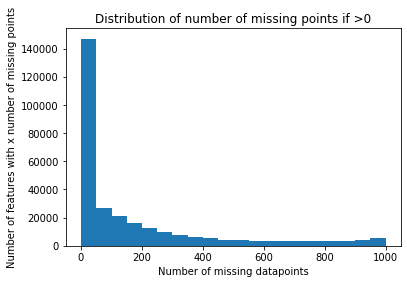

In [32]:
plt.hist(nummissing[nummissing!=0], bins=20)
plt.xlabel('Number of missing datapoints')
plt.ylabel('Number of features with x number of missing points')
plt.title('Distribution of number of missing points if >0')
plt.show()

In [33]:
df_all.isna().sum().sum()/(df_all.shape[1]-df_processed.shape[1])

175.5218318665181

In [35]:
len(nummissing[nummissing==1000]) #275 with 0 data

275

In [18]:
df_all = df_all.dropna(axis='columns', how ='all') #dropping cols with all Nans

In [19]:
df_all.shape

(1000, 485242)

In [19]:
#df_all.to_csv('df_all.csv')

In [20]:
df_processed = df_all.dropna(axis='columns')

In [36]:
df_all.shape, df_processed.shape

((1000, 485517), (1000, 192024))

In [140]:
# %%time
# df_processed.to_csv('df_processed.csv')

In [135]:
np.random.seed(2021)
saved_index = np.random.choice(np.arange(1000), size=300, replace=False)
keep_index = []
for num in range(1000):
    if num not in saved_index:
        keep_index.append(num)

df_p_saved = df_processed.iloc[saved_index, :]
df_p_working = df_processed.iloc[keep_index, :]

In [137]:
X = df_p_working.iloc[:, 5:]
y = df_p_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 2021)

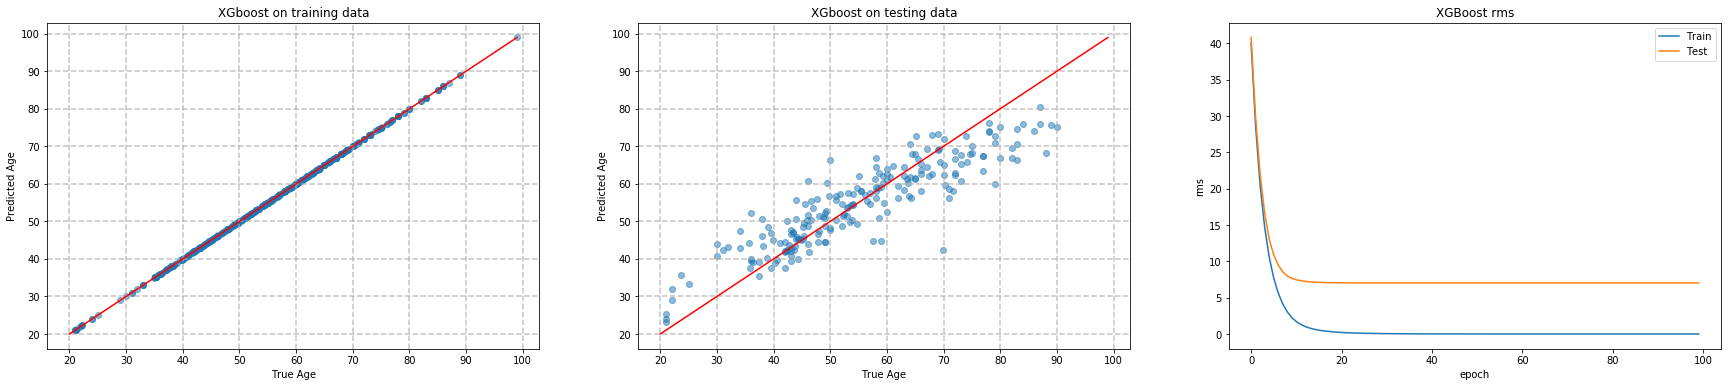

The number of training epochs was 100
The rms on the training data is 0.000 years
The rms on the testing data is 7.029 years
The r^2 on the training data is 1.000
The r^2 on the testing data is 0.787


In [138]:
# Running XGBoost regressor with default settings on
XG, rms_train_xg, rms_test_xg, r2_train_xg, r2_test_xg, feature_importances_xg = xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=None, plot=True)

In [139]:
# Making a dataframe with CpG names and importance scores ordered highest to lowest
df_importance2  = pd.DataFrame({'CpG':df_p_working.columns[5:], 'Importance Score':feature_importances_xg})
df_importance_sorted2  = df_importance2.sort_values('Importance Score', ascending=False)
df_importance_sorted2.head(20)

CpG  Importance Score
64826   cg04875128          0.226108
21220   cg04181121          0.088818
32090   cg16867657          0.085618
67323   cg00614832          0.075616
121032  cg23500537          0.065028
106339  cg14674720          0.047035
80082   cg03628274          0.045623
82788   cg17156767          0.035092
68688   cg04208403          0.026627
126761  cg21572722          0.024269
77617   cg25743486          0.019340
131521  cg14361627          0.015439
130214  cg08097417          0.013740
3686    cg06784991          0.012421
96354   cg09809672          0.010850
34110   cg26433444          0.010175
116163  cg19212674          0.008881
120948  cg23008153          0.007572
63578   cg18877361          0.006930
149235  cg14486857          0.006731

In [55]:
# Split data 80 / 20
from sklearn.model_selection import train_test_split
X = df_100
y = df_p_working.age
X_train_x, X_test_x, y_train_x, y_test_x = train_test_split(X, y, test_size=0.20, random_state = 2023)

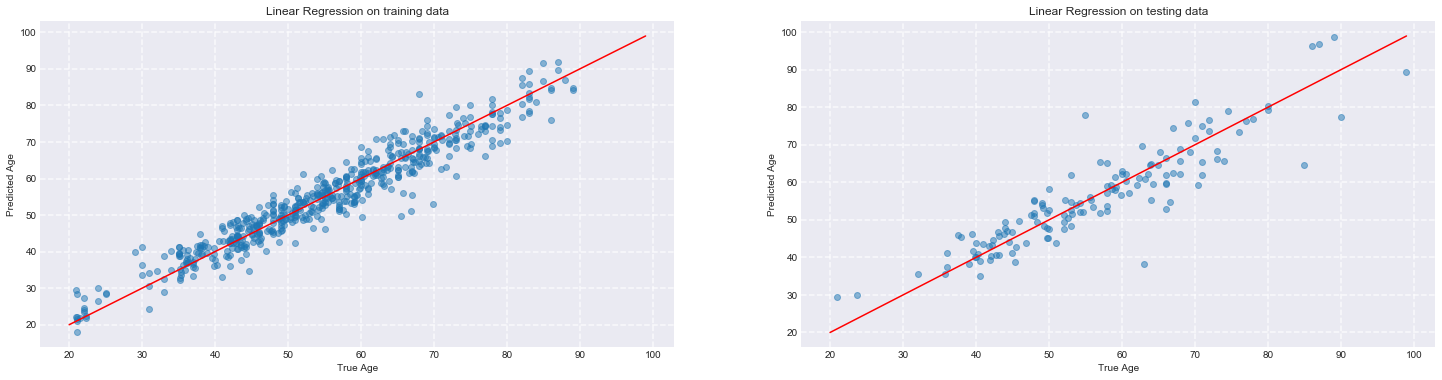

The rms on the training data is 3.940 years
The rms on the testing data is 5.878 years
The r^2 on the training data is 0.924
The r^2 on the testing data is 0.815
Wall time: 380 ms


In [56]:
%%time
mod_lg2, rms_train_lg2, rms_test_lg2, r2_train_lg2, r2_test_lg2 = linear_regress(X_train_x, y_train_x, X_test_x, y_test_x, plot=True)

In [57]:
# Making a df of the savewd data with just 100 cog columns
df_p_saved_100 = df_p_saved[df_importance_sorted['CpG'][:100]]

In [59]:
# Defining X and y from the saved data just 100 cpgs
X_saved_100 = df_p_saved_100
y_saved_100 = df_p_saved.age

In [60]:
# Using the LG model above to make predictions on the saved data
preds_on_saved2 = mod_lg2.predict(X_saved_100)
rms_test_s2 = (mean_squared_error(y_saved_100, preds_on_saved2))**0.5
r2_test_s2 = r2_score(y_saved_100, preds_on_saved2)

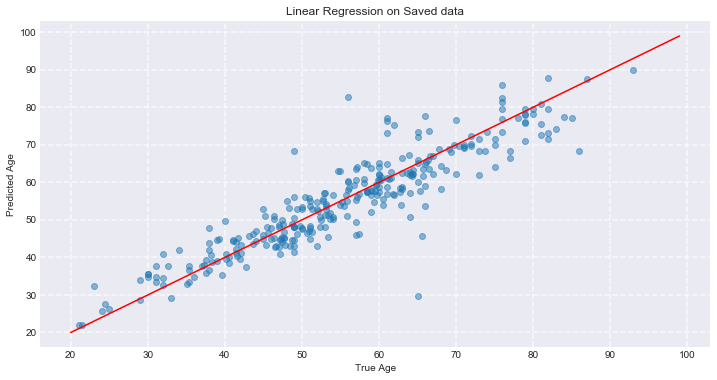

The rms on the saved data is 5.674 years
The r^2 on the saved data is 0.833


In [61]:
# Plotting results
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(y_saved, preds_on_saved2, alpha=0.5)
ax.plot(range(20,100), range(20,100), c='red')
ax.set_xlabel('True Age')
ax.set_ylabel('Predicted Age')
ax.grid(True, lw=1.5, ls='--', alpha=0.75)
ax.set_title('Linear Regression on Saved data')
plt.show()

# print metric
print(f'The rms on the saved data is {rms_test_s2:.3f} years')
print(f'The r^2 on the saved data is {r2_test_s2:.3f}')

In [107]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
def select_features(X_train, y_train, X_test):
    fs = SelectKBest(score_func = f_classif, k='all')
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

In [108]:
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)

In [76]:
len(X_train_fs)

490

In [78]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 0.780689
Feature 1: 0.898200
Feature 2: 1.402935
Feature 3: 0.675693
Feature 4: 1.021487
Feature 5: 1.130637
Feature 6: 1.042568
Feature 7: 1.070653
Feature 8: 0.755963
Feature 9: 1.074100
Feature 10: 1.046074
Feature 11: 0.696519
Feature 12: 1.096846
Feature 13: 1.048480
Feature 14: 1.110181
Feature 15: 1.089412
Feature 16: 0.899541
Feature 17: 1.049112
Feature 18: 1.142214
Feature 19: 1.171215
Feature 20: 1.174636
Feature 21: 1.195612
Feature 22: 1.028543
Feature 23: 0.864831
Feature 24: 1.017195
Feature 25: 1.094673
Feature 26: 1.182977
Feature 27: 1.080871
Feature 28: 1.402047
Feature 29: 0.998120
Feature 30: 1.083588
Feature 31: 1.480281
Feature 32: 1.117067
Feature 33: 1.064915
Feature 34: 1.188615
Feature 35: 1.207309
Feature 36: 1.375099
Feature 37: 1.126577
Feature 38: 1.021681
Feature 39: 0.957774
Feature 40: 1.205052
Feature 41: 1.169131
Feature 42: 1.094346
Feature 43: 1.960278
Feature 44: 1.004553
Feature 45: 0.989569
Feature 46: 1.123141
Feature 47: 1.058206
Fe

Feature 2044: 1.138237
Feature 2045: 0.714032
Feature 2046: 1.387783
Feature 2047: 0.640507
Feature 2048: 1.375880
Feature 2049: 0.256865
Feature 2050: 1.450918
Feature 2051: 1.944532
Feature 2052: 0.950628
Feature 2053: 1.027263
Feature 2054: 0.979288
Feature 2055: 0.475224
Feature 2056: 1.048384
Feature 2057: 0.823283
Feature 2058: 2.268956
Feature 2059: 0.826139
Feature 2060: 0.764652
Feature 2061: 0.938257
Feature 2062: 0.813639
Feature 2063: 1.370023
Feature 2064: 1.329546
Feature 2065: 1.361704
Feature 2066: 0.712249
Feature 2067: 1.065991
Feature 2068: 1.600665
Feature 2069: 1.450887
Feature 2070: 1.281004
Feature 2071: 1.365307
Feature 2072: 0.916034
Feature 2073: 0.920163
Feature 2074: 1.226068
Feature 2075: 1.053680
Feature 2076: 2.251444
Feature 2077: 0.708657
Feature 2078: 1.036458
Feature 2079: 0.911751
Feature 2080: 0.959185
Feature 2081: 1.163042
Feature 2082: 0.718621
Feature 2083: 0.994348
Feature 2084: 1.026122
Feature 2085: 0.964094
Feature 2086: 1.315621
Feature 208

Feature 4390: 1.116759
Feature 4391: 0.995251
Feature 4392: 0.563468
Feature 4393: 0.849426
Feature 4394: 1.567029
Feature 4395: 1.261284
Feature 4396: 1.357830
Feature 4397: 1.319585
Feature 4398: 0.910967
Feature 4399: 0.926900
Feature 4400: 1.146883
Feature 4401: 0.935821
Feature 4402: 1.226739
Feature 4403: 1.540889
Feature 4404: 0.947673
Feature 4405: 1.099579
Feature 4406: 0.661970
Feature 4407: 1.282100
Feature 4408: 0.894611
Feature 4409: 1.272140
Feature 4410: 1.288935
Feature 4411: 0.797262
Feature 4412: 0.753992
Feature 4413: 1.131495
Feature 4414: 0.690968
Feature 4415: 0.462720
Feature 4416: 1.190202
Feature 4417: 1.443520
Feature 4418: 1.726607
Feature 4419: 0.829647
Feature 4420: 0.867373
Feature 4421: 0.901479
Feature 4422: 1.228200
Feature 4423: 0.925914
Feature 4424: 1.025599
Feature 4425: 1.148757
Feature 4426: 1.095369
Feature 4427: 0.961063
Feature 4428: 0.767251
Feature 4429: 1.274598
Feature 4430: 0.732867
Feature 4431: 0.954021
Feature 4432: 1.057873
Feature 443

Feature 6063: 0.664810
Feature 6064: 0.968609
Feature 6065: 1.181400
Feature 6066: 1.398511
Feature 6067: 1.141423
Feature 6068: 0.803695
Feature 6069: 1.539153
Feature 6070: 0.831744
Feature 6071: 1.159124
Feature 6072: 0.636746
Feature 6073: 1.220595
Feature 6074: 0.932822
Feature 6075: 0.773198
Feature 6076: 1.608659
Feature 6077: 1.127464
Feature 6078: 0.930337
Feature 6079: 1.362008
Feature 6080: 0.873736
Feature 6081: 1.247708
Feature 6082: 0.770722
Feature 6083: 0.594219
Feature 6084: 0.885209
Feature 6085: 1.138578
Feature 6086: 1.241686
Feature 6087: 0.897449
Feature 6088: 1.112086
Feature 6089: 1.379364
Feature 6090: 1.311420
Feature 6091: 1.005968
Feature 6092: 1.128380
Feature 6093: 0.695930
Feature 6094: 0.558834
Feature 6095: 1.115693
Feature 6096: 1.320336
Feature 6097: 0.910883
Feature 6098: 0.881678
Feature 6099: 1.156944
Feature 6100: 0.669318
Feature 6101: 0.761344
Feature 6102: 1.144349
Feature 6103: 1.495555
Feature 6104: 1.457263
Feature 6105: 1.047484
Feature 610

Feature 7873: 1.279503
Feature 7874: 0.705957
Feature 7875: 1.078661
Feature 7876: 1.101789
Feature 7877: 2.808805
Feature 7878: 1.085758
Feature 7879: 1.368849
Feature 7880: 1.192089
Feature 7881: 0.896724
Feature 7882: 1.171340
Feature 7883: 1.121191
Feature 7884: 0.986498
Feature 7885: 1.293153
Feature 7886: 0.700473
Feature 7887: 0.938220
Feature 7888: 1.409590
Feature 7889: 1.069021
Feature 7890: 1.264786
Feature 7891: 0.851641
Feature 7892: 0.981037
Feature 7893: 0.956099
Feature 7894: 1.060345
Feature 7895: 1.403205
Feature 7896: 0.957087
Feature 7897: 0.866577
Feature 7898: 1.320504
Feature 7899: 0.815303
Feature 7900: 1.109251
Feature 7901: 1.632723
Feature 7902: 1.248254
Feature 7903: 0.715963
Feature 7904: 1.038857
Feature 7905: 0.608701
Feature 7906: 0.425370
Feature 7907: 0.956506
Feature 7908: 1.425132
Feature 7909: 0.866916
Feature 7910: 1.100649
Feature 7911: 1.188666
Feature 7912: 1.589054
Feature 7913: 1.264416
Feature 7914: 0.972616
Feature 7915: 1.078334
Feature 791

Feature 10634: 0.890816
Feature 10635: 0.875716
Feature 10636: 0.785363
Feature 10637: 1.348940
Feature 10638: 1.286782
Feature 10639: 1.118986
Feature 10640: 1.029272
Feature 10641: 0.918108
Feature 10642: 0.903074
Feature 10643: 1.060474
Feature 10644: 1.444731
Feature 10645: 1.071104
Feature 10646: 0.704687
Feature 10647: 0.880499
Feature 10648: 0.928586
Feature 10649: 1.488640
Feature 10650: 0.301215
Feature 10651: 0.484804
Feature 10652: 0.825278
Feature 10653: 0.745168
Feature 10654: 0.832650
Feature 10655: 1.294841
Feature 10656: 0.681450
Feature 10657: 1.559391
Feature 10658: 0.926236
Feature 10659: 0.747449
Feature 10660: 0.923205
Feature 10661: 1.163432
Feature 10662: 0.494189
Feature 10663: 1.354310
Feature 10664: 1.164256
Feature 10665: 1.425480
Feature 10666: 1.505681
Feature 10667: 1.255579
Feature 10668: 1.207835
Feature 10669: 0.821810
Feature 10670: 1.125623
Feature 10671: 0.802304
Feature 10672: 0.757232
Feature 10673: 1.577468
Feature 10674: 1.721486
Feature 10675: 1

Feature 12212: 1.446826
Feature 12213: 1.589665
Feature 12214: 1.073967
Feature 12215: 1.431295
Feature 12216: 1.065375
Feature 12217: 0.827995
Feature 12218: 1.240762
Feature 12219: 0.977176
Feature 12220: 1.101405
Feature 12221: 1.577374
Feature 12222: 1.241016
Feature 12223: 1.280811
Feature 12224: 1.194200
Feature 12225: 0.914894
Feature 12226: 1.260111
Feature 12227: 1.372076
Feature 12228: 0.955362
Feature 12229: 0.810475
Feature 12230: 1.403681
Feature 12231: 1.347715
Feature 12232: 1.117860
Feature 12233: 1.101236
Feature 12234: 0.862370
Feature 12235: 0.918042
Feature 12236: 0.810553
Feature 12237: 1.028828
Feature 12238: 0.821247
Feature 12239: 0.939561
Feature 12240: 1.279334
Feature 12241: 1.133959
Feature 12242: 1.130326
Feature 12243: 1.179426
Feature 12244: 1.234360
Feature 12245: 1.032320
Feature 12246: 1.239911
Feature 12247: 1.196579
Feature 12248: 0.713075
Feature 12249: 0.835326
Feature 12250: 0.779618
Feature 12251: 0.912142
Feature 12252: 0.977868
Feature 12253: 0

Feature 14259: 1.045279
Feature 14260: 1.026026
Feature 14261: 0.813775
Feature 14262: 0.984251
Feature 14263: 1.237476
Feature 14264: 1.176253
Feature 14265: 1.159875
Feature 14266: 1.772172
Feature 14267: 0.773556
Feature 14268: 1.887491
Feature 14269: 1.288709
Feature 14270: 0.412608
Feature 14271: 1.369934
Feature 14272: 0.975032
Feature 14273: 1.432951
Feature 14274: 1.875552
Feature 14275: 2.320455
Feature 14276: 0.851436
Feature 14277: 1.096208
Feature 14278: 0.583048
Feature 14279: 1.562553
Feature 14280: 1.053395
Feature 14281: 1.544760
Feature 14282: 0.777917
Feature 14283: 1.350723
Feature 14284: 1.147206
Feature 14285: 1.104825
Feature 14286: 0.951410
Feature 14287: 0.855063
Feature 14288: 0.774357
Feature 14289: 0.526263
Feature 14290: 1.076712
Feature 14291: 1.462536
Feature 14292: 1.041991
Feature 14293: 1.046032
Feature 14294: 0.707598
Feature 14295: 1.556633
Feature 14296: 0.725640
Feature 14297: 0.919638
Feature 14298: 1.016589
Feature 14299: 0.879040
Feature 14300: 1

Feature 16289: 1.322570
Feature 16290: 1.121519
Feature 16291: 0.626142
Feature 16292: 1.066673
Feature 16293: 1.209462
Feature 16294: 0.682975
Feature 16295: 1.088797
Feature 16296: 1.168325
Feature 16297: 0.662730
Feature 16298: 0.874681
Feature 16299: 0.829691
Feature 16300: 1.248271
Feature 16301: 0.603360
Feature 16302: 1.043601
Feature 16303: 1.087563
Feature 16304: 0.948084
Feature 16305: 1.190023
Feature 16306: 1.000234
Feature 16307: 1.114125
Feature 16308: 0.775471
Feature 16309: 1.357945
Feature 16310: 0.610231
Feature 16311: 1.157298
Feature 16312: 0.887286
Feature 16313: 1.196884
Feature 16314: 0.942818
Feature 16315: 1.529627
Feature 16316: 1.073222
Feature 16317: 0.954479
Feature 16318: 0.945551
Feature 16319: 1.315282
Feature 16320: 0.736399
Feature 16321: 0.685042
Feature 16322: 2.129321
Feature 16323: 1.057467
Feature 16324: 1.096473
Feature 16325: 0.743168
Feature 16326: 0.567288
Feature 16327: 1.303495
Feature 16328: 1.517919
Feature 16329: 0.858020
Feature 16330: 1

Feature 18378: 1.472425
Feature 18379: 1.193580
Feature 18380: 0.922899
Feature 18381: 0.663425
Feature 18382: 1.108688
Feature 18383: 2.024041
Feature 18384: 1.062108
Feature 18385: 1.754027
Feature 18386: 1.507358
Feature 18387: 1.614621
Feature 18388: 0.668110
Feature 18389: 0.854124
Feature 18390: 0.844461
Feature 18391: 1.378986
Feature 18392: 0.526600
Feature 18393: 0.969491
Feature 18394: 0.733905
Feature 18395: 1.213457
Feature 18396: 1.239830
Feature 18397: 1.175121
Feature 18398: 1.475235
Feature 18399: 1.109851
Feature 18400: 1.004866
Feature 18401: 1.202212
Feature 18402: 1.098333
Feature 18403: 0.719097
Feature 18404: 0.881072
Feature 18405: 1.215298
Feature 18406: 1.812098
Feature 18407: 1.088807
Feature 18408: 0.397010
Feature 18409: 0.746039
Feature 18410: 1.537034
Feature 18411: 0.538598
Feature 18412: 1.033605
Feature 18413: 0.581715
Feature 18414: 1.644244
Feature 18415: 1.185024
Feature 18416: 0.948897
Feature 18417: 0.979104
Feature 18418: 0.519050
Feature 18419: 1

Feature 20241: 1.100525
Feature 20242: 0.894496
Feature 20243: 0.999175
Feature 20244: 1.113175
Feature 20245: 0.768942
Feature 20246: 1.140773
Feature 20247: 1.509643
Feature 20248: 0.773948
Feature 20249: 1.530213
Feature 20250: 1.289116
Feature 20251: 1.945168
Feature 20252: 1.038575
Feature 20253: 0.908444
Feature 20254: 0.874518
Feature 20255: 0.904009
Feature 20256: 0.926472
Feature 20257: 1.036712
Feature 20258: 1.155070
Feature 20259: 1.201374
Feature 20260: 1.310945
Feature 20261: 1.000874
Feature 20262: 0.933895
Feature 20263: 1.201604
Feature 20264: 0.990318
Feature 20265: 0.693493
Feature 20266: 0.952543
Feature 20267: 1.236646
Feature 20268: 0.827780
Feature 20269: 0.458914
Feature 20270: 1.049960
Feature 20271: 1.508210
Feature 20272: 1.012022
Feature 20273: 1.345580
Feature 20274: 0.986936
Feature 20275: 1.060444
Feature 20276: 1.174810
Feature 20277: 0.953240
Feature 20278: 0.937191
Feature 20279: 0.400970
Feature 20280: 1.032986
Feature 20281: 0.762314
Feature 20282: 0

Feature 22205: 0.928147
Feature 22206: 0.921621
Feature 22207: 0.510791
Feature 22208: 0.908915
Feature 22209: 1.137476
Feature 22210: 1.072820
Feature 22211: 0.992443
Feature 22212: 1.211538
Feature 22213: 1.338211
Feature 22214: 1.172345
Feature 22215: 1.254703
Feature 22216: 1.032098
Feature 22217: 1.035505
Feature 22218: 0.514130
Feature 22219: 0.821846
Feature 22220: 0.855988
Feature 22221: 1.044708
Feature 22222: 0.841641
Feature 22223: 1.090316
Feature 22224: 1.859710
Feature 22225: 0.819781
Feature 22226: 0.824249
Feature 22227: 0.723136
Feature 22228: 1.127362
Feature 22229: 0.664920
Feature 22230: 1.397125
Feature 22231: 1.158197
Feature 22232: 0.802389
Feature 22233: 0.898538
Feature 22234: 1.706116
Feature 22235: 0.662677
Feature 22236: 1.026127
Feature 22237: 1.216774
Feature 22238: 0.812650
Feature 22239: 0.437978
Feature 22240: 1.011407
Feature 22241: 0.907356
Feature 22242: 0.741443
Feature 22243: 0.898335
Feature 22244: 0.976821
Feature 22245: 1.000390
Feature 22246: 0

Feature 24206: 0.943595
Feature 24207: 1.226629
Feature 24208: 1.179387
Feature 24209: 0.536493
Feature 24210: 1.070904
Feature 24211: 1.079473
Feature 24212: 1.432481
Feature 24213: 1.147067
Feature 24214: 0.720803
Feature 24215: 0.773877
Feature 24216: 0.884558
Feature 24217: 1.089507
Feature 24218: 1.091839
Feature 24219: 1.506753
Feature 24220: 1.159298
Feature 24221: 1.050230
Feature 24222: 0.875252
Feature 24223: 0.867550
Feature 24224: 1.032624
Feature 24225: 0.960112
Feature 24226: 0.930658
Feature 24227: 1.210926
Feature 24228: 0.975953
Feature 24229: 0.591235
Feature 24230: 1.489644
Feature 24231: 1.370910
Feature 24232: 1.233732
Feature 24233: 1.123409
Feature 24234: 0.784028
Feature 24235: 0.639607
Feature 24236: 1.558407
Feature 24237: 0.983626
Feature 24238: 0.932508
Feature 24239: 0.836134
Feature 24240: 0.782252
Feature 24241: 0.745340
Feature 24242: 1.105131
Feature 24243: 1.423321
Feature 24244: 0.939438
Feature 24245: 1.013338
Feature 24246: 0.683129
Feature 24247: 0

Feature 26181: 1.112512
Feature 26182: 0.831802
Feature 26183: 1.006804
Feature 26184: 0.612977
Feature 26185: 1.226868
Feature 26186: 1.017463
Feature 26187: 0.780265
Feature 26188: 0.990463
Feature 26189: 0.606969
Feature 26190: 0.975540
Feature 26191: 0.651370
Feature 26192: 0.723899
Feature 26193: 1.492142
Feature 26194: 0.977467
Feature 26195: 0.596943
Feature 26196: 1.273207
Feature 26197: 1.008239
Feature 26198: 0.950117
Feature 26199: 1.046794
Feature 26200: 0.959558
Feature 26201: 1.275897
Feature 26202: 0.863971
Feature 26203: 0.415529
Feature 26204: 0.612147
Feature 26205: 0.892563
Feature 26206: 1.195689
Feature 26207: 0.943982
Feature 26208: 0.503183
Feature 26209: 0.548122
Feature 26210: 0.728453
Feature 26211: 1.033187
Feature 26212: 0.572426
Feature 26213: 0.846735
Feature 26214: 0.807816
Feature 26215: 1.030589
Feature 26216: 0.840937
Feature 26217: 1.232826
Feature 26218: 1.247133
Feature 26219: 0.701821
Feature 26220: 1.293810
Feature 26221: 0.972829
Feature 26222: 1

Feature 28182: 1.083190
Feature 28183: 1.151164
Feature 28184: 0.504193
Feature 28185: 0.897735
Feature 28186: 0.817336
Feature 28187: 1.043285
Feature 28188: 1.195284
Feature 28189: 0.790033
Feature 28190: 0.746928
Feature 28191: 0.660835
Feature 28192: 1.112188
Feature 28193: 0.526602
Feature 28194: 0.993963
Feature 28195: 1.029613
Feature 28196: 0.756443
Feature 28197: 0.897523
Feature 28198: 1.345935
Feature 28199: 1.040199
Feature 28200: 0.848111
Feature 28201: 0.757269
Feature 28202: 0.944796
Feature 28203: 0.890578
Feature 28204: 1.230631
Feature 28205: 0.311784
Feature 28206: 0.635720
Feature 28207: 1.165012
Feature 28208: 0.766280
Feature 28209: 0.565878
Feature 28210: 1.284653
Feature 28211: 1.552158
Feature 28212: 0.862999
Feature 28213: 1.225174
Feature 28214: 0.738313
Feature 28215: 2.054132
Feature 28216: 1.009797
Feature 28217: 0.847425
Feature 28218: 0.722076
Feature 28219: 1.086763
Feature 28220: 1.443604
Feature 28221: 1.227890
Feature 28222: 0.881037
Feature 28223: 0

Feature 29457: 1.015656
Feature 29458: 1.183540
Feature 29459: 1.382048
Feature 29460: 0.679505
Feature 29461: 0.767611
Feature 29462: 0.833758
Feature 29463: 0.799314
Feature 29464: 1.237086
Feature 29465: 1.452268
Feature 29466: 0.817568
Feature 29467: 1.449889
Feature 29468: 0.918691
Feature 29469: 1.373251
Feature 29470: 0.980345
Feature 29471: 0.996458
Feature 29472: 0.971534
Feature 29473: 1.069743
Feature 29474: 2.727527
Feature 29475: 1.217510
Feature 29476: 1.135450
Feature 29477: 1.068788
Feature 29478: 1.265464
Feature 29479: 1.508482
Feature 29480: 0.913299
Feature 29481: 1.240463
Feature 29482: 0.529975
Feature 29483: 1.098899
Feature 29484: 0.502723
Feature 29485: 0.899651
Feature 29486: 0.874587
Feature 29487: 2.246408
Feature 29488: 0.755608
Feature 29489: 0.724664
Feature 29490: 0.840502
Feature 29491: 0.970850
Feature 29492: 1.274191
Feature 29493: 0.750884
Feature 29494: 0.965220
Feature 29495: 0.771102
Feature 29496: 0.556039
Feature 29497: 1.242947
Feature 29498: 0

Feature 31882: 1.344228
Feature 31883: 1.010596
Feature 31884: 0.793277
Feature 31885: 1.889278
Feature 31886: 0.807641
Feature 31887: 1.210113
Feature 31888: 0.763463
Feature 31889: 1.058949
Feature 31890: 0.691240
Feature 31891: 0.792147
Feature 31892: 1.890323
Feature 31893: 0.782021
Feature 31894: 0.750967
Feature 31895: 1.330626
Feature 31896: 0.965337
Feature 31897: 0.790450
Feature 31898: 1.077686
Feature 31899: 0.832207
Feature 31900: 0.898333
Feature 31901: 1.178653
Feature 31902: 0.958629
Feature 31903: 1.109128
Feature 31904: 0.929319
Feature 31905: 1.045852
Feature 31906: 1.015979
Feature 31907: 0.568341
Feature 31908: 1.421465
Feature 31909: 0.532068
Feature 31910: 1.536041
Feature 31911: 0.953113
Feature 31912: 0.765606
Feature 31913: 0.806861
Feature 31914: 1.209229
Feature 31915: 1.677100
Feature 31916: 0.992414
Feature 31917: 0.906727
Feature 31918: 0.904064
Feature 31919: 1.064018
Feature 31920: 1.116251
Feature 31921: 0.748413
Feature 31922: 0.822881
Feature 31923: 0

Feature 33778: 1.421357
Feature 33779: 0.908047
Feature 33780: 0.766449
Feature 33781: 1.203575
Feature 33782: 0.737484
Feature 33783: 1.651661
Feature 33784: 0.990825
Feature 33785: 0.900498
Feature 33786: 1.422045
Feature 33787: 1.154472
Feature 33788: 1.111821
Feature 33789: 1.580168
Feature 33790: 0.597193
Feature 33791: 0.908607
Feature 33792: 1.145476
Feature 33793: 1.447868
Feature 33794: 1.220337
Feature 33795: 1.074672
Feature 33796: 0.900474
Feature 33797: 0.651827
Feature 33798: 1.359325
Feature 33799: 1.050240
Feature 33800: 1.094435
Feature 33801: 1.655690
Feature 33802: 0.740068
Feature 33803: 0.801475
Feature 33804: 0.634098
Feature 33805: 0.687443
Feature 33806: 0.906052
Feature 33807: 1.204126
Feature 33808: 1.433938
Feature 33809: 1.464736
Feature 33810: 1.433577
Feature 33811: 1.042271
Feature 33812: 0.954478
Feature 33813: 0.644503
Feature 33814: 1.240654
Feature 33815: 0.963916
Feature 33816: 0.886891
Feature 33817: 1.122704
Feature 33818: 0.984334
Feature 33819: 0

Feature 36102: 1.365633
Feature 36103: 1.048937
Feature 36104: 1.143999
Feature 36105: 0.981800
Feature 36106: 0.917068
Feature 36107: 1.188540
Feature 36108: 0.821579
Feature 36109: 1.781441
Feature 36110: 0.673377
Feature 36111: 0.805478
Feature 36112: 1.083785
Feature 36113: 1.126276
Feature 36114: 0.697381
Feature 36115: 0.827491
Feature 36116: 0.756642
Feature 36117: 1.040312
Feature 36118: 0.903985
Feature 36119: 0.835164
Feature 36120: 0.972872
Feature 36121: 0.674056
Feature 36122: 1.458903
Feature 36123: 1.251968
Feature 36124: 1.232692
Feature 36125: 0.899318
Feature 36126: 1.698805
Feature 36127: 1.277902
Feature 36128: 0.488442
Feature 36129: 0.788856
Feature 36130: 0.586276
Feature 36131: 0.909229
Feature 36132: 1.154316
Feature 36133: 1.531427
Feature 36134: 1.222357
Feature 36135: 1.340640
Feature 36136: 0.692102
Feature 36137: 0.968729
Feature 36138: 1.935873
Feature 36139: 0.950514
Feature 36140: 0.781241
Feature 36141: 0.786660
Feature 36142: 0.951246
Feature 36143: 1

Feature 38058: 1.474486
Feature 38059: 1.199879
Feature 38060: 1.765014
Feature 38061: 1.044310
Feature 38062: 1.837912
Feature 38063: 0.913130
Feature 38064: 0.792594
Feature 38065: 1.237741
Feature 38066: 0.985151
Feature 38067: 1.148881
Feature 38068: 1.074306
Feature 38069: 0.627209
Feature 38070: 0.675711
Feature 38071: 0.659223
Feature 38072: 0.494966
Feature 38073: 0.958491
Feature 38074: 0.997831
Feature 38075: 1.392255
Feature 38076: 0.544155
Feature 38077: 0.991765
Feature 38078: 0.620254
Feature 38079: 1.134885
Feature 38080: 1.473094
Feature 38081: 1.060362
Feature 38082: 0.762726
Feature 38083: 0.734627
Feature 38084: 1.072916
Feature 38085: 1.095676
Feature 38086: 0.892532
Feature 38087: 0.926523
Feature 38088: 1.308352
Feature 38089: 1.395201
Feature 38090: 1.434864
Feature 38091: 1.432572
Feature 38092: 1.573266
Feature 38093: 0.988733
Feature 38094: 0.885683
Feature 38095: 1.192572
Feature 38096: 0.540943
Feature 38097: 1.018985
Feature 38098: 1.069492
Feature 38099: 1

Feature 40554: 0.745874
Feature 40555: 1.032457
Feature 40556: 1.023488
Feature 40557: 0.950950
Feature 40558: 1.035275
Feature 40559: 0.868626
Feature 40560: 0.900568
Feature 40561: 0.800938
Feature 40562: 0.646451
Feature 40563: 0.700352
Feature 40564: 0.575888
Feature 40565: 0.611266
Feature 40566: 1.019721
Feature 40567: 0.911139
Feature 40568: 1.153480
Feature 40569: 1.492881
Feature 40570: 0.970649
Feature 40571: 0.789034
Feature 40572: 1.826985
Feature 40573: 0.975948
Feature 40574: 1.244700
Feature 40575: 1.247681
Feature 40576: 2.285689
Feature 40577: 1.278017
Feature 40578: 0.381037
Feature 40579: 0.699321
Feature 40580: 0.761496
Feature 40581: 1.056381
Feature 40582: 0.934403
Feature 40583: 0.803942
Feature 40584: 3.292715
Feature 40585: 0.988705
Feature 40586: 1.352977
Feature 40587: 0.828905
Feature 40588: 1.234849
Feature 40589: 0.812350
Feature 40590: 0.932057
Feature 40591: 1.279593
Feature 40592: 0.944058
Feature 40593: 0.901012
Feature 40594: 0.459808
Feature 40595: 0

Feature 42866: 1.072441
Feature 42867: 1.090941
Feature 42868: 0.530399
Feature 42869: 0.789493
Feature 42870: 0.620142
Feature 42871: 0.498432
Feature 42872: 0.781454
Feature 42873: 1.227204
Feature 42874: 1.150884
Feature 42875: 0.965756
Feature 42876: 0.899042
Feature 42877: 1.227987
Feature 42878: 0.956352
Feature 42879: 1.044659
Feature 42880: 1.136236
Feature 42881: 0.760049
Feature 42882: 1.042503
Feature 42883: 0.884749
Feature 42884: 1.750497
Feature 42885: 8.047775
Feature 42886: 1.819361
Feature 42887: 0.948638
Feature 42888: 0.824094
Feature 42889: 2.515517
Feature 42890: 1.113249
Feature 42891: 1.028442
Feature 42892: 0.722557
Feature 42893: 1.702829
Feature 42894: 1.197621
Feature 42895: 1.082400
Feature 42896: 1.196012
Feature 42897: 1.142741
Feature 42898: 0.517509
Feature 42899: 0.928844
Feature 42900: 1.085476
Feature 42901: 1.184851
Feature 42902: 1.015224
Feature 42903: 1.202796
Feature 42904: 0.584336
Feature 42905: 0.694963
Feature 42906: 0.579683
Feature 42907: 0

Feature 44596: 1.761197
Feature 44597: 1.083016
Feature 44598: 0.448492
Feature 44599: 1.174951
Feature 44600: 1.293317
Feature 44601: 2.390615
Feature 44602: 0.944622
Feature 44603: 0.742893
Feature 44604: 8.520729
Feature 44605: 1.329424
Feature 44606: 1.143684
Feature 44607: 1.119324
Feature 44608: 1.297687
Feature 44609: 0.928020
Feature 44610: 1.804569
Feature 44611: 1.230592
Feature 44612: 1.156336
Feature 44613: 1.401920
Feature 44614: 0.879151
Feature 44615: 1.271436
Feature 44616: 0.719704
Feature 44617: 0.970665
Feature 44618: 1.636365
Feature 44619: 0.540025
Feature 44620: 1.071256
Feature 44621: 0.954089
Feature 44622: 1.070243
Feature 44623: 0.817166
Feature 44624: 0.880209
Feature 44625: 0.542521
Feature 44626: 0.863069
Feature 44627: 1.057427
Feature 44628: 0.915843
Feature 44629: 0.792164
Feature 44630: 1.284066
Feature 44631: 1.064139
Feature 44632: 1.138996
Feature 44633: 1.415315
Feature 44634: 0.595027
Feature 44635: 0.750277
Feature 44636: 1.038269
Feature 44637: 0

Feature 46501: 1.062155
Feature 46502: 0.860632
Feature 46503: 0.991511
Feature 46504: 0.770131
Feature 46505: 0.876593
Feature 46506: 0.987693
Feature 46507: 0.697688
Feature 46508: 1.153088
Feature 46509: 1.001588
Feature 46510: 0.872458
Feature 46511: 0.911467
Feature 46512: 0.749623
Feature 46513: 1.061700
Feature 46514: 1.182250
Feature 46515: 1.020067
Feature 46516: 1.111609
Feature 46517: 0.931337
Feature 46518: 1.437492
Feature 46519: 0.768791
Feature 46520: 0.859692
Feature 46521: 1.082860
Feature 46522: 0.879523
Feature 46523: 0.766462
Feature 46524: 0.778500
Feature 46525: 1.125653
Feature 46526: 1.264553
Feature 46527: 0.978565
Feature 46528: 1.040969
Feature 46529: 1.256152
Feature 46530: 0.683371
Feature 46531: 0.852783
Feature 46532: 1.602438
Feature 46533: 0.991721
Feature 46534: 1.525947
Feature 46535: 0.995153
Feature 46536: 1.048544
Feature 46537: 1.180146
Feature 46538: 0.940571
Feature 46539: 1.179958
Feature 46540: 0.892964
Feature 46541: 0.798657
Feature 46542: 1

Feature 48285: 0.655919
Feature 48286: 1.205229
Feature 48287: 1.608128
Feature 48288: 0.904863
Feature 48289: 0.809365
Feature 48290: 1.298927
Feature 48291: 0.672154
Feature 48292: 0.896697
Feature 48293: 0.476158
Feature 48294: 1.119392
Feature 48295: 0.894094
Feature 48296: 1.157142
Feature 48297: 0.958463
Feature 48298: 1.268218
Feature 48299: 1.151679
Feature 48300: 0.639108
Feature 48301: 0.971389
Feature 48302: 0.696198
Feature 48303: 0.755244
Feature 48304: 1.036877
Feature 48305: 1.432008
Feature 48306: 1.344792
Feature 48307: 0.592989
Feature 48308: 2.435706
Feature 48309: 0.768555
Feature 48310: 1.008208
Feature 48311: 0.836293
Feature 48312: 1.188354
Feature 48313: 0.700209
Feature 48314: 0.999227
Feature 48315: 1.372697
Feature 48316: 1.177185
Feature 48317: 0.979836
Feature 48318: 1.010869
Feature 48319: 1.972430
Feature 48320: 1.258513
Feature 48321: 0.837436
Feature 48322: 0.862186
Feature 48323: 1.136727
Feature 48324: 1.282533
Feature 48325: 1.682695
Feature 48326: 1

Feature 49988: 1.690258
Feature 49989: 0.834003
Feature 49990: 1.325476
Feature 49991: 1.439477
Feature 49992: 0.987240
Feature 49993: 1.078594
Feature 49994: 0.572914
Feature 49995: 0.725366
Feature 49996: 1.039310
Feature 49997: 0.909289
Feature 49998: 0.548136
Feature 49999: 1.091614
Feature 50000: 0.725738
Feature 50001: 1.662305
Feature 50002: 0.926396
Feature 50003: 0.785472
Feature 50004: 0.973585
Feature 50005: 1.347126
Feature 50006: 0.742063
Feature 50007: 1.210524
Feature 50008: 1.128491
Feature 50009: 1.084964
Feature 50010: 0.855051
Feature 50011: 0.755089
Feature 50012: 2.308361
Feature 50013: 0.876446
Feature 50014: 1.046988
Feature 50015: 0.998545
Feature 50016: 1.012774
Feature 50017: 1.623802
Feature 50018: 0.877099
Feature 50019: 1.202945
Feature 50020: 1.393115
Feature 50021: 1.483595
Feature 50022: 1.301007
Feature 50023: 1.043889
Feature 50024: 1.117242
Feature 50025: 1.106281
Feature 50026: 0.868728
Feature 50027: 1.202094
Feature 50028: 0.647194
Feature 50029: 0

Feature 52623: 1.124505
Feature 52624: 1.003912
Feature 52625: 0.735967
Feature 52626: 0.951573
Feature 52627: 1.236291
Feature 52628: 1.123403
Feature 52629: 0.871496
Feature 52630: 1.291366
Feature 52631: 0.789830
Feature 52632: 1.123953
Feature 52633: 1.152793
Feature 52634: 0.755848
Feature 52635: 0.811044
Feature 52636: 1.067475
Feature 52637: 0.781108
Feature 52638: 1.552056
Feature 52639: 1.053483
Feature 52640: 0.850529
Feature 52641: 1.011827
Feature 52642: 0.889979
Feature 52643: 1.800357
Feature 52644: 0.647163
Feature 52645: 1.314289
Feature 52646: 0.836727
Feature 52647: 0.842515
Feature 52648: 1.082973
Feature 52649: 0.865374
Feature 52650: 1.451187
Feature 52651: 1.733349
Feature 52652: 1.189074
Feature 52653: 0.755925
Feature 52654: 1.039468
Feature 52655: 1.074005
Feature 52656: 1.794927
Feature 52657: 0.301389
Feature 52658: 1.049629
Feature 52659: 0.678438
Feature 52660: 0.858268
Feature 52661: 1.261040
Feature 52662: 1.354721
Feature 52663: 1.229772
Feature 52664: 0

Feature 54308: 0.900147
Feature 54309: 0.887549
Feature 54310: 0.985847
Feature 54311: 0.882843
Feature 54312: 0.814991
Feature 54313: 1.368135
Feature 54314: 1.084581
Feature 54315: 1.078065
Feature 54316: 1.063995
Feature 54317: 1.056693
Feature 54318: 1.153522
Feature 54319: 0.675513
Feature 54320: 0.714818
Feature 54321: 1.040975
Feature 54322: 0.909843
Feature 54323: 0.899438
Feature 54324: 1.035719
Feature 54325: 0.626664
Feature 54326: 0.922335
Feature 54327: 1.137946
Feature 54328: 1.336732
Feature 54329: 0.961432
Feature 54330: 1.621504
Feature 54331: 1.309668
Feature 54332: 1.277249
Feature 54333: 1.095708
Feature 54334: 1.321925
Feature 54335: 1.050121
Feature 54336: 1.099273
Feature 54337: 1.124776
Feature 54338: 0.979272
Feature 54339: 0.881531
Feature 54340: 1.959597
Feature 54341: 0.672108
Feature 54342: 1.092704
Feature 54343: 1.171542
Feature 54344: 0.343488
Feature 54345: 0.760636
Feature 54346: 1.746736
Feature 54347: 0.885327
Feature 54348: 0.879114
Feature 54349: 0

Feature 56484: 0.891039
Feature 56485: 0.755341
Feature 56486: 1.082084
Feature 56487: 1.744579
Feature 56488: 1.138120
Feature 56489: 1.271615
Feature 56490: 0.815697
Feature 56491: 1.556539
Feature 56492: 1.326726
Feature 56493: 0.921493
Feature 56494: 0.841314
Feature 56495: 0.720686
Feature 56496: 1.529467
Feature 56497: 1.745410
Feature 56498: 0.955159
Feature 56499: 0.933292
Feature 56500: 0.723323
Feature 56501: 0.644052
Feature 56502: 1.131065
Feature 56503: 0.875744
Feature 56504: 0.978848
Feature 56505: 0.823265
Feature 56506: 1.108319
Feature 56507: 1.073897
Feature 56508: 1.457737
Feature 56509: 1.239678
Feature 56510: 1.203749
Feature 56511: 0.860860
Feature 56512: 0.797778
Feature 56513: 0.925911
Feature 56514: 0.880138
Feature 56515: 1.183223
Feature 56516: 1.085056
Feature 56517: 0.528953
Feature 56518: 0.948295
Feature 56519: 1.860506
Feature 56520: 1.138275
Feature 56521: 0.882258
Feature 56522: 0.882295
Feature 56523: 0.988630
Feature 56524: 1.022788
Feature 56525: 1

Feature 58728: 0.600877
Feature 58729: 0.990647
Feature 58730: 0.973695
Feature 58731: 1.306273
Feature 58732: 1.377882
Feature 58733: 0.859559
Feature 58734: 0.856572
Feature 58735: 0.623696
Feature 58736: 1.896244
Feature 58737: 1.200693
Feature 58738: 1.412932
Feature 58739: 1.025818
Feature 58740: 1.156100
Feature 58741: 1.530114
Feature 58742: 0.868733
Feature 58743: 4.387550
Feature 58744: 0.514709
Feature 58745: 1.328287
Feature 58746: 0.910882
Feature 58747: 0.887440
Feature 58748: 1.332666
Feature 58749: 1.114247
Feature 58750: 1.148021
Feature 58751: 1.224297
Feature 58752: 1.087655
Feature 58753: 1.469610
Feature 58754: 0.922211
Feature 58755: 1.222428
Feature 58756: 0.922889
Feature 58757: 1.363077
Feature 58758: 0.565187
Feature 58759: 1.159496
Feature 58760: 0.839099
Feature 58761: 0.767748
Feature 58762: 1.053197
Feature 58763: 1.575240
Feature 58764: 1.475073
Feature 58765: 0.856738
Feature 58766: 1.438043
Feature 58767: 0.847135
Feature 58768: 0.860055
Feature 58769: 0

Feature 61232: 0.651936
Feature 61233: 0.774668
Feature 61234: 2.013979
Feature 61235: 1.233981
Feature 61236: 1.172031
Feature 61237: 0.944762
Feature 61238: 0.499087
Feature 61239: 1.103489
Feature 61240: 1.665358
Feature 61241: 1.055461
Feature 61242: 0.612179
Feature 61243: 1.599462
Feature 61244: 1.485735
Feature 61245: 0.834172
Feature 61246: 0.626880
Feature 61247: 1.443785
Feature 61248: 1.142035
Feature 61249: 0.996214
Feature 61250: 0.783112
Feature 61251: 0.633868
Feature 61252: 0.985742
Feature 61253: 0.975467
Feature 61254: 1.017210
Feature 61255: 0.750530
Feature 61256: 1.129041
Feature 61257: 0.990767
Feature 61258: 1.026017
Feature 61259: 1.114005
Feature 61260: 1.418992
Feature 61261: 0.844455
Feature 61262: 1.088394
Feature 61263: 1.387196
Feature 61264: 0.815084
Feature 61265: 0.450949
Feature 61266: 0.854287
Feature 61267: 1.160402
Feature 61268: 0.856674
Feature 61269: 0.771165
Feature 61270: 0.774071
Feature 61271: 0.956380
Feature 61272: 0.992134
Feature 61273: 0

Feature 63105: 0.616299
Feature 63106: 1.024559
Feature 63107: 1.351759
Feature 63108: 1.551103
Feature 63109: 0.879132
Feature 63110: 1.084400
Feature 63111: 0.872109
Feature 63112: 0.909118
Feature 63113: 1.019367
Feature 63114: 1.759857
Feature 63115: 1.111353
Feature 63116: 0.818045
Feature 63117: 0.624084
Feature 63118: 0.911999
Feature 63119: 2.781490
Feature 63120: 1.043635
Feature 63121: 1.182335
Feature 63122: 0.665708
Feature 63123: 0.620173
Feature 63124: 0.674158
Feature 63125: 1.121498
Feature 63126: 0.786128
Feature 63127: 1.899164
Feature 63128: 0.920697
Feature 63129: 1.277563
Feature 63130: 0.920187
Feature 63131: 2.308959
Feature 63132: 1.077346
Feature 63133: 1.021908
Feature 63134: 1.509689
Feature 63135: 0.584822
Feature 63136: 0.883860
Feature 63137: 0.892240
Feature 63138: 1.172326
Feature 63139: 1.019070
Feature 63140: 0.478211
Feature 63141: 0.479337
Feature 63142: 0.863335
Feature 63143: 0.916685
Feature 63144: 0.427668
Feature 63145: 1.268217
Feature 63146: 0

Feature 65137: 1.273279
Feature 65138: 0.622740
Feature 65139: 0.859674
Feature 65140: 1.258964
Feature 65141: 0.941003
Feature 65142: 2.068297
Feature 65143: 0.272925
Feature 65144: 0.994644
Feature 65145: 0.750159
Feature 65146: 1.247380
Feature 65147: 1.033520
Feature 65148: 0.755463
Feature 65149: 1.454718
Feature 65150: 0.845296
Feature 65151: 0.573469
Feature 65152: 0.992620
Feature 65153: 0.502608
Feature 65154: 1.733310
Feature 65155: 1.132851
Feature 65156: 0.540952
Feature 65157: 1.206891
Feature 65158: 1.031727
Feature 65159: 0.863409
Feature 65160: 0.982988
Feature 65161: 0.845349
Feature 65162: 2.264168
Feature 65163: 0.690323
Feature 65164: 0.531865
Feature 65165: 1.085270
Feature 65166: 0.760819
Feature 65167: 0.922409
Feature 65168: 1.001237
Feature 65169: 2.124867
Feature 65170: 1.073127
Feature 65171: 0.739835
Feature 65172: 0.667054
Feature 65173: 2.232534
Feature 65174: 1.053434
Feature 65175: 0.865159
Feature 65176: 0.883402
Feature 65177: 1.692094
Feature 65178: 1

Feature 67471: 1.003976
Feature 67472: 0.764330
Feature 67473: 0.889968
Feature 67474: 0.967328
Feature 67475: 0.841348
Feature 67476: 0.747347
Feature 67477: 1.103044
Feature 67478: 0.587012
Feature 67479: 0.692485
Feature 67480: 1.214994
Feature 67481: 1.135054
Feature 67482: 0.961016
Feature 67483: 0.857469
Feature 67484: 0.633211
Feature 67485: 0.743889
Feature 67486: 0.769445
Feature 67487: 1.146238
Feature 67488: 1.415644
Feature 67489: 0.608973
Feature 67490: 0.757180
Feature 67491: 0.749065
Feature 67492: 0.938964
Feature 67493: 1.494428
Feature 67494: 1.564958
Feature 67495: 0.735891
Feature 67496: 0.846921
Feature 67497: 0.503339
Feature 67498: 0.816595
Feature 67499: 1.090536
Feature 67500: 1.509633
Feature 67501: 1.372235
Feature 67502: 1.036474
Feature 67503: 1.118472
Feature 67504: 1.404092
Feature 67505: 1.000097
Feature 67506: 0.404580
Feature 67507: 1.790340
Feature 67508: 1.258921
Feature 67509: 0.880803
Feature 67510: 0.835122
Feature 67511: 1.009744
Feature 67512: 1

Feature 69648: 0.795529
Feature 69649: 1.329348
Feature 69650: 0.667859
Feature 69651: 0.963766
Feature 69652: 1.000717
Feature 69653: 1.356061
Feature 69654: 1.030933
Feature 69655: 1.083427
Feature 69656: 1.050439
Feature 69657: 1.341118
Feature 69658: 0.948497
Feature 69659: 0.892154
Feature 69660: 0.920888
Feature 69661: 1.686499
Feature 69662: 1.000958
Feature 69663: 1.665644
Feature 69664: 0.989327
Feature 69665: 0.590108
Feature 69666: 0.642370
Feature 69667: 1.327404
Feature 69668: 0.782875
Feature 69669: 1.566701
Feature 69670: 0.901789
Feature 69671: 1.341372
Feature 69672: 0.794886
Feature 69673: 1.214519
Feature 69674: 0.918294
Feature 69675: 0.911952
Feature 69676: 0.927256
Feature 69677: 1.743840
Feature 69678: 1.068968
Feature 69679: 1.171146
Feature 69680: 0.959640
Feature 69681: 0.840905
Feature 69682: 0.890220
Feature 69683: 0.619350
Feature 69684: 0.794490
Feature 69685: 0.964703
Feature 69686: 1.110017
Feature 69687: 1.031522
Feature 69688: 1.069861
Feature 69689: 1

Feature 71609: 1.022394
Feature 71610: 0.970290
Feature 71611: 1.426249
Feature 71612: 1.690895
Feature 71613: 1.723611
Feature 71614: 1.144443
Feature 71615: 1.182469
Feature 71616: 0.880250
Feature 71617: 0.747672
Feature 71618: 0.929674
Feature 71619: 0.761544
Feature 71620: 0.716038
Feature 71621: 1.068840
Feature 71622: 1.051821
Feature 71623: 0.786933
Feature 71624: 0.544208
Feature 71625: 0.786750
Feature 71626: 1.456949
Feature 71627: 0.872632
Feature 71628: 0.893893
Feature 71629: 0.864353
Feature 71630: 1.615512
Feature 71631: 1.277976
Feature 71632: 1.047482
Feature 71633: 0.918175
Feature 71634: 1.419522
Feature 71635: 1.197730
Feature 71636: 1.802712
Feature 71637: 1.783141
Feature 71638: 0.894852
Feature 71639: 1.710961
Feature 71640: 1.332378
Feature 71641: 0.766777
Feature 71642: 1.275905
Feature 71643: 0.934776
Feature 71644: 0.968612
Feature 71645: 0.995825
Feature 71646: 0.830912
Feature 71647: 0.850961
Feature 71648: 0.970157
Feature 71649: 0.998009
Feature 71650: 1

Feature 74231: 0.761759
Feature 74232: 1.479744
Feature 74233: 0.740907
Feature 74234: 1.023316
Feature 74235: 1.212533
Feature 74236: 1.131133
Feature 74237: 2.014026
Feature 74238: 1.114675
Feature 74239: 1.272501
Feature 74240: 1.530493
Feature 74241: 0.793536
Feature 74242: 1.603234
Feature 74243: 0.833911
Feature 74244: 0.640317
Feature 74245: 1.331283
Feature 74246: 0.922456
Feature 74247: 1.447754
Feature 74248: 0.581868
Feature 74249: 1.392634
Feature 74250: 1.246234
Feature 74251: 0.578083
Feature 74252: 0.892102
Feature 74253: 1.512678
Feature 74254: 1.850947
Feature 74255: 1.238983
Feature 74256: 0.920368
Feature 74257: 1.281344
Feature 74258: 1.033402
Feature 74259: 0.541114
Feature 74260: 1.263606
Feature 74261: 1.121563
Feature 74262: 1.219963
Feature 74263: 0.818276
Feature 74264: 1.182047
Feature 74265: 0.752754
Feature 74266: 0.792417
Feature 74267: 0.892499
Feature 74268: 1.051488
Feature 74269: 1.099249
Feature 74270: 2.032090
Feature 74271: 0.726955
Feature 74272: 1

Feature 75618: 0.638058
Feature 75619: 1.199430
Feature 75620: 0.900402
Feature 75621: 1.122403
Feature 75622: 1.427720
Feature 75623: 1.010580
Feature 75624: 0.798100
Feature 75625: 0.889391
Feature 75626: 1.298612
Feature 75627: 1.065221
Feature 75628: 0.963770
Feature 75629: 0.864641
Feature 75630: 1.135524
Feature 75631: 1.314169
Feature 75632: 0.942747
Feature 75633: 0.784002
Feature 75634: 1.530624
Feature 75635: 1.213850
Feature 75636: 1.027019
Feature 75637: 0.877443
Feature 75638: 1.096538
Feature 75639: 0.847322
Feature 75640: 1.205492
Feature 75641: 1.582043
Feature 75642: 1.003975
Feature 75643: 0.395843
Feature 75644: 1.137739
Feature 75645: 0.703656
Feature 75646: 0.972948
Feature 75647: 1.662924
Feature 75648: 0.921793
Feature 75649: 1.226225
Feature 75650: 2.173893
Feature 75651: 0.847237
Feature 75652: 0.835535
Feature 75653: 0.977524
Feature 75654: 0.883545
Feature 75655: 1.040037
Feature 75656: 0.978310
Feature 75657: 0.497421
Feature 75658: 0.951371
Feature 75659: 1

Feature 77511: 0.945855
Feature 77512: 0.981424
Feature 77513: 1.139174
Feature 77514: 1.166857
Feature 77515: 0.953504
Feature 77516: 1.166491
Feature 77517: 1.068042
Feature 77518: 1.058406
Feature 77519: 0.977488
Feature 77520: 0.750508
Feature 77521: 0.823903
Feature 77522: 0.823244
Feature 77523: 1.293922
Feature 77524: 1.343324
Feature 77525: 1.073985
Feature 77526: 0.806188
Feature 77527: 0.871744
Feature 77528: 1.357216
Feature 77529: 1.166536
Feature 77530: 1.211563
Feature 77531: 0.833952
Feature 77532: 2.028749
Feature 77533: 1.616956
Feature 77534: 0.874351
Feature 77535: 1.174673
Feature 77536: 0.686844
Feature 77537: 0.700023
Feature 77538: 1.568619
Feature 77539: 1.232835
Feature 77540: 0.770713
Feature 77541: 1.044028
Feature 77542: 0.935764
Feature 77543: 0.535873
Feature 77544: 1.063066
Feature 77545: 1.056978
Feature 77546: 0.496734
Feature 77547: 0.754028
Feature 77548: 1.070298
Feature 77549: 1.145293
Feature 77550: 0.977461
Feature 77551: 1.250505
Feature 77552: 1

Feature 79305: 1.184305
Feature 79306: 0.777196
Feature 79307: 1.374559
Feature 79308: 0.890794
Feature 79309: 1.195563
Feature 79310: 1.189290
Feature 79311: 1.956964
Feature 79312: 0.748551
Feature 79313: 1.285341
Feature 79314: 1.190105
Feature 79315: 1.561060
Feature 79316: 0.881958
Feature 79317: 2.131611
Feature 79318: 0.601121
Feature 79319: 0.709109
Feature 79320: 0.947210
Feature 79321: 1.008627
Feature 79322: 1.227447
Feature 79323: 1.071897
Feature 79324: 1.038441
Feature 79325: 0.954296
Feature 79326: 0.982612
Feature 79327: 1.576620
Feature 79328: 1.265577
Feature 79329: 0.920232
Feature 79330: 0.633830
Feature 79331: 1.262766
Feature 79332: 0.733628
Feature 79333: 1.289385
Feature 79334: 1.425593
Feature 79335: 0.828188
Feature 79336: 1.124919
Feature 79337: 1.139059
Feature 79338: 0.972933
Feature 79339: 0.979688
Feature 79340: 0.840542
Feature 79341: 0.859446
Feature 79342: 1.061072
Feature 79343: 1.181182
Feature 79344: 1.614131
Feature 79345: 1.179729
Feature 79346: 0

Feature 81392: 1.199724
Feature 81393: 1.388322
Feature 81394: 1.438407
Feature 81395: 0.838441
Feature 81396: 1.934090
Feature 81397: 0.866487
Feature 81398: 0.970064
Feature 81399: 1.037643
Feature 81400: 0.657150
Feature 81401: 1.013681
Feature 81402: 1.011299
Feature 81403: 1.974625
Feature 81404: 1.459502
Feature 81405: 0.584549
Feature 81406: 0.941552
Feature 81407: 1.182818
Feature 81408: 0.634084
Feature 81409: 0.734678
Feature 81410: 1.149637
Feature 81411: 1.012339
Feature 81412: 0.996427
Feature 81413: 0.350531
Feature 81414: 1.205120
Feature 81415: 0.975476
Feature 81416: 0.795792
Feature 81417: 1.076045
Feature 81418: 0.806312
Feature 81419: 0.666790
Feature 81420: 1.462099
Feature 81421: 0.745276
Feature 81422: 0.840005
Feature 81423: 1.125446
Feature 81424: 0.933411
Feature 81425: 1.248968
Feature 81426: 0.812808
Feature 81427: 1.036972
Feature 81428: 1.040169
Feature 81429: 0.614203
Feature 81430: 1.177728
Feature 81431: 0.838872
Feature 81432: 1.205863
Feature 81433: 1

Feature 83527: 0.765709
Feature 83528: 0.575992
Feature 83529: 0.892531
Feature 83530: 0.899601
Feature 83531: 1.075692
Feature 83532: 1.431570
Feature 83533: 1.049656
Feature 83534: 2.092581
Feature 83535: 1.258711
Feature 83536: 0.670164
Feature 83537: 0.986424
Feature 83538: 1.425825
Feature 83539: 1.479019
Feature 83540: 1.149867
Feature 83541: 1.114959
Feature 83542: 0.738081
Feature 83543: 0.942925
Feature 83544: 1.031860
Feature 83545: 1.478085
Feature 83546: 0.609403
Feature 83547: 2.053118
Feature 83548: 1.665817
Feature 83549: 1.622059
Feature 83550: 0.946018
Feature 83551: 1.183233
Feature 83552: 1.129653
Feature 83553: 1.310798
Feature 83554: 1.062931
Feature 83555: 0.924586
Feature 83556: 0.950295
Feature 83557: 0.785540
Feature 83558: 1.217453
Feature 83559: 1.347898
Feature 83560: 1.317881
Feature 83561: 1.067620
Feature 83562: 0.936419
Feature 83563: 1.198457
Feature 83564: 0.696875
Feature 83565: 1.212455
Feature 83566: 1.129061
Feature 83567: 0.951356
Feature 83568: 0

Feature 85288: 1.045090
Feature 85289: 0.878174
Feature 85290: 1.249617
Feature 85291: 1.468485
Feature 85292: 2.168600
Feature 85293: 1.206724
Feature 85294: 1.590428
Feature 85295: 1.191217
Feature 85296: 0.919168
Feature 85297: 0.820256
Feature 85298: 1.363425
Feature 85299: 1.737438
Feature 85300: 0.808314
Feature 85301: 1.072985
Feature 85302: 0.494945
Feature 85303: 0.734905
Feature 85304: 1.182649
Feature 85305: 0.933050
Feature 85306: 1.049065
Feature 85307: 0.998966
Feature 85308: 0.409468
Feature 85309: 1.254086
Feature 85310: 1.126492
Feature 85311: 1.207167
Feature 85312: 0.936743
Feature 85313: 0.887196
Feature 85314: 0.624276
Feature 85315: 0.798540
Feature 85316: 1.283784
Feature 85317: 1.124024
Feature 85318: 0.839228
Feature 85319: 1.235968
Feature 85320: 0.775504
Feature 85321: 0.825820
Feature 85322: 1.266590
Feature 85323: 1.701057
Feature 85324: 1.126671
Feature 85325: 0.958782
Feature 85326: 0.741130
Feature 85327: 1.112546
Feature 85328: 1.126522
Feature 85329: 0

Feature 86803: 1.965265
Feature 86804: 1.160960
Feature 86805: 0.904101
Feature 86806: 0.948388
Feature 86807: 0.558782
Feature 86808: 0.563324
Feature 86809: 0.939758
Feature 86810: 1.417934
Feature 86811: 0.728555
Feature 86812: 1.609900
Feature 86813: 0.948545
Feature 86814: 1.135971
Feature 86815: 1.059187
Feature 86816: 1.141083
Feature 86817: 1.033587
Feature 86818: 0.899427
Feature 86819: 1.108968
Feature 86820: 0.639316
Feature 86821: 1.076074
Feature 86822: 1.196010
Feature 86823: 0.812464
Feature 86824: 1.004428
Feature 86825: 1.392576
Feature 86826: 0.870618
Feature 86827: 1.010158
Feature 86828: 0.388571
Feature 86829: 1.292432
Feature 86830: 0.678892
Feature 86831: 0.935120
Feature 86832: 1.396749
Feature 86833: 0.719734
Feature 86834: 1.041118
Feature 86835: 1.164998
Feature 86836: 0.856301
Feature 86837: 1.093734
Feature 86838: 1.041813
Feature 86839: 0.625114
Feature 86840: 0.870064
Feature 86841: 0.963938
Feature 86842: 1.373728
Feature 86843: 0.725341
Feature 86844: 1

Feature 89132: 0.971838
Feature 89133: 0.957187
Feature 89134: 0.833748
Feature 89135: 1.310241
Feature 89136: 0.709859
Feature 89137: 1.370099
Feature 89138: 1.391514
Feature 89139: 1.075314
Feature 89140: 1.153988
Feature 89141: 1.196451
Feature 89142: 0.855190
Feature 89143: 0.993272
Feature 89144: 0.804265
Feature 89145: 1.200337
Feature 89146: 0.553077
Feature 89147: 1.461505
Feature 89148: 0.732453
Feature 89149: 0.572059
Feature 89150: 0.947337
Feature 89151: 0.794927
Feature 89152: 0.817800
Feature 89153: 1.294176
Feature 89154: 0.542544
Feature 89155: 0.543853
Feature 89156: 1.046677
Feature 89157: 1.153857
Feature 89158: 1.050233
Feature 89159: 1.322387
Feature 89160: 1.014699
Feature 89161: 0.915764
Feature 89162: 1.063436
Feature 89163: 1.129187
Feature 89164: 1.104443
Feature 89165: 1.017555
Feature 89166: 0.884205
Feature 89167: 1.173807
Feature 89168: 0.783831
Feature 89169: 1.210583
Feature 89170: 1.066419
Feature 89171: 0.494044
Feature 89172: 0.793764
Feature 89173: 1

Feature 90924: 0.563342
Feature 90925: 1.535733
Feature 90926: 1.051266
Feature 90927: 0.842734
Feature 90928: 0.858301
Feature 90929: 1.056635
Feature 90930: 0.609696
Feature 90931: 0.929651
Feature 90932: 0.729213
Feature 90933: 1.011110
Feature 90934: 0.816769
Feature 90935: 0.976879
Feature 90936: 0.941106
Feature 90937: 1.051920
Feature 90938: 0.795430
Feature 90939: 1.006785
Feature 90940: 0.996368
Feature 90941: 1.202807
Feature 90942: 1.070758
Feature 90943: 0.898270
Feature 90944: 1.005992
Feature 90945: 0.783245
Feature 90946: 0.948879
Feature 90947: 1.058200
Feature 90948: 1.098110
Feature 90949: 0.772061
Feature 90950: 0.807264
Feature 90951: 1.082932
Feature 90952: 1.123758
Feature 90953: 1.076878
Feature 90954: 0.894246
Feature 90955: 0.394849
Feature 90956: 1.085509
Feature 90957: 0.618829
Feature 90958: 1.087720
Feature 90959: 1.042926
Feature 90960: 0.821953
Feature 90961: 1.079706
Feature 90962: 1.114013
Feature 90963: 1.088547
Feature 90964: 1.059420
Feature 90965: 0

Feature 92617: 1.056278
Feature 92618: 0.740197
Feature 92619: 0.903728
Feature 92620: 1.082404
Feature 92621: 0.398057
Feature 92622: 0.530894
Feature 92623: 0.930984
Feature 92624: 0.821330
Feature 92625: 0.859961
Feature 92626: 0.857213
Feature 92627: 1.071101
Feature 92628: 0.628552
Feature 92629: 1.098835
Feature 92630: 2.119709
Feature 92631: 0.602381
Feature 92632: 0.815036
Feature 92633: 0.943309
Feature 92634: 1.037458
Feature 92635: 1.003693
Feature 92636: 1.078221
Feature 92637: 1.831377
Feature 92638: 0.989007
Feature 92639: 1.102030
Feature 92640: 1.036042
Feature 92641: 1.315207
Feature 92642: 1.223795
Feature 92643: 0.787602
Feature 92644: 0.772205
Feature 92645: 1.031404
Feature 92646: 0.891759
Feature 92647: 2.651571
Feature 92648: 0.922886
Feature 92649: 0.453213
Feature 92650: 0.831802
Feature 92651: 1.255725
Feature 92652: 1.026631
Feature 92653: 1.187736
Feature 92654: 1.009583
Feature 92655: 0.644504
Feature 92656: 1.452478
Feature 92657: 0.977024
Feature 92658: 0

Feature 94570: 0.671741
Feature 94571: 1.366968
Feature 94572: 1.243371
Feature 94573: 0.667899
Feature 94574: 0.723383
Feature 94575: 1.444212
Feature 94576: 1.339187
Feature 94577: 0.852594
Feature 94578: 1.008348
Feature 94579: 3.363085
Feature 94580: 0.735508
Feature 94581: 1.048626
Feature 94582: 0.970508
Feature 94583: 1.603071
Feature 94584: 0.500343
Feature 94585: 0.788968
Feature 94586: 1.053124
Feature 94587: 1.020898
Feature 94588: 1.385583
Feature 94589: 1.263033
Feature 94590: 1.381470
Feature 94591: 0.848081
Feature 94592: 1.221649
Feature 94593: 1.186317
Feature 94594: 0.770764
Feature 94595: 0.841168
Feature 94596: 0.962702
Feature 94597: 1.062963
Feature 94598: 1.888947
Feature 94599: 0.766078
Feature 94600: 0.966863
Feature 94601: 1.116536
Feature 94602: 1.021313
Feature 94603: 1.693710
Feature 94604: 1.254754
Feature 94605: 0.945930
Feature 94606: 0.980977
Feature 94607: 1.523331
Feature 94608: 29.573370
Feature 94609: 0.735742
Feature 94610: 1.251161
Feature 94611: 

Feature 96748: 0.935277
Feature 96749: 1.695501
Feature 96750: 0.993928
Feature 96751: 1.102291
Feature 96752: 0.750474
Feature 96753: 1.693394
Feature 96754: 0.454498
Feature 96755: 1.150523
Feature 96756: 0.722730
Feature 96757: 1.067499
Feature 96758: 1.083320
Feature 96759: 5.724940
Feature 96760: 0.937972
Feature 96761: 0.747604
Feature 96762: 0.863832
Feature 96763: 1.111326
Feature 96764: 0.971758
Feature 96765: 0.985161
Feature 96766: 0.923618
Feature 96767: 0.852771
Feature 96768: 1.100670
Feature 96769: 0.697776
Feature 96770: 0.640480
Feature 96771: 1.318591
Feature 96772: 1.123639
Feature 96773: 1.191080
Feature 96774: 1.271230
Feature 96775: 2.255114
Feature 96776: 0.770558
Feature 96777: 0.963400
Feature 96778: 0.949781
Feature 96779: 0.982212
Feature 96780: 0.936195
Feature 96781: 1.317308
Feature 96782: 1.127969
Feature 96783: 1.093783
Feature 96784: 0.654692
Feature 96785: 1.808239
Feature 96786: 0.474147
Feature 96787: 1.032721
Feature 96788: 0.611451
Feature 96789: 1

Feature 98571: 1.089520
Feature 98572: 0.988470
Feature 98573: 1.443649
Feature 98574: 0.711537
Feature 98575: 0.563023
Feature 98576: 0.890105
Feature 98577: 0.661091
Feature 98578: 1.124879
Feature 98579: 0.627015
Feature 98580: 1.071865
Feature 98581: 0.576536
Feature 98582: 1.262090
Feature 98583: 0.688109
Feature 98584: 0.837002
Feature 98585: 0.793795
Feature 98586: 0.938138
Feature 98587: 0.709172
Feature 98588: 1.313661
Feature 98589: 0.782803
Feature 98590: 0.621464
Feature 98591: 1.133518
Feature 98592: 0.639242
Feature 98593: 0.786461
Feature 98594: 0.640571
Feature 98595: 1.269566
Feature 98596: 1.077773
Feature 98597: 0.913965
Feature 98598: 2.148647
Feature 98599: 0.881752
Feature 98600: 1.108553
Feature 98601: 0.937977
Feature 98602: 0.739110
Feature 98603: 0.494884
Feature 98604: 0.894390
Feature 98605: 1.234704
Feature 98606: 0.947452
Feature 98607: 1.284189
Feature 98608: 0.675547
Feature 98609: 0.921731
Feature 98610: 0.716557
Feature 98611: 0.646916
Feature 98612: 0

Feature 100670: 0.771003
Feature 100671: 1.332878
Feature 100672: 0.818175
Feature 100673: 0.691132
Feature 100674: 0.778091
Feature 100675: 0.730008
Feature 100676: 1.269784
Feature 100677: 1.159968
Feature 100678: 0.370643
Feature 100679: 1.126968
Feature 100680: 0.763997
Feature 100681: 1.279439
Feature 100682: 1.020978
Feature 100683: 0.741210
Feature 100684: 0.872052
Feature 100685: 1.073630
Feature 100686: 2.740394
Feature 100687: 0.933604
Feature 100688: 1.072540
Feature 100689: 0.732864
Feature 100690: 1.030937
Feature 100691: 1.626976
Feature 100692: 0.757081
Feature 100693: 0.569733
Feature 100694: 0.785573
Feature 100695: 0.773181
Feature 100696: 0.752874
Feature 100697: 1.223822
Feature 100698: 1.387724
Feature 100699: 0.896993
Feature 100700: 0.837865
Feature 100701: 0.928854
Feature 100702: 0.952137
Feature 100703: 0.408126
Feature 100704: 0.498276
Feature 100705: 0.775803
Feature 100706: 0.619465
Feature 100707: 1.144909
Feature 100708: 1.797724
Feature 100709: 1.187476


Feature 102575: 0.834365
Feature 102576: 0.761762
Feature 102577: 1.235060
Feature 102578: 0.962307
Feature 102579: 0.671528
Feature 102580: 0.881316
Feature 102581: 1.633534
Feature 102582: 1.152367
Feature 102583: 1.368648
Feature 102584: 0.585418
Feature 102585: 1.150076
Feature 102586: 1.435783
Feature 102587: 0.918893
Feature 102588: 0.696141
Feature 102589: 0.530889
Feature 102590: 0.529139
Feature 102591: 1.015503
Feature 102592: 1.298313
Feature 102593: 1.324431
Feature 102594: 0.931827
Feature 102595: 0.656463
Feature 102596: 1.022981
Feature 102597: 1.919550
Feature 102598: 2.359765
Feature 102599: 1.078191
Feature 102600: 0.669114
Feature 102601: 1.486318
Feature 102602: 0.771344
Feature 102603: 1.124837
Feature 102604: 1.169525
Feature 102605: 0.822593
Feature 102606: 1.635870
Feature 102607: 1.039640
Feature 102608: 0.581626
Feature 102609: 1.787256
Feature 102610: 1.011408
Feature 102611: 1.237868
Feature 102612: 1.640548
Feature 102613: 0.687225
Feature 102614: 1.001171


Feature 104656: 1.087940
Feature 104657: 0.938099
Feature 104658: 1.850938
Feature 104659: 0.964690
Feature 104660: 0.992192
Feature 104661: 1.358398
Feature 104662: 1.908843
Feature 104663: 0.606682
Feature 104664: 1.362505
Feature 104665: 0.660813
Feature 104666: 1.074239
Feature 104667: 1.109084
Feature 104668: 0.782833
Feature 104669: 0.928921
Feature 104670: 1.408352
Feature 104671: 0.856494
Feature 104672: 1.750242
Feature 104673: 1.359845
Feature 104674: 0.854167
Feature 104675: 1.124174
Feature 104676: 0.694361
Feature 104677: 1.384401
Feature 104678: 3.022536
Feature 104679: 0.850713
Feature 104680: 1.148115
Feature 104681: 1.026529
Feature 104682: 0.790210
Feature 104683: 1.098799
Feature 104684: 1.169140
Feature 104685: 0.836582
Feature 104686: 1.742410
Feature 104687: 1.105806
Feature 104688: 1.126943
Feature 104689: 0.669127
Feature 104690: 0.965218
Feature 104691: 1.381550
Feature 104692: 0.809569
Feature 104693: 0.468928
Feature 104694: 1.263751
Feature 104695: 1.121272


Feature 106897: 1.039648
Feature 106898: 0.681760
Feature 106899: 0.584446
Feature 106900: 0.315074
Feature 106901: 0.994793
Feature 106902: 0.887022
Feature 106903: 0.927783
Feature 106904: 0.651953
Feature 106905: 0.903030
Feature 106906: 0.589415
Feature 106907: 0.914570
Feature 106908: 1.088891
Feature 106909: 0.820221
Feature 106910: 1.413173
Feature 106911: 0.666271
Feature 106912: 0.866259
Feature 106913: 1.830661
Feature 106914: 0.688366
Feature 106915: 0.863163
Feature 106916: 0.785597
Feature 106917: 0.532811
Feature 106918: 0.887523
Feature 106919: 0.702387
Feature 106920: 1.049245
Feature 106921: 0.905672
Feature 106922: 0.883713
Feature 106923: 0.602304
Feature 106924: 0.570110
Feature 106925: 0.805953
Feature 106926: 1.320296
Feature 106927: 0.910477
Feature 106928: 0.491280
Feature 106929: 0.620348
Feature 106930: 1.088959
Feature 106931: 1.499834
Feature 106932: 0.959901
Feature 106933: 0.981560
Feature 106934: 1.340964
Feature 106935: 0.818213
Feature 106936: 1.233958


Feature 108708: 0.760779
Feature 108709: 1.479388
Feature 108710: 0.801336
Feature 108711: 0.950155
Feature 108712: 0.576605
Feature 108713: 1.165913
Feature 108714: 0.537638
Feature 108715: 1.657473
Feature 108716: 1.171098
Feature 108717: 0.777139
Feature 108718: 0.951476
Feature 108719: 1.006189
Feature 108720: 0.863092
Feature 108721: 0.571508
Feature 108722: 0.822016
Feature 108723: 0.672790
Feature 108724: 1.327443
Feature 108725: 1.337021
Feature 108726: 1.031223
Feature 108727: 0.937205
Feature 108728: 1.069045
Feature 108729: 0.595647
Feature 108730: 0.715885
Feature 108731: 1.064622
Feature 108732: 0.377340
Feature 108733: 0.784065
Feature 108734: 0.972686
Feature 108735: 1.088185
Feature 108736: 0.871762
Feature 108737: 0.654148
Feature 108738: 0.796324
Feature 108739: 0.830631
Feature 108740: 0.970451
Feature 108741: 0.886659
Feature 108742: 1.098587
Feature 108743: 1.382377
Feature 108744: 0.903205
Feature 108745: 0.769600
Feature 108746: 0.785689
Feature 108747: 0.960144


Feature 110849: 1.076291
Feature 110850: 0.603571
Feature 110851: 0.705988
Feature 110852: 0.719834
Feature 110853: 1.319090
Feature 110854: 1.071737
Feature 110855: 0.521580
Feature 110856: 1.273694
Feature 110857: 0.611621
Feature 110858: 2.045516
Feature 110859: 0.819517
Feature 110860: 0.907961
Feature 110861: 1.066302
Feature 110862: 0.789400
Feature 110863: 0.968896
Feature 110864: 1.940594
Feature 110865: 0.639969
Feature 110866: 0.846589
Feature 110867: 0.289601
Feature 110868: 0.670996
Feature 110869: 1.098478
Feature 110870: 0.723478
Feature 110871: 0.607679
Feature 110872: 1.852000
Feature 110873: 0.965393
Feature 110874: 0.973193
Feature 110875: 0.366587
Feature 110876: 0.940433
Feature 110877: 1.000181
Feature 110878: 1.423050
Feature 110879: 1.023713
Feature 110880: 0.516890
Feature 110881: 1.773810
Feature 110882: 0.946319
Feature 110883: 1.737982
Feature 110884: 0.802913
Feature 110885: 0.669537
Feature 110886: 0.747999
Feature 110887: 0.824685
Feature 110888: 0.797548


Feature 113008: 0.963103
Feature 113009: 0.988563
Feature 113010: 0.783090
Feature 113011: 0.515778
Feature 113012: 0.625810
Feature 113013: 0.878583
Feature 113014: 1.287617
Feature 113015: 0.761337
Feature 113016: 1.306411
Feature 113017: 1.209815
Feature 113018: 1.138790
Feature 113019: 0.750132
Feature 113020: 1.015200
Feature 113021: 1.035473
Feature 113022: 0.777282
Feature 113023: 1.141723
Feature 113024: 1.110348
Feature 113025: 1.021947
Feature 113026: 1.461951
Feature 113027: 0.965959
Feature 113028: 1.018713
Feature 113029: 0.867914
Feature 113030: 0.844801
Feature 113031: 0.378630
Feature 113032: 0.961151
Feature 113033: 2.284655
Feature 113034: 1.046118
Feature 113035: 0.728916
Feature 113036: 0.734493
Feature 113037: 1.004529
Feature 113038: 0.745265
Feature 113039: 0.842042
Feature 113040: 0.516896
Feature 113041: 1.030840
Feature 113042: 0.608893
Feature 113043: 0.364494
Feature 113044: 0.599642
Feature 113045: 1.001936
Feature 113046: 1.122513
Feature 113047: 0.596621


Feature 114832: 0.702054
Feature 114833: 0.748793
Feature 114834: 0.996394
Feature 114835: 0.976209
Feature 114836: 0.950934
Feature 114837: 0.932066
Feature 114838: 1.031762
Feature 114839: 0.838946
Feature 114840: 0.606642
Feature 114841: 1.260092
Feature 114842: 0.966950
Feature 114843: 1.066175
Feature 114844: 1.529013
Feature 114845: 0.827094
Feature 114846: 0.941700
Feature 114847: 1.220878
Feature 114848: 1.763978
Feature 114849: 0.912060
Feature 114850: 1.497050
Feature 114851: 2.071882
Feature 114852: 0.905025
Feature 114853: 0.828401
Feature 114854: 0.713670
Feature 114855: 0.767260
Feature 114856: 0.876828
Feature 114857: 0.760249
Feature 114858: 1.017873
Feature 114859: 0.826282
Feature 114860: 0.905791
Feature 114861: 0.882441
Feature 114862: 0.921686
Feature 114863: 0.803296
Feature 114864: 0.913245
Feature 114865: 1.436638
Feature 114866: 0.963244
Feature 114867: 0.773295
Feature 114868: 0.617848
Feature 114869: 0.845043
Feature 114870: 2.058396
Feature 114871: 0.673411


Feature 116805: 1.251773
Feature 116806: 1.080878
Feature 116807: 1.179555
Feature 116808: 0.549181
Feature 116809: 0.818959
Feature 116810: 0.775034
Feature 116811: 0.849740
Feature 116812: 0.947174
Feature 116813: 2.151155
Feature 116814: 0.651263
Feature 116815: 1.199277
Feature 116816: 0.567744
Feature 116817: 0.577108
Feature 116818: 1.272293
Feature 116819: 0.652984
Feature 116820: 0.893379
Feature 116821: 1.064911
Feature 116822: 0.884238
Feature 116823: 1.278283
Feature 116824: 1.266650
Feature 116825: 0.686818
Feature 116826: 1.188280
Feature 116827: 1.138357
Feature 116828: 0.692226
Feature 116829: 0.559783
Feature 116830: 0.848724
Feature 116831: 0.963695
Feature 116832: 1.218520
Feature 116833: 0.372361
Feature 116834: 0.753413
Feature 116835: 0.632220
Feature 116836: 0.797612
Feature 116837: 0.901562
Feature 116838: 1.579930
Feature 116839: 0.575709
Feature 116840: 1.234767
Feature 116841: 1.014172
Feature 116842: 1.426586
Feature 116843: 1.073391
Feature 116844: 0.597732


Feature 118712: 0.767268
Feature 118713: 0.866057
Feature 118714: 1.689750
Feature 118715: 0.738215
Feature 118716: 1.419815
Feature 118717: 1.056438
Feature 118718: 0.650547
Feature 118719: 1.465289
Feature 118720: 1.271573
Feature 118721: 4.237098
Feature 118722: 1.811425
Feature 118723: 1.610525
Feature 118724: 0.893311
Feature 118725: 1.170467
Feature 118726: 0.991151
Feature 118727: 3.776692
Feature 118728: 1.468429
Feature 118729: 1.249540
Feature 118730: 0.896457
Feature 118731: 1.118282
Feature 118732: 0.998148
Feature 118733: 0.429145
Feature 118734: 1.351521
Feature 118735: 1.310622
Feature 118736: 1.177469
Feature 118737: 0.601593
Feature 118738: 0.720842
Feature 118739: 0.590064
Feature 118740: 0.769586
Feature 118741: 1.050433
Feature 118742: 1.458999
Feature 118743: 0.637606
Feature 118744: 1.470533
Feature 118745: 1.883890
Feature 118746: 1.030284
Feature 118747: 0.940359
Feature 118748: 1.193610
Feature 118749: 2.525068
Feature 118750: 1.441608
Feature 118751: 0.788208


Feature 120636: 0.591073
Feature 120637: 1.325827
Feature 120638: 0.694834
Feature 120639: 1.137630
Feature 120640: 0.536172
Feature 120641: 0.713667
Feature 120642: 1.111972
Feature 120643: 0.950078
Feature 120644: 0.858920
Feature 120645: 5.533482
Feature 120646: 0.527079
Feature 120647: 0.828984
Feature 120648: 1.683474
Feature 120649: 0.979589
Feature 120650: 0.746796
Feature 120651: 1.035761
Feature 120652: 1.261086
Feature 120653: 3.344545
Feature 120654: 1.089702
Feature 120655: 1.015530
Feature 120656: 0.868567
Feature 120657: 0.752647
Feature 120658: 0.857289
Feature 120659: 1.706453
Feature 120660: 0.594297
Feature 120661: 1.185378
Feature 120662: 0.888870
Feature 120663: 0.678593
Feature 120664: 0.596726
Feature 120665: 0.970710
Feature 120666: 0.808138
Feature 120667: 0.852966
Feature 120668: 0.824294
Feature 120669: 1.273127
Feature 120670: 1.139917
Feature 120671: 1.002497
Feature 120672: 1.187010
Feature 120673: 2.229170
Feature 120674: 0.863312
Feature 120675: 1.201386


Feature 122566: 0.903209
Feature 122567: 0.746148
Feature 122568: 0.683801
Feature 122569: 0.907866
Feature 122570: 0.573697
Feature 122571: 0.990276
Feature 122572: 1.606793
Feature 122573: 1.084312
Feature 122574: 0.818339
Feature 122575: 6.029323
Feature 122576: 1.751439
Feature 122577: 1.033380
Feature 122578: 0.855425
Feature 122579: 0.950246
Feature 122580: 0.821866
Feature 122581: 0.718722
Feature 122582: 1.030554
Feature 122583: 0.617676
Feature 122584: 0.699479
Feature 122585: 1.120131
Feature 122586: 1.419743
Feature 122587: 1.045169
Feature 122588: 3.423695
Feature 122589: 1.018125
Feature 122590: 0.996758
Feature 122591: 1.065296
Feature 122592: 4.694876
Feature 122593: 1.120157
Feature 122594: 1.223068
Feature 122595: 0.685164
Feature 122596: 0.745861
Feature 122597: 0.752206
Feature 122598: 1.136087
Feature 122599: 0.987883
Feature 122600: 0.664407
Feature 122601: 1.181952
Feature 122602: 0.907711
Feature 122603: 1.006492
Feature 122604: 0.958145
Feature 122605: 1.041586


Feature 124452: 0.739064
Feature 124453: 1.098716
Feature 124454: 1.066775
Feature 124455: 1.643236
Feature 124456: 0.769621
Feature 124457: 1.197289
Feature 124458: 1.303029
Feature 124459: 0.990263
Feature 124460: 1.274358
Feature 124461: 0.879806
Feature 124462: 1.534018
Feature 124463: 0.717536
Feature 124464: 1.116368
Feature 124465: 0.722953
Feature 124466: 0.722652
Feature 124467: 1.219728
Feature 124468: 0.730763
Feature 124469: 1.177855
Feature 124470: 0.595745
Feature 124471: 1.252371
Feature 124472: 0.984555
Feature 124473: 0.813448
Feature 124474: 1.157513
Feature 124475: 1.039055
Feature 124476: 1.960998
Feature 124477: 0.903581
Feature 124478: 0.736269
Feature 124479: 0.892481
Feature 124480: 0.803401
Feature 124481: 0.690688
Feature 124482: 0.953762
Feature 124483: 1.069713
Feature 124484: 0.795576
Feature 124485: 1.037341
Feature 124486: 1.596689
Feature 124487: 0.962664
Feature 124488: 0.967550
Feature 124489: 0.824976
Feature 124490: 0.903412
Feature 124491: 0.697764


Feature 126094: 0.985064
Feature 126095: 1.259567
Feature 126096: 1.466765
Feature 126097: 0.619590
Feature 126098: 0.801466
Feature 126099: 0.987453
Feature 126100: 1.029412
Feature 126101: 0.744076
Feature 126102: 1.088584
Feature 126103: 1.029320
Feature 126104: 0.974018
Feature 126105: 0.499657
Feature 126106: 1.397486
Feature 126107: 0.782750
Feature 126108: 1.087694
Feature 126109: 0.867806
Feature 126110: 0.996667
Feature 126111: 0.638371
Feature 126112: 0.908091
Feature 126113: 1.318398
Feature 126114: 0.664306
Feature 126115: 1.220863
Feature 126116: 0.505343
Feature 126117: 0.845123
Feature 126118: 1.365181
Feature 126119: 0.984945
Feature 126120: 1.062165
Feature 126121: 1.041285
Feature 126122: 0.636241
Feature 126123: 0.475214
Feature 126124: 0.994471
Feature 126125: 1.034130
Feature 126126: 1.419055
Feature 126127: 1.086050
Feature 126128: 0.981629
Feature 126129: 0.964694
Feature 126130: 0.555554
Feature 126131: 0.841607
Feature 126132: 0.705040
Feature 126133: 0.592877


Feature 127798: 1.250207
Feature 127799: 0.842518
Feature 127800: 1.142588
Feature 127801: 0.990779
Feature 127802: 0.406665
Feature 127803: 0.540658
Feature 127804: 0.835076
Feature 127805: 2.101647
Feature 127806: 1.685573
Feature 127807: 0.745591
Feature 127808: 0.667961
Feature 127809: 0.786553
Feature 127810: 1.238244
Feature 127811: 1.836544
Feature 127812: 0.696012
Feature 127813: 0.688607
Feature 127814: 0.843131
Feature 127815: 1.476060
Feature 127816: 0.885478
Feature 127817: 0.984308
Feature 127818: 0.647029
Feature 127819: 0.471365
Feature 127820: 1.878833
Feature 127821: 1.092702
Feature 127822: 0.994545
Feature 127823: 1.121955
Feature 127824: 1.059494
Feature 127825: 1.517836
Feature 127826: 1.544475
Feature 127827: 0.931187
Feature 127828: 0.547321
Feature 127829: 0.725896
Feature 127830: 0.787147
Feature 127831: 0.705504
Feature 127832: 0.924013
Feature 127833: 0.814982
Feature 127834: 0.748039
Feature 127835: 0.935740
Feature 127836: 1.184873
Feature 127837: 0.680936


Feature 129400: 0.991770
Feature 129401: 1.065804
Feature 129402: 0.933725
Feature 129403: 0.776216
Feature 129404: 0.493786
Feature 129405: 0.945648
Feature 129406: 0.560957
Feature 129407: 0.665133
Feature 129408: 0.603360
Feature 129409: 0.837057
Feature 129410: 1.538518
Feature 129411: 0.476702
Feature 129412: 0.994747
Feature 129413: 0.877310
Feature 129414: 1.235788
Feature 129415: 0.934473
Feature 129416: 0.934843
Feature 129417: 0.841390
Feature 129418: 0.615769
Feature 129419: 0.832575
Feature 129420: 0.676972
Feature 129421: 0.844378
Feature 129422: 0.704583
Feature 129423: 3.296185
Feature 129424: 1.081919
Feature 129425: 0.499716
Feature 129426: 0.945748
Feature 129427: 1.077493
Feature 129428: 2.602357
Feature 129429: 1.006626
Feature 129430: 1.397069
Feature 129431: 0.781972
Feature 129432: 0.464092
Feature 129433: 0.983591
Feature 129434: 0.940245
Feature 129435: 0.795757
Feature 129436: 1.216983
Feature 129437: 0.980309
Feature 129438: 1.039337
Feature 129439: 1.367056


Feature 130942: 0.938857
Feature 130943: 0.938675
Feature 130944: 1.155169
Feature 130945: 1.059330
Feature 130946: 0.961223
Feature 130947: 0.725968
Feature 130948: 1.141872
Feature 130949: 1.124525
Feature 130950: 0.679208
Feature 130951: 0.994404
Feature 130952: 0.771493
Feature 130953: 1.092745
Feature 130954: 0.747588
Feature 130955: 0.784231
Feature 130956: 3.278621
Feature 130957: 1.022937
Feature 130958: 0.643759
Feature 130959: 0.415547
Feature 130960: 0.800865
Feature 130961: 1.433667
Feature 130962: 1.025381
Feature 130963: 0.973839
Feature 130964: 0.732667
Feature 130965: 0.884616
Feature 130966: 1.174819
Feature 130967: 1.026921
Feature 130968: 1.131076
Feature 130969: 1.913291
Feature 130970: 1.048450
Feature 130971: 1.643924
Feature 130972: 1.017387
Feature 130973: 0.700316
Feature 130974: 0.828875
Feature 130975: 1.246260
Feature 130976: 0.645791
Feature 130977: 1.633827
Feature 130978: 1.483619
Feature 130979: 0.980768
Feature 130980: 0.553501
Feature 130981: 1.116521


Feature 132954: 1.108090
Feature 132955: 1.197502
Feature 132956: 0.695736
Feature 132957: 0.777465
Feature 132958: 0.701445
Feature 132959: 0.838027
Feature 132960: 0.703669
Feature 132961: 0.908030
Feature 132962: 0.690854
Feature 132963: 0.838958
Feature 132964: 1.062850
Feature 132965: 0.668303
Feature 132966: 0.651079
Feature 132967: 0.933626
Feature 132968: 1.122488
Feature 132969: 2.011051
Feature 132970: 1.105215
Feature 132971: 1.432540
Feature 132972: 0.730616
Feature 132973: 0.817357
Feature 132974: 0.945757
Feature 132975: 1.633921
Feature 132976: 0.652023
Feature 132977: 0.787442
Feature 132978: 0.658319
Feature 132979: 0.504683
Feature 132980: 0.810606
Feature 132981: 0.867229
Feature 132982: 1.207948
Feature 132983: 0.721844
Feature 132984: 0.852699
Feature 132985: 0.840062
Feature 132986: 1.101651
Feature 132987: 0.732439
Feature 132988: 1.136427
Feature 132989: 0.822126
Feature 132990: 0.590408
Feature 132991: 0.844089
Feature 132992: 1.081949
Feature 132993: 1.205582


Feature 134691: 1.062728
Feature 134692: 0.810412
Feature 134693: 0.699208
Feature 134694: 0.904178
Feature 134695: 0.857451
Feature 134696: 0.711373
Feature 134697: 0.911221
Feature 134698: 0.992878
Feature 134699: 0.920760
Feature 134700: 1.170097
Feature 134701: 0.652806
Feature 134702: 2.039427
Feature 134703: 0.551707
Feature 134704: 1.025155
Feature 134705: 0.880162
Feature 134706: 0.802643
Feature 134707: 2.945662
Feature 134708: 0.907360
Feature 134709: 1.048896
Feature 134710: 1.147875
Feature 134711: 0.772538
Feature 134712: 0.674599
Feature 134713: 1.266566
Feature 134714: 0.723083
Feature 134715: 1.053858
Feature 134716: 0.576370
Feature 134717: 0.815653
Feature 134718: 1.063703
Feature 134719: 0.814087
Feature 134720: 0.936710
Feature 134721: 1.797867
Feature 134722: 1.735538
Feature 134723: 0.963144
Feature 134724: 0.770581
Feature 134725: 1.273939
Feature 134726: 1.005835
Feature 134727: 0.424931
Feature 134728: 1.407844
Feature 134729: 0.931654
Feature 134730: 0.833742


Feature 136491: 1.501172
Feature 136492: 0.787540
Feature 136493: 1.059547
Feature 136494: 1.123102
Feature 136495: 0.696551
Feature 136496: 1.076578
Feature 136497: 2.015141
Feature 136498: 0.844358
Feature 136499: 0.979120
Feature 136500: 1.320040
Feature 136501: 1.132941
Feature 136502: 2.035827
Feature 136503: 1.453423
Feature 136504: 1.165518
Feature 136505: 1.250322
Feature 136506: 1.007436
Feature 136507: 0.826478
Feature 136508: 1.031260
Feature 136509: 0.952793
Feature 136510: 0.955571
Feature 136511: 1.384134
Feature 136512: 0.805122
Feature 136513: 0.577129
Feature 136514: 0.908544
Feature 136515: 0.503659
Feature 136516: 1.321066
Feature 136517: 0.656537
Feature 136518: 0.599620
Feature 136519: 1.068728
Feature 136520: 0.753431
Feature 136521: 0.876357
Feature 136522: 1.216484
Feature 136523: 0.736379
Feature 136524: 1.938358
Feature 136525: 0.940798
Feature 136526: 0.727623
Feature 136527: 1.011821
Feature 136528: 0.553701
Feature 136529: 1.009061
Feature 136530: 0.969655


Feature 138564: 0.358861
Feature 138565: 0.811537
Feature 138566: 0.909349
Feature 138567: 1.269928
Feature 138568: 0.830904
Feature 138569: 0.746150
Feature 138570: 0.502655
Feature 138571: 0.794034
Feature 138572: 0.902336
Feature 138573: 0.782147
Feature 138574: 0.544900
Feature 138575: 0.907617
Feature 138576: 0.873146
Feature 138577: 1.004888
Feature 138578: 1.281420
Feature 138579: 0.769408
Feature 138580: 0.599259
Feature 138581: 0.558922
Feature 138582: 2.406508
Feature 138583: 0.866489
Feature 138584: 0.709080
Feature 138585: 0.593292
Feature 138586: 0.960111
Feature 138587: 1.090181
Feature 138588: 1.251389
Feature 138589: 1.032764
Feature 138590: 0.873610
Feature 138591: 0.837345
Feature 138592: 0.577829
Feature 138593: 1.517622
Feature 138594: 0.593535
Feature 138595: 1.307563
Feature 138596: 1.447383
Feature 138597: 0.662154
Feature 138598: 0.760928
Feature 138599: 0.930652
Feature 138600: 0.882392
Feature 138601: 0.659565
Feature 138602: 0.731493
Feature 138603: 0.680599


Feature 140343: 1.177956
Feature 140344: 1.214171
Feature 140345: 0.791663
Feature 140346: 1.356609
Feature 140347: 1.037100
Feature 140348: 0.766722
Feature 140349: 0.873376
Feature 140350: 0.846325
Feature 140351: 0.916216
Feature 140352: 1.194586
Feature 140353: 0.813751
Feature 140354: 0.845785
Feature 140355: 0.807020
Feature 140356: 1.085778
Feature 140357: 0.887000
Feature 140358: 1.151381
Feature 140359: 0.943402
Feature 140360: 1.366315
Feature 140361: 0.446858
Feature 140362: 0.603698
Feature 140363: 0.571472
Feature 140364: 0.635056
Feature 140365: 0.847548
Feature 140366: 0.878533
Feature 140367: 1.006297
Feature 140368: 1.196383
Feature 140369: 0.911472
Feature 140370: 1.053493
Feature 140371: 1.340340
Feature 140372: 1.570046
Feature 140373: 0.723006
Feature 140374: 0.804699
Feature 140375: 0.636655
Feature 140376: 0.847113
Feature 140377: 0.912981
Feature 140378: 0.686229
Feature 140379: 0.791856
Feature 140380: 1.337742
Feature 140381: 0.852799
Feature 140382: 1.254140


Feature 141896: 0.392749
Feature 141897: 0.590576
Feature 141898: 0.763073
Feature 141899: 0.650829
Feature 141900: 0.835929
Feature 141901: 0.566159
Feature 141902: 1.091413
Feature 141903: 1.804470
Feature 141904: 0.950886
Feature 141905: 0.653475
Feature 141906: 0.619316
Feature 141907: 0.670247
Feature 141908: 0.850792
Feature 141909: 0.579318
Feature 141910: 0.957029
Feature 141911: 0.891184
Feature 141912: 0.826386
Feature 141913: 1.027686
Feature 141914: 0.699470
Feature 141915: 1.046540
Feature 141916: 0.739652
Feature 141917: 14.118546
Feature 141918: 0.944801
Feature 141919: 0.824029
Feature 141920: 0.645810
Feature 141921: 0.729909
Feature 141922: 1.105389
Feature 141923: 1.071877
Feature 141924: 0.427016
Feature 141925: 1.088880
Feature 141926: 0.753492
Feature 141927: 1.246820
Feature 141928: 1.117375
Feature 141929: 1.354441
Feature 141930: 1.443824
Feature 141931: 1.131647
Feature 141932: 0.750770
Feature 141933: 0.894108
Feature 141934: 0.763082
Feature 141935: 0.847243

Feature 143936: 0.966308
Feature 143937: 1.055724
Feature 143938: 1.004492
Feature 143939: 0.767561
Feature 143940: 0.955595
Feature 143941: 0.728808
Feature 143942: 0.842538
Feature 143943: 0.455392
Feature 143944: 1.042290
Feature 143945: 1.107992
Feature 143946: 1.223621
Feature 143947: 1.937589
Feature 143948: 1.608225
Feature 143949: 1.238347
Feature 143950: 0.894173
Feature 143951: 12.615604
Feature 143952: 0.980496
Feature 143953: 1.519533
Feature 143954: 0.883920
Feature 143955: 1.066040
Feature 143956: 1.113322
Feature 143957: 0.772973
Feature 143958: 1.196731
Feature 143959: 0.968237
Feature 143960: 1.147792
Feature 143961: 0.998728
Feature 143962: 1.238364
Feature 143963: 0.815371
Feature 143964: 0.766161
Feature 143965: 0.958736
Feature 143966: 0.770705
Feature 143967: 0.794071
Feature 143968: 1.321692
Feature 143969: 0.911644
Feature 143970: 1.153119
Feature 143971: 0.919556
Feature 143972: 1.336679
Feature 143973: 1.013821
Feature 143974: 1.302960
Feature 143975: 0.635394

Feature 145616: 0.954353
Feature 145617: 1.474220
Feature 145618: 0.843276
Feature 145619: 0.808493
Feature 145620: 0.801644
Feature 145621: 0.789976
Feature 145622: 0.853030
Feature 145623: 1.246094
Feature 145624: 1.198740
Feature 145625: 0.824271
Feature 145626: 0.793855
Feature 145627: 0.920912
Feature 145628: 1.216746
Feature 145629: 0.829352
Feature 145630: 0.951322
Feature 145631: 1.005127
Feature 145632: 0.735405
Feature 145633: 0.871082
Feature 145634: 1.029400
Feature 145635: 1.508550
Feature 145636: 1.272069
Feature 145637: 0.993179
Feature 145638: 1.149166
Feature 145639: 0.829149
Feature 145640: 0.958288
Feature 145641: 1.008462
Feature 145642: 0.697902
Feature 145643: 0.797243
Feature 145644: 0.995843
Feature 145645: 0.682679
Feature 145646: 0.748490
Feature 145647: 1.027667
Feature 145648: 1.581598
Feature 145649: 1.920180
Feature 145650: 1.136524
Feature 145651: 1.822604
Feature 145652: 1.202859
Feature 145653: 1.137794
Feature 145654: 1.041066
Feature 145655: 0.660627


Feature 147951: 1.142098
Feature 147952: 0.519383
Feature 147953: 0.869413
Feature 147954: 0.746594
Feature 147955: 1.051494
Feature 147956: 0.916252
Feature 147957: 1.124528
Feature 147958: 0.796983
Feature 147959: 1.262296
Feature 147960: 1.025436
Feature 147961: 0.616026
Feature 147962: 0.955081
Feature 147963: 1.202339
Feature 147964: 0.948337
Feature 147965: 1.035430
Feature 147966: 0.701828
Feature 147967: 1.202365
Feature 147968: 1.256328
Feature 147969: 0.883151
Feature 147970: 0.717897
Feature 147971: 0.827834
Feature 147972: 0.900894
Feature 147973: 0.464827
Feature 147974: 0.478893
Feature 147975: 0.990107
Feature 147976: 1.201245
Feature 147977: 0.486718
Feature 147978: 1.447606
Feature 147979: 0.814407
Feature 147980: 1.141207
Feature 147981: 1.109372
Feature 147982: 1.778600
Feature 147983: 0.888334
Feature 147984: 0.697117
Feature 147985: 0.658512
Feature 147986: 1.061950
Feature 147987: 0.894885
Feature 147988: 0.702802
Feature 147989: 1.148242
Feature 147990: 1.083614


Feature 149707: 1.379923
Feature 149708: 1.005850
Feature 149709: 1.348133
Feature 149710: 0.566699
Feature 149711: 0.703972
Feature 149712: 0.848323
Feature 149713: 0.763925
Feature 149714: 1.359523
Feature 149715: 1.130215
Feature 149716: 0.750905
Feature 149717: 1.071484
Feature 149718: 0.903799
Feature 149719: 0.468247
Feature 149720: 0.969002
Feature 149721: 0.672082
Feature 149722: 0.827648
Feature 149723: 0.913505
Feature 149724: 0.729613
Feature 149725: 1.075081
Feature 149726: 0.571245
Feature 149727: 1.096358
Feature 149728: 1.351211
Feature 149729: 0.792732
Feature 149730: 0.769669
Feature 149731: 0.690311
Feature 149732: 2.117665
Feature 149733: 0.709541
Feature 149734: 1.032678
Feature 149735: 0.921247
Feature 149736: 1.075168
Feature 149737: 1.067977
Feature 149738: 0.854904
Feature 149739: 0.962588
Feature 149740: 0.895789
Feature 149741: 0.789512
Feature 149742: 0.867757
Feature 149743: 0.718474
Feature 149744: 1.614029
Feature 149745: 0.411500
Feature 149746: 0.747824


Feature 151536: 0.884098
Feature 151537: 0.930520
Feature 151538: 0.952787
Feature 151539: 0.633245
Feature 151540: 0.790556
Feature 151541: 1.149354
Feature 151542: 0.418551
Feature 151543: 1.017661
Feature 151544: 0.735514
Feature 151545: 0.747558
Feature 151546: 1.296687
Feature 151547: 0.987245
Feature 151548: 0.998195
Feature 151549: 0.626066
Feature 151550: 1.069323
Feature 151551: 0.581410
Feature 151552: 1.195048
Feature 151553: 0.991096
Feature 151554: 1.309412
Feature 151555: 0.705955
Feature 151556: 0.683030
Feature 151557: 0.794494
Feature 151558: 1.430858
Feature 151559: 1.241252
Feature 151560: 1.391077
Feature 151561: 1.015164
Feature 151562: 1.163372
Feature 151563: 0.997247
Feature 151564: 0.709571
Feature 151565: 0.972734
Feature 151566: 1.596073
Feature 151567: 0.693015
Feature 151568: 0.722316
Feature 151569: 1.113685
Feature 151570: 1.168376
Feature 151571: 0.804792
Feature 151572: 0.932338
Feature 151573: 1.316477
Feature 151574: 0.607978
Feature 151575: 0.848754


Feature 153639: 1.089585
Feature 153640: 0.384954
Feature 153641: 0.651398
Feature 153642: 0.730309
Feature 153643: 1.295324
Feature 153644: 1.043535
Feature 153645: 0.903616
Feature 153646: 1.132884
Feature 153647: 0.818598
Feature 153648: 1.080940
Feature 153649: 0.817996
Feature 153650: 0.487232
Feature 153651: 1.251643
Feature 153652: 1.183335
Feature 153653: 1.010772
Feature 153654: 0.973365
Feature 153655: 0.722937
Feature 153656: 0.480648
Feature 153657: 1.476681
Feature 153658: 0.637134
Feature 153659: 0.589857
Feature 153660: 0.731566
Feature 153661: 0.990035
Feature 153662: 0.961137
Feature 153663: 0.759464
Feature 153664: 1.540608
Feature 153665: 0.684053
Feature 153666: 0.657680
Feature 153667: 0.822119
Feature 153668: 0.685509
Feature 153669: 0.744823
Feature 153670: 1.107666
Feature 153671: 0.792793
Feature 153672: 1.315068
Feature 153673: 0.751099
Feature 153674: 0.930295
Feature 153675: 0.917684
Feature 153676: 0.955836
Feature 153677: 1.109976
Feature 153678: 1.329148


Feature 155245: 1.449913
Feature 155246: 1.136935
Feature 155247: 0.879008
Feature 155248: 1.000422
Feature 155249: 1.552550
Feature 155250: 1.472624
Feature 155251: 1.507606
Feature 155252: 0.844056
Feature 155253: 0.783435
Feature 155254: 1.057377
Feature 155255: 1.553437
Feature 155256: 0.921963
Feature 155257: 2.395925
Feature 155258: 1.037461
Feature 155259: 0.977275
Feature 155260: 0.697708
Feature 155261: 1.572168
Feature 155262: 1.144900
Feature 155263: 1.167552
Feature 155264: 0.655374
Feature 155265: 3.982628
Feature 155266: 0.794793
Feature 155267: 1.289014
Feature 155268: 0.333201
Feature 155269: 0.996472
Feature 155270: 1.296848
Feature 155271: 1.135560
Feature 155272: 0.598644
Feature 155273: 0.739864
Feature 155274: 1.153099
Feature 155275: 1.090497
Feature 155276: 0.970063
Feature 155277: 1.958439
Feature 155278: 3.140606
Feature 155279: 0.941522
Feature 155280: 0.841642
Feature 155281: 0.779775
Feature 155282: 0.851684
Feature 155283: 0.890975
Feature 155284: 1.151687


Feature 157062: 6.500246
Feature 157063: 0.934466
Feature 157064: 0.761473
Feature 157065: 0.735735
Feature 157066: 0.639622
Feature 157067: 0.940789
Feature 157068: 0.926842
Feature 157069: 0.907147
Feature 157070: 0.969528
Feature 157071: 0.781645
Feature 157072: 0.919665
Feature 157073: 1.314344
Feature 157074: 0.624417
Feature 157075: 0.773164
Feature 157076: 0.615466
Feature 157077: 1.016735
Feature 157078: 0.730566
Feature 157079: 0.651052
Feature 157080: 1.062519
Feature 157081: 0.686580
Feature 157082: 0.969686
Feature 157083: 0.778538
Feature 157084: 1.306609
Feature 157085: 1.110996
Feature 157086: 1.169278
Feature 157087: 1.168591
Feature 157088: 0.833964
Feature 157089: 1.343767
Feature 157090: 0.916351
Feature 157091: 1.172658
Feature 157092: 0.861183
Feature 157093: 0.754177
Feature 157094: 0.676014
Feature 157095: 0.978988
Feature 157096: 0.958902
Feature 157097: 3.151978
Feature 157098: 1.144965
Feature 157099: 0.786657
Feature 157100: 1.241077
Feature 157101: 1.219126


Feature 159193: 0.908479
Feature 159194: 1.081673
Feature 159195: 1.117454
Feature 159196: 1.617523
Feature 159197: 1.018244
Feature 159198: 0.696083
Feature 159199: 2.634946
Feature 159200: 1.140891
Feature 159201: 1.562318
Feature 159202: 0.829207
Feature 159203: 0.766586
Feature 159204: 0.999752
Feature 159205: 0.843764
Feature 159206: 1.392136
Feature 159207: 1.184246
Feature 159208: 0.831963
Feature 159209: 0.943772
Feature 159210: 0.780585
Feature 159211: 0.784974
Feature 159212: 0.749213
Feature 159213: 0.839159
Feature 159214: 0.846975
Feature 159215: 0.927839
Feature 159216: 0.959034
Feature 159217: 1.879378
Feature 159218: 0.689587
Feature 159219: 2.203237
Feature 159220: 0.715575
Feature 159221: 1.047364
Feature 159222: 0.908576
Feature 159223: 1.310924
Feature 159224: 0.500554
Feature 159225: 0.717212
Feature 159226: 0.502084
Feature 159227: 0.478495
Feature 159228: 1.285069
Feature 159229: 1.356429
Feature 159230: 1.132511
Feature 159231: 0.872088
Feature 159232: 0.897445


Feature 160916: 0.951224
Feature 160917: 0.625257
Feature 160918: 0.759581
Feature 160919: 1.149628
Feature 160920: 0.757991
Feature 160921: 2.249141
Feature 160922: 0.812755
Feature 160923: 0.867633
Feature 160924: 0.961701
Feature 160925: 0.763742
Feature 160926: 0.822495
Feature 160927: 0.951690
Feature 160928: 0.879632
Feature 160929: 1.050910
Feature 160930: 1.012081
Feature 160931: 0.974357
Feature 160932: 0.513901
Feature 160933: 0.627373
Feature 160934: 0.248902
Feature 160935: 0.623415
Feature 160936: 2.069389
Feature 160937: 1.019135
Feature 160938: 1.268463
Feature 160939: 0.793123
Feature 160940: 0.789591
Feature 160941: 0.787143
Feature 160942: 0.768172
Feature 160943: 0.583125
Feature 160944: 1.032041
Feature 160945: 1.410938
Feature 160946: 0.751253
Feature 160947: 0.922008
Feature 160948: 0.518041
Feature 160949: 0.932240
Feature 160950: 0.883633
Feature 160951: 1.028695
Feature 160952: 1.042650
Feature 160953: 0.821865
Feature 160954: 2.188709
Feature 160955: 0.633019


Feature 162453: 1.398949
Feature 162454: 1.110128
Feature 162455: 0.752644
Feature 162456: 0.824498
Feature 162457: 0.986469
Feature 162458: 0.804320
Feature 162459: 0.707787
Feature 162460: 0.855506
Feature 162461: 0.649913
Feature 162462: 0.645625
Feature 162463: 1.054462
Feature 162464: 0.629883
Feature 162465: 0.486740
Feature 162466: 0.726301
Feature 162467: 0.837929
Feature 162468: 0.647615
Feature 162469: 0.894850
Feature 162470: 0.835469
Feature 162471: 1.156556
Feature 162472: 0.475520
Feature 162473: 0.656297
Feature 162474: 1.543505
Feature 162475: 0.826832
Feature 162476: 1.503848
Feature 162477: 1.011008
Feature 162478: 0.745429
Feature 162479: 0.746713
Feature 162480: 1.006353
Feature 162481: 1.176730
Feature 162482: 0.797372
Feature 162483: 0.355975
Feature 162484: 1.176674
Feature 162485: 0.776352
Feature 162486: 1.286322
Feature 162487: 0.707870
Feature 162488: 0.456462
Feature 162489: 0.939537
Feature 162490: 0.833561
Feature 162491: 0.944588
Feature 162492: 1.196444


Feature 164056: 0.733169
Feature 164057: 0.919160
Feature 164058: 0.530820
Feature 164059: 0.438399
Feature 164060: 0.902048
Feature 164061: 1.743731
Feature 164062: 0.967849
Feature 164063: 0.724018
Feature 164064: 0.880157
Feature 164065: 1.548777
Feature 164066: 0.893465
Feature 164067: 0.558529
Feature 164068: 0.686059
Feature 164069: 1.091865
Feature 164070: 3.023822
Feature 164071: 0.979530
Feature 164072: 1.055126
Feature 164073: 1.578491
Feature 164074: 1.118027
Feature 164075: 1.718382
Feature 164076: 0.582707
Feature 164077: 0.920025
Feature 164078: 1.298427
Feature 164079: 1.190979
Feature 164080: 1.277403
Feature 164081: 0.708158
Feature 164082: 0.626225
Feature 164083: 0.680922
Feature 164084: 1.110847
Feature 164085: 0.299988
Feature 164086: 0.652785
Feature 164087: 1.029056
Feature 164088: 0.878903
Feature 164089: 0.580242
Feature 164090: 1.005332
Feature 164091: 1.078874
Feature 164092: 1.189706
Feature 164093: 1.145150
Feature 164094: 0.796104
Feature 164095: 0.713302


Feature 165908: 0.705530
Feature 165909: 1.281511
Feature 165910: 1.119729
Feature 165911: 0.745963
Feature 165912: 1.050522
Feature 165913: 1.203864
Feature 165914: 0.551192
Feature 165915: 0.726037
Feature 165916: 0.496495
Feature 165917: 0.969630
Feature 165918: 1.259908
Feature 165919: 0.553675
Feature 165920: 0.934921
Feature 165921: 1.160754
Feature 165922: 0.841417
Feature 165923: 0.746516
Feature 165924: 0.750077
Feature 165925: 0.774210
Feature 165926: 0.859595
Feature 165927: 0.796166
Feature 165928: 1.754812
Feature 165929: 0.692700
Feature 165930: 0.708969
Feature 165931: 0.907785
Feature 165932: 0.829760
Feature 165933: 0.751923
Feature 165934: 0.789161
Feature 165935: 0.649876
Feature 165936: 0.878843
Feature 165937: 1.044981
Feature 165938: 0.811761
Feature 165939: 0.601085
Feature 165940: 0.780209
Feature 165941: 0.901297
Feature 165942: 1.030810
Feature 165943: 1.140626
Feature 165944: 0.849626
Feature 165945: 0.722212
Feature 165946: 1.014151
Feature 165947: 1.284837


Feature 168347: 0.994213
Feature 168348: 0.893886
Feature 168349: 0.996537
Feature 168350: 0.307014
Feature 168351: 1.353168
Feature 168352: 0.550160
Feature 168353: 0.944433
Feature 168354: 1.106615
Feature 168355: 0.574665
Feature 168356: 1.270075
Feature 168357: 0.839189
Feature 168358: 0.666940
Feature 168359: 0.698640
Feature 168360: 0.955521
Feature 168361: 2.438128
Feature 168362: 0.995448
Feature 168363: 0.997628
Feature 168364: 1.044469
Feature 168365: 0.891576
Feature 168366: 0.509852
Feature 168367: 0.919944
Feature 168368: 0.452505
Feature 168369: 0.996612
Feature 168370: 0.631607
Feature 168371: 1.086506
Feature 168372: 0.737361
Feature 168373: 0.761074
Feature 168374: 0.505708
Feature 168375: 0.769366
Feature 168376: 0.518685
Feature 168377: 0.852350
Feature 168378: 0.766656
Feature 168379: 0.749139
Feature 168380: 0.640091
Feature 168381: 0.792709
Feature 168382: 0.601445
Feature 168383: 0.902164
Feature 168384: 0.911016
Feature 168385: 1.034355
Feature 168386: 1.960904


Feature 170401: 0.867999
Feature 170402: 0.858377
Feature 170403: 1.656575
Feature 170404: 0.906818
Feature 170405: 1.637218
Feature 170406: 1.270112
Feature 170407: 0.668671
Feature 170408: 0.809424
Feature 170409: 1.190209
Feature 170410: 0.614518
Feature 170411: 0.704582
Feature 170412: 0.852483
Feature 170413: 2.199801
Feature 170414: 0.592417
Feature 170415: 0.807005
Feature 170416: 1.401035
Feature 170417: 0.680023
Feature 170418: 0.821683
Feature 170419: 0.564769
Feature 170420: 0.995894
Feature 170421: 0.704417
Feature 170422: 1.215384
Feature 170423: 1.192258
Feature 170424: 0.966168
Feature 170425: 0.714285
Feature 170426: 0.955791
Feature 170427: 1.189284
Feature 170428: 0.707349
Feature 170429: 1.084959
Feature 170430: 1.056008
Feature 170431: 0.984187
Feature 170432: 0.996469
Feature 170433: 0.415329
Feature 170434: 0.507638
Feature 170435: 1.182572
Feature 170436: 1.535671
Feature 170437: 1.067500
Feature 170438: 1.356859
Feature 170439: 0.951168
Feature 170440: 0.820641


Feature 172351: 1.482790
Feature 172352: 0.790244
Feature 172353: 0.796893
Feature 172354: 1.058497
Feature 172355: 0.517315
Feature 172356: 0.869333
Feature 172357: 0.881978
Feature 172358: 0.896820
Feature 172359: 0.820590
Feature 172360: 0.797413
Feature 172361: 0.619162
Feature 172362: 0.652614
Feature 172363: 0.514854
Feature 172364: 1.097072
Feature 172365: 0.707794
Feature 172366: 0.591042
Feature 172367: 1.705531
Feature 172368: 0.829270
Feature 172369: 1.123562
Feature 172370: 0.600931
Feature 172371: 0.838254
Feature 172372: 0.564809
Feature 172373: 0.663395
Feature 172374: 1.495871
Feature 172375: 0.960820
Feature 172376: 1.031272
Feature 172377: 1.006214
Feature 172378: 1.368022
Feature 172379: 0.861854
Feature 172380: 1.297119
Feature 172381: 2.984291
Feature 172382: 0.783166
Feature 172383: 0.884782
Feature 172384: 0.772058
Feature 172385: 0.551062
Feature 172386: 0.756366
Feature 172387: 0.919211
Feature 172388: 1.639480
Feature 172389: 0.758047
Feature 172390: 0.754298


Feature 173685: 1.170244
Feature 173686: 1.043173
Feature 173687: 0.777058
Feature 173688: 1.062476
Feature 173689: 0.801715
Feature 173690: 1.732781
Feature 173691: 0.707344
Feature 173692: 0.686585
Feature 173693: 0.848839
Feature 173694: 1.556467
Feature 173695: 1.448771
Feature 173696: 0.695002
Feature 173697: 0.920271
Feature 173698: 1.405159
Feature 173699: 0.885625
Feature 173700: 1.490478
Feature 173701: 0.863277
Feature 173702: 0.676111
Feature 173703: 1.135941
Feature 173704: 1.226114
Feature 173705: 0.847405
Feature 173706: 0.747824
Feature 173707: 1.343260
Feature 173708: 1.468006
Feature 173709: 3.487630
Feature 173710: 0.862792
Feature 173711: 0.771815
Feature 173712: 0.759226
Feature 173713: 1.037841
Feature 173714: 0.824172
Feature 173715: 0.932011
Feature 173716: 1.138282
Feature 173717: 1.099767
Feature 173718: 0.908166
Feature 173719: 1.130322
Feature 173720: 0.768321
Feature 173721: 0.573006
Feature 173722: 10.644659
Feature 173723: 0.919325
Feature 173724: 0.906935

Feature 175580: 0.564861
Feature 175581: 0.859802
Feature 175582: 0.780220
Feature 175583: 1.118315
Feature 175584: 1.959784
Feature 175585: 1.411553
Feature 175586: 0.724029
Feature 175587: 0.902288
Feature 175588: 0.969714
Feature 175589: 0.683622
Feature 175590: 0.954995
Feature 175591: 0.663437
Feature 175592: 1.250695
Feature 175593: 0.822138
Feature 175594: 1.191704
Feature 175595: 1.269604
Feature 175596: 0.959879
Feature 175597: 1.048566
Feature 175598: 1.826924
Feature 175599: 0.779829
Feature 175600: 0.732753
Feature 175601: 0.925502
Feature 175602: 0.527297
Feature 175603: 1.200674
Feature 175604: 1.234918
Feature 175605: 0.816971
Feature 175606: 1.243512
Feature 175607: 0.810499
Feature 175608: 0.931643
Feature 175609: 1.074710
Feature 175610: 0.892666
Feature 175611: 0.794240
Feature 175612: 0.991379
Feature 175613: 1.221091
Feature 175614: 0.753972
Feature 175615: 0.875203
Feature 175616: 1.447381
Feature 175617: 0.719740
Feature 175618: 1.024286
Feature 175619: 0.490314


Feature 177166: 0.945663
Feature 177167: 0.716765
Feature 177168: 0.703929
Feature 177169: 0.815305
Feature 177170: 0.674595
Feature 177171: 1.122231
Feature 177172: 1.277814
Feature 177173: 0.861904
Feature 177174: 0.929612
Feature 177175: 1.052782
Feature 177176: 1.091582
Feature 177177: 0.715784
Feature 177178: 0.892308
Feature 177179: 1.059790
Feature 177180: 1.117528
Feature 177181: 0.841606
Feature 177182: 0.994714
Feature 177183: 0.955095
Feature 177184: 1.333376
Feature 177185: 0.855007
Feature 177186: 3.577692
Feature 177187: 1.100360
Feature 177188: 0.890256
Feature 177189: 0.740658
Feature 177190: 1.416738
Feature 177191: 1.416623
Feature 177192: 1.369528
Feature 177193: 0.947363
Feature 177194: 1.191819
Feature 177195: 2.179178
Feature 177196: 0.955157
Feature 177197: 0.780081
Feature 177198: 0.681140
Feature 177199: 1.110480
Feature 177200: 0.629553
Feature 177201: 0.898043
Feature 177202: 0.770823
Feature 177203: 0.811146
Feature 177204: 0.733938
Feature 177205: 0.857196


Feature 178706: 1.018004
Feature 178707: 1.889441
Feature 178708: 0.761618
Feature 178709: 0.774821
Feature 178710: 0.650050
Feature 178711: 1.020791
Feature 178712: 0.702105
Feature 178713: 0.919335
Feature 178714: 0.798141
Feature 178715: 0.974315
Feature 178716: 1.167693
Feature 178717: 0.645930
Feature 178718: 0.597574
Feature 178719: 1.320886
Feature 178720: 0.929876
Feature 178721: 0.936747
Feature 178722: 1.031054
Feature 178723: 0.834313
Feature 178724: 0.979152
Feature 178725: 1.240925
Feature 178726: 0.970440
Feature 178727: 0.721580
Feature 178728: 1.313338
Feature 178729: 1.051902
Feature 178730: 0.681394
Feature 178731: 0.750912
Feature 178732: 1.045295
Feature 178733: 0.836333
Feature 178734: 17.052768
Feature 178735: 1.456982
Feature 178736: 1.199523
Feature 178737: 0.854353
Feature 178738: 0.998555
Feature 178739: 1.005335
Feature 178740: 0.601599
Feature 178741: 0.704799
Feature 178742: 0.824245
Feature 178743: 0.952766
Feature 178744: 1.607960
Feature 178745: 1.126568

Feature 180404: 0.823470
Feature 180405: 0.988010
Feature 180406: 1.224827
Feature 180407: 1.002768
Feature 180408: 0.689732
Feature 180409: 0.846422
Feature 180410: 0.688898
Feature 180411: 2.009536
Feature 180412: 0.870984
Feature 180413: 1.040374
Feature 180414: 0.690501
Feature 180415: 1.003600
Feature 180416: 0.998828
Feature 180417: 0.865675
Feature 180418: 0.842281
Feature 180419: 1.304846
Feature 180420: 0.896292
Feature 180421: 0.789001
Feature 180422: 1.260638
Feature 180423: 0.758490
Feature 180424: 0.660301
Feature 180425: 0.685135
Feature 180426: 1.015170
Feature 180427: 0.663048
Feature 180428: 0.988366
Feature 180429: 1.144381
Feature 180430: 0.768921
Feature 180431: 0.772050
Feature 180432: 0.563285
Feature 180433: 1.458226
Feature 180434: 1.098148
Feature 180435: 0.795725
Feature 180436: 0.648129
Feature 180437: 0.915936
Feature 180438: 0.583054
Feature 180439: 0.731834
Feature 180440: 1.638504
Feature 180441: 0.521448
Feature 180442: 0.969755
Feature 180443: 0.887077


Feature 181700: 0.964171
Feature 181701: 1.348754
Feature 181702: 0.869428
Feature 181703: 1.026546
Feature 181704: 1.160825
Feature 181705: 1.067037
Feature 181706: 0.757913
Feature 181707: 1.176760
Feature 181708: 0.691121
Feature 181709: 0.682585
Feature 181710: 1.328247
Feature 181711: 0.636888
Feature 181712: 0.576293
Feature 181713: 0.652046
Feature 181714: 4.959568
Feature 181715: 0.787855
Feature 181716: 0.701428
Feature 181717: 1.300981
Feature 181718: 0.728094
Feature 181719: 0.934725
Feature 181720: 1.155008
Feature 181721: 0.936883
Feature 181722: 0.884832
Feature 181723: 0.648003
Feature 181724: 1.351433
Feature 181725: 0.883408
Feature 181726: 0.672786
Feature 181727: 1.517957
Feature 181728: 1.017403
Feature 181729: 1.127074
Feature 181730: 1.383109
Feature 181731: 0.884969
Feature 181732: 1.233517
Feature 181733: 1.036761
Feature 181734: 0.690041
Feature 181735: 1.126346
Feature 181736: 0.869593
Feature 181737: 1.565578
Feature 181738: 1.024712
Feature 181739: 0.741748


Feature 183140: 0.812076
Feature 183141: 1.147407
Feature 183142: 1.129845
Feature 183143: 0.919600
Feature 183144: 1.034288
Feature 183145: 0.683869
Feature 183146: 1.008091
Feature 183147: 0.320832
Feature 183148: 1.176305
Feature 183149: 0.410898
Feature 183150: 1.573468
Feature 183151: 1.066695
Feature 183152: 0.637318
Feature 183153: 1.126609
Feature 183154: 0.723757
Feature 183155: 1.077182
Feature 183156: 1.234995
Feature 183157: 1.050705
Feature 183158: 0.531847
Feature 183159: 0.895259
Feature 183160: 0.904695
Feature 183161: 0.488199
Feature 183162: 1.473330
Feature 183163: 0.959528
Feature 183164: 0.822396
Feature 183165: 0.669538
Feature 183166: 1.572570
Feature 183167: 0.954359
Feature 183168: 0.929750
Feature 183169: 1.209081
Feature 183170: 0.494706
Feature 183171: 1.344438
Feature 183172: 0.811540
Feature 183173: 0.908444
Feature 183174: 0.850110
Feature 183175: 0.966258
Feature 183176: 1.161399
Feature 183177: 0.927226
Feature 183178: 1.145989
Feature 183179: 0.695534


Feature 185426: 0.661655
Feature 185427: 0.965101
Feature 185428: 0.776551
Feature 185429: 1.051174
Feature 185430: 0.841101
Feature 185431: 0.856186
Feature 185432: 0.550439
Feature 185433: 0.950693
Feature 185434: 0.807811
Feature 185435: 0.857643
Feature 185436: 1.079493
Feature 185437: 0.767448
Feature 185438: 1.394471
Feature 185439: 1.347770
Feature 185440: 0.926185
Feature 185441: 1.068687
Feature 185442: 1.428716
Feature 185443: 1.050239
Feature 185444: 1.019431
Feature 185445: 0.597526
Feature 185446: 0.718040
Feature 185447: 0.932316
Feature 185448: 0.818593
Feature 185449: 1.392309
Feature 185450: 1.012236
Feature 185451: 0.710502
Feature 185452: 1.281361
Feature 185453: 0.852512
Feature 185454: 0.982724
Feature 185455: 0.889078
Feature 185456: 0.601619
Feature 185457: 0.608327
Feature 185458: 0.934820
Feature 185459: 0.735319
Feature 185460: 0.856244
Feature 185461: 0.385009
Feature 185462: 1.145925
Feature 185463: 0.978243
Feature 185464: 1.259345
Feature 185465: 0.788531


Feature 186854: 1.242303
Feature 186855: 0.552612
Feature 186856: 0.939719
Feature 186857: 0.986761
Feature 186858: 1.147099
Feature 186859: 0.963787
Feature 186860: 0.701912
Feature 186861: 0.297535
Feature 186862: 0.183820
Feature 186863: 0.826107
Feature 186864: 0.916963
Feature 186865: 0.858086
Feature 186866: 0.763075
Feature 186867: 0.220440
Feature 186868: 0.501696
Feature 186869: 1.106646
Feature 186870: 2.264384
Feature 186871: 1.151367
Feature 186872: 1.023086
Feature 186873: 0.880068
Feature 186874: 0.560604
Feature 186875: 0.931481
Feature 186876: 0.545843
Feature 186877: 0.738031
Feature 186878: 0.655956
Feature 186879: 0.728275
Feature 186880: 0.917475
Feature 186881: 0.874694
Feature 186882: 1.181516
Feature 186883: 0.806801
Feature 186884: 7.667806
Feature 186885: 0.796492
Feature 186886: 1.028197
Feature 186887: 1.116250
Feature 186888: 1.629637
Feature 186889: 0.712768
Feature 186890: 0.851366
Feature 186891: 0.931728
Feature 186892: 0.957626
Feature 186893: 1.161314


Feature 188544: 0.852710
Feature 188545: 0.993631
Feature 188546: 3.962059
Feature 188547: 1.015816
Feature 188548: 0.776130
Feature 188549: 0.789020
Feature 188550: 0.538163
Feature 188551: 1.143655
Feature 188552: 0.685519
Feature 188553: 0.672686
Feature 188554: 1.236704
Feature 188555: 0.765940
Feature 188556: 0.879631
Feature 188557: 1.000028
Feature 188558: 0.485225
Feature 188559: 0.874097
Feature 188560: 0.778415
Feature 188561: 0.950060
Feature 188562: 0.934890
Feature 188563: 0.854079
Feature 188564: 0.758878
Feature 188565: 0.400872
Feature 188566: 0.917409
Feature 188567: 0.769288
Feature 188568: 0.878725
Feature 188569: 1.050026
Feature 188570: 0.937474
Feature 188571: 0.988633
Feature 188572: 0.950953
Feature 188573: 1.043419
Feature 188574: 0.778521
Feature 188575: 0.803470
Feature 188576: 0.996039
Feature 188577: 0.649993
Feature 188578: 1.276726
Feature 188579: 0.982273
Feature 188580: 0.991477
Feature 188581: 1.236404
Feature 188582: 1.084464
Feature 188583: 0.729440


Feature 190092: 1.149139
Feature 190093: 1.335802
Feature 190094: 0.562492
Feature 190095: 0.861339
Feature 190096: 0.569372
Feature 190097: 1.034741
Feature 190098: 0.885504
Feature 190099: 1.004991
Feature 190100: 1.005309
Feature 190101: 1.189563
Feature 190102: 1.448744
Feature 190103: 0.482051
Feature 190104: 0.817206
Feature 190105: 1.217062
Feature 190106: 0.873638
Feature 190107: 2.570039
Feature 190108: 1.164314
Feature 190109: 0.920576
Feature 190110: 2.006594
Feature 190111: 0.660229
Feature 190112: 1.174257
Feature 190113: 1.381103
Feature 190114: 0.752804
Feature 190115: 0.789228
Feature 190116: 0.924908
Feature 190117: 0.574035
Feature 190118: 0.857092
Feature 190119: 0.919556
Feature 190120: 1.657430
Feature 190121: 0.690900
Feature 190122: 0.539685
Feature 190123: 0.722506
Feature 190124: 0.924262
Feature 190125: 0.667132
Feature 190126: 0.931929
Feature 190127: 0.867199
Feature 190128: 0.941432
Feature 190129: 1.017323
Feature 190130: 0.994612
Feature 190131: 1.141412


Feature 191620: 1.021542
Feature 191621: 0.925704
Feature 191622: 1.192211
Feature 191623: 1.215970
Feature 191624: 0.896219
Feature 191625: 1.192560
Feature 191626: 0.596061
Feature 191627: 0.977733
Feature 191628: 0.929153
Feature 191629: 0.847644
Feature 191630: 0.945565
Feature 191631: 0.465858
Feature 191632: 1.290830
Feature 191633: 1.216596
Feature 191634: 0.904323
Feature 191635: 1.119592
Feature 191636: 1.164136
Feature 191637: 1.275532
Feature 191638: 1.374521
Feature 191639: 0.725595
Feature 191640: 0.556398
Feature 191641: 0.916012
Feature 191642: 1.101362
Feature 191643: 0.762853
Feature 191644: 2.113069
Feature 191645: 0.715951
Feature 191646: 1.259188
Feature 191647: 0.616664
Feature 191648: 32.092963
Feature 191649: 0.500176
Feature 191650: 1.373945
Feature 191651: 0.772559
Feature 191652: 2.150919
Feature 191653: 2.063249
Feature 191654: 1.058248
Feature 191655: 1.288619
Feature 191656: 1.241861
Feature 191657: 1.138831
Feature 191658: 1.039052
Feature 191659: 1.271411

In [ ]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)

In [84]:
fs_scores = pd.DataFrame(fs.scores_, 


In [110]:
topfs = pd.DataFrame(fs.scores_).reset_index().rename(columns={0:'score'}).sort_values(by=['score'], ascending=False)


In [117]:
X_train

cg02494853  cg03706273  cg05213048  cg15295597  cg27539833  \
sample_GSM1343105       0.037       0.093       0.738       0.057       0.936   
sample_GSM1299719       0.025       0.032       0.768       0.031       0.951   
sample_GSM1343383       0.032       0.015       0.857       0.046       0.935   
sample_GSM1282785       0.037       0.055       0.497       0.057       0.937   
sample_GSM1282801       0.011       0.011       0.480       0.021       0.911   

                   cg00011200  cg00011891  cg00016522  cg00021786  cg00026186  \
sample_GSM1343105       0.496       0.548       0.476       0.971       0.506   
sample_GSM1299719       0.562       0.512       0.551       0.966       0.515   
sample_GSM1343383       0.007       0.022       0.014       0.981       0.005   
sample_GSM1282785       0.615       0.504       0.503       0.963       0.545   
sample_GSM1282801       0.245       0.361       0.316       0.977       0.351   

                   ...  cg27665648  ch.22.17803970R  ch.22.107403R  \
sample_GSM1343105  ...       0.886            0.134          0.011   
sample_GSM1299719  ...       0.897            0.165          0.006   
sample_GSM1343383  ...       0.881            0.112          0.009   
sample_GSM1282785  ...       0.898            0.231          0.008   
sample_GSM1282801  ...       0.822            0.095          0.001   

                   ch.22.22597277R  ch.22.427671F  ch.22.467397R  \
sample_GSM1343105            0.015          0.012          0.006   
sample_GSM1299719            0.005          0.002          0.003   
sample_GSM1343383            0.009          0.011          0.004   
sample_GSM1282785            0.013          0.009          0.005   
sample_GSM1282801            0.002          0.001          0.001   

                   ch.22.33863861F  ch.22.38010425R  ch.22.43177094F  \
sample_GSM1343105            0.045            0.010            0.003   
sample_GSM1299719            0.035            0.008            0.002   
sample_GSM1343383            0.037            0.010            0.007   
sample_GSM1282785            0.044            0.015            0.002   
sample_GSM1282801            0.017            0.003            0.000   

                   ch.22.46830341F  
sample_GSM1343105            0.006  
sample_GSM1299719            0.004  
sample_GSM1343383            0.007  
sample_GSM1282785            0.015  
sample_GSM1282801            0.000  

[5 rows x 192019 columns]

In [118]:
top100anova = np.array(topfs['index'])[0:100]

In [122]:
df_anova = df_p_working.iloc[:,top100anova]

In [124]:
X = df_anova
y = df_p_working.age
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X, y, test_size=0.20, random_state = 2023)

In [127]:
df_all.shape

(1000, 485517)

In [128]:
df_processed.shape

(1000, 192024)

In [131]:
df_all.isna().sum().sum()

51514429

In [132]:
51514429/(485517-192024)

175.5218318665181

In [38]:
df_dropsome = df_all.dropna(thresh=len(df_all)*.9, axis=1)
#df_dropsome = df_all.dropna(thresh=len(df_all)*.75, axis=1)

In [39]:
df_dropsome.shape

(1000, 415255)

In [41]:
nummissing2 = len(df_dropsome.index) - df_dropsome.count()

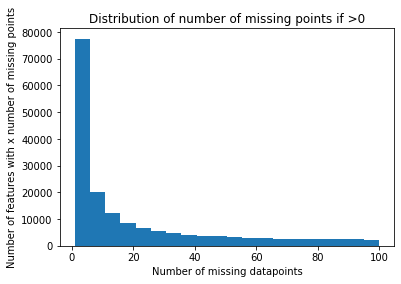

In [42]:
plt.hist(nummissing2[nummissing2!=0], bins=20)
plt.xlabel('Number of missing datapoints')
plt.ylabel('Number of features with x number of missing points')
plt.title('Distribution of number of missing points if >0')
plt.show()

In [136]:
3554002/(365632-192024) #avg number of missing values per column with missing data

20.47141836781715

In [144]:
df_all.shape[1]-df_dropsome.shape[1]

119610

In [45]:
len(nummissing2[nummissing2!=0])/df_dropsome.shape[1]

0.47481620864694557

In [181]:
X = df_dropsome.iloc[:, 5:]
y = df_dropsome.age

In [41]:
X

cg02494853  cg03706273  cg04023335  cg05213048  cg15295597  \
sample_GSM1069224       0.014       0.011       0.158       0.718       0.016   
sample_GSM1069230       0.021       0.098       0.142       0.851       0.041   
sample_GSM1069231       0.031       0.078       0.133       0.608       0.034   
sample_GSM1069233       0.032       0.057       0.502       0.829       0.043   
sample_GSM1069234       0.013       0.047       0.208       0.576       0.023   
sample_GSM1069236       0.013       0.021       0.397       0.735       0.028   
sample_GSM1069238       0.043       0.032       0.121       0.847       0.052   
sample_GSM1069241       0.013       0.017       0.477       0.715       0.017   
sample_GSM1069242       0.026       0.050       0.112       0.624       0.054   
sample_GSM1069248       0.025       0.025       0.425       0.669       0.042   
sample_GSM1069250       0.022       0.011       0.581       0.665       0.023   
sample_GSM1069253       0.014       0.036       0.154       0.655       0.022   
sample_GSM1069255       0.025       0.014       0.547       0.832       0.024   
sample_GSM1069259       0.029       0.030       0.541       0.765       0.053   
sample_GSM1069260       0.044       0.041       0.117       0.532       0.039   
sample_GSM1069266       0.033       0.052       0.484       0.709       0.039   
sample_GSM1069268       0.024       0.059       0.159       0.617       0.033   
sample_GSM1069272       0.048       0.096       0.141       0.528       0.091   
sample_GSM1069273       0.017       0.030       0.443       0.688       0.022   
sample_GSM1069274       0.042       0.037       0.143       0.616       0.043   
sample_GSM1069275       0.023       0.028       0.102       0.381       0.024   
sample_GSM1069279       0.023       0.029       0.732       0.892       0.032   
sample_GSM1069281       0.026       0.029       0.577       0.938       0.029   
sample_GSM1069285       0.049       0.036       0.593       0.692       0.041   
sample_GSM1069287       0.026       0.030       0.172       0.771       0.032   
sample_GSM1069291       0.020       0.036       0.168       0.524       0.019   
sample_GSM1069292       0.020       0.025       0.108       0.735       0.021   
sample_GSM1069295       0.029       0.025       0.399       0.752       0.032   
sample_GSM1069297       0.027       0.029       0.127       0.566       0.024   
sample_GSM1069301       0.028       0.021       0.077       0.549       0.031   
...                       ...         ...         ...         ...         ...   
sample_GSM1343504       0.055       0.077       0.109       0.580       0.071   
sample_GSM1343505       0.023       0.027       0.620       0.879       0.038   
sample_GSM1343506       0.023       0.030       0.135       0.636       0.028   
sample_GSM1343507       0.014       0.031       0.623       0.812       0.035   
sample_GSM1343508       0.020       0.022       0.085       0.503       0.030   
sample_GSM1343509       0.022       0.044       0.153       0.636       0.027   
sample_GSM1343510       0.019       0.032       0.680       0.856       0.022   
sample_GSM1343511       0.016       0.015       0.730       0.848       0.013   
sample_GSM1343512       0.030       0.031       0.724       0.872       0.031   
sample_GSM1343513       0.042       0.072       0.141       0.724       0.049   
sample_GSM1343514       0.024       0.031       0.652       0.809       0.028   
sample_GSM1343515       0.038       0.032       0.824       0.930       0.030   
sample_GSM1343516       0.028       0.028       0.682       0.907       0.042   
sample_GSM1343517       0.032       0.029       0.604       0.833       0.021   
sample_GSM1343518       0.016       0.028       0.730       0.919       0.022   
sample_GSM1343519       0.031       0.069       0.125       0.582       0.055   
sample_GSM1343520       0.046       0.061       0.646       0.799       0.057   
sample_GSM1343521       0.022       0.022       0.

In [182]:
imp = SimpleImputer(missing_values = np.nan, strategy='mean')
X_im_mean = pd.DataFrame(imp.fit_transform(X))

In [183]:
X_im_mean.index = X.index
X_im_mean.columns = X.columns

In [100]:
X_im_mean.isna().sum().sum()

0

In [184]:
im_mean_data = pd.concat([y, X_im_mean], axis=1)

In [185]:
np.random.seed(2021)
saved_index = np.random.choice(np.arange(1000), size=300, replace=False)
keep_index = []
for num in range(1000):
    if num not in saved_index:
        keep_index.append(num)

imp_mean_saved = im_mean_data.iloc[saved_index, :]
imp_mean_working = im_mean_data.iloc[keep_index, :]

In [186]:
Ximmean = imp_mean_working.iloc[:,1:]
yimmean = imp_mean_working.age

In [187]:
X_train, X_test, y_train, y_test = train_test_split(Ximmean, yimmean, test_size=0.20, random_state = 2021)

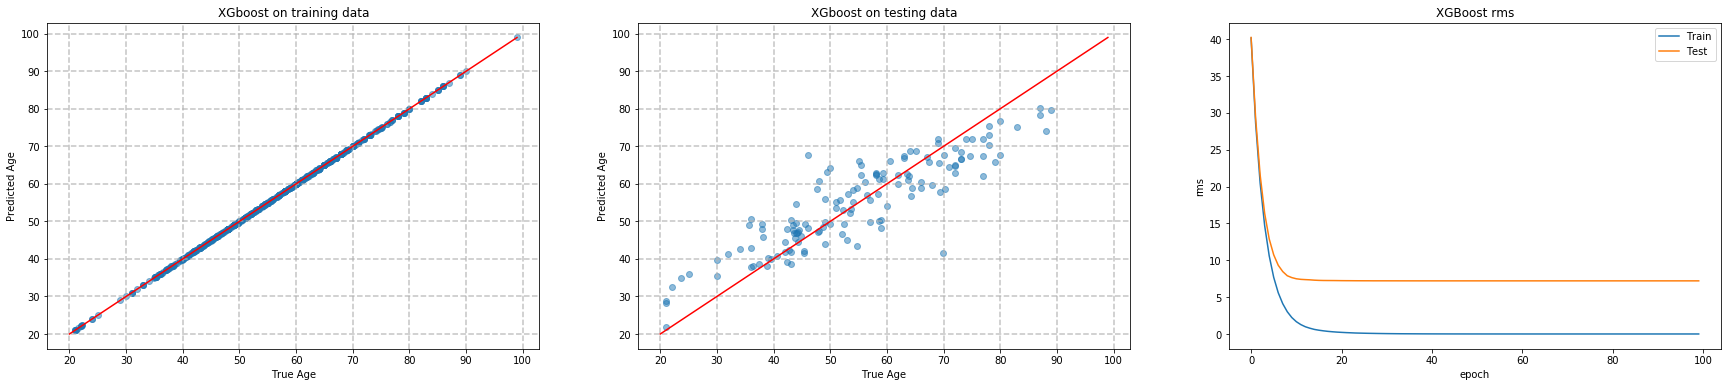

The number of training epochs was 100
The rms on the training data is 0.000 years
The rms on the testing data is 7.208 years
The r^2 on the training data is 1.000
The r^2 on the testing data is 0.779
Wall time: 15min 8s


In [188]:
%%time
XG, rms_train_xg, rms_test_xg, r2_train_xg, r2_test_xg, feature_importances_xg = xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=None, plot=True)

In [189]:
df_importance  = pd.DataFrame({'CpG':imp_mean_working.columns[1:], 'Importance Score':feature_importances_xg})
df_importance_sorted  = df_importance.sort_values('Importance Score', ascending=False)
df_importance_sorted.head(20)

CpG  Importance Score
93164   cg04875128          0.227347
96604   cg00614832          0.101295
30302   cg04181121          0.088696
46179   cg16867657          0.059028
72453   cg05093315          0.057216
98490   cg04208403          0.054312
322700  cg18473521          0.046600
144909  cg09809672          0.040014
251045  cg08097417          0.036811
254773  cg14361627          0.018114
21936   cg22454769          0.016415
94667   cg16439512          0.014260
322771  cg18633600          0.011866
44269   cg10963893          0.010752
93746   cg09395572          0.009374
107754  cg15883181          0.008731
114845  cg06579024          0.007176
5654    cg06784991          0.006304
356681  cg04147875          0.006216
222634  cg26473844          0.005921

In [190]:
len(set(df_importance_sorted['CpG'][:100]).intersection(df_importance_sorted2['CpG'][:100]))

16

In [191]:
df_100 = imp_mean_working[df_importance_sorted['CpG'][:100]]
df_100

cg04875128  cg00614832  cg04181121  cg16867657  cg05093315  \
sample_GSM1069224       0.315       0.215       0.827       0.766       0.590   
sample_GSM1069233       0.300       0.200       0.817       0.771       0.645   
sample_GSM1069234       0.318       0.220       0.881       0.792       0.728   
sample_GSM1069236       0.339       0.195       0.785       0.672       0.579   
sample_GSM1069241       0.375       0.204       0.817       0.731       0.587   
sample_GSM1069250       0.371       0.246       0.800       0.677       0.545   
sample_GSM1069253       0.404       0.199       0.841       0.819       0.624   
sample_GSM1069255       0.378       0.220       0.835       0.790       0.548   
sample_GSM1069259       0.374       0.170       0.786       0.749       0.585   
sample_GSM1069260       0.301       0.173       0.810       0.745       0.644   
sample_GSM1069266       0.401       0.202       0.766       0.743       0.655   
sample_GSM1069272       0.386       0.205       0.762       0.735       0.662   
sample_GSM1069273       0.386       0.182       0.809       0.734       0.551   
sample_GSM1069274       0.400       0.178       0.848       0.756       0.649   
sample_GSM1069275       0.375       0.234       0.816       0.787       0.620   
sample_GSM1069281       0.388       0.223       0.826       0.815       0.576   
sample_GSM1069285       0.507       0.225       0.815       0.750       0.626   
sample_GSM1069287       0.403       0.224       0.779       0.732       0.522   
sample_GSM1069291       0.335       0.181       0.804       0.701       0.618   
sample_GSM1069292       0.378       0.195       0.811       0.749       0.546   
sample_GSM1069295       0.410       0.191       0.806       0.736       0.538   
sample_GSM1069301       0.419       0.191       0.818       0.741       0.645   
sample_GSM1069307       0.271       0.196       0.805       0.703       0.602   
sample_GSM1069313       0.290       0.197       0.819       0.712       0.476   
sample_GSM1179498       0.400       0.136       0.757       0.656       0.690   
sample_GSM1179500       0.140       0.148       0.762       0.715       0.686   
sample_GSM1179533       0.182       0.150       0.853       0.537       0.696   
sample_GSM1179534       0.072       0.175       0.813       0.435       0.780   
sample_GSM1179537       0.084       0.153       0.869       0.478       0.746   
sample_GSM1259870       0.066       0.020       0.795       0.634       0.617   
...                       ...         ...         ...         ...         ...   
sample_GSM1343480       0.167       0.117       0.856       0.651       0.728   
sample_GSM1343484       0.126       0.113       0.858       0.609       0.660   
sample_GSM1343485       0.304       0.109       0.836       0.754       0.665   
sample_GSM1343488       0.216       0.128       0.855       0.706       0.586   
sample_GSM1343490       0.132       0.118       0.845       0.640       0.704   
sample_GSM1343491       0.279       0.131       0.815       0.707       0.638   
sample_GSM1343493       0.166       0.116       0.833       0.610       0.648   
sample_GSM1343498       0.059       0.130       0.835       0.546       0.727   
sample_GSM1343499       0.097       0.138       0.841       0.576       0.749   
sample_GSM1343500       0.174       0.125       0.866       0.646       0.760   
sample_GSM1343501       0.182       0.132       0.852       0.632       0.761   
sample_GSM1343505       0.163       0.124       0.860       0.693       0.653   
sample_GSM1343506       0.147       0.137       0.877       0.690       0.689   
sample_GSM1343507       0.141       0.120       0.826       0.619       0.736   
sample_GSM1343508       0.118       0.125       0.811       0.624       0.685   
sample_GSM1343509       0.320       0.109       0.822       0.709       0.759   
sample_GSM1343512       0.224       0.118       0.810       0.611       0.732   
sample_GSM1343513       0.259       0.113       0.

In [192]:
X = df_100
y = imp_mean_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2023)

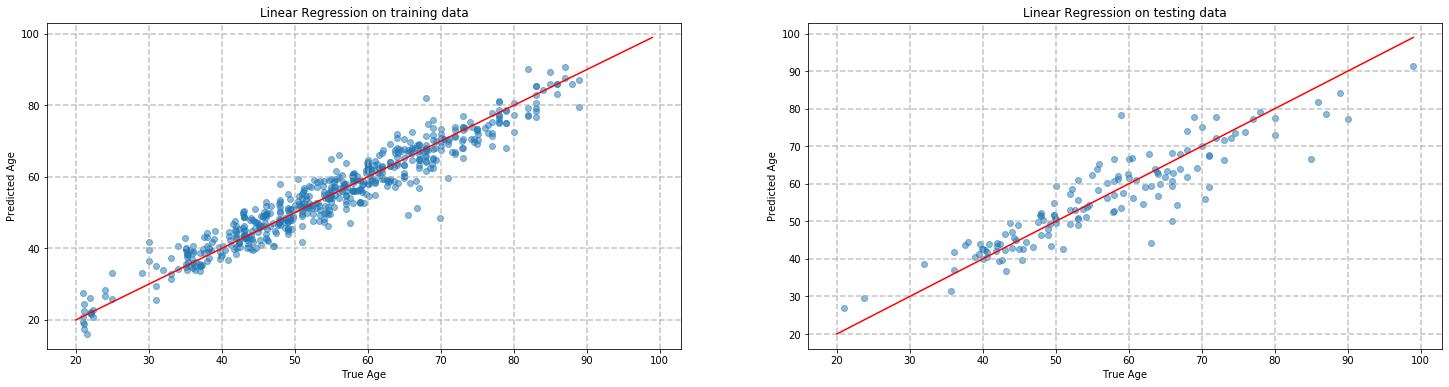

The rms on the training data is 3.885 years
The rms on the testing data is 5.562 years
The r^2 on the training data is 0.926
The r^2 on the testing data is 0.834


In [193]:
mod_lg2, rms_train_lg2, rms_test_lg2, r2_train_lg2, r2_test_lg2 = linear_regress(X_train, y_train, X_test, y_test, plot=True)

In [194]:
imp_mean_saved_100 = imp_mean_saved[df_importance_sorted['CpG'][:100]]

In [195]:
X_saved_100 = imp_mean_saved_100
y_saved_100 = imp_mean_saved.age

In [196]:
preds_on_saved2 = mod_lg2.predict(X_saved_100)
rms_test_s2 = (mean_squared_error(y_saved_100, preds_on_saved2))**0.5
r2_test_s2 = r2_score(y_saved_100, preds_on_saved2)

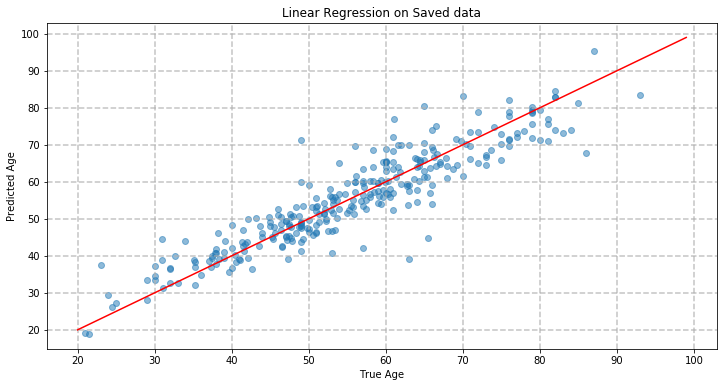

The rms on the saved data is 5.529 years
The r^2 on the saved data is 0.841


In [197]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(y_saved_100, preds_on_saved2, alpha=0.5)
ax.plot(range(20,100), range(20,100), c='red')
ax.set_xlabel('True Age')
ax.set_ylabel('Predicted Age')
ax.grid(True, lw=1.5, ls='--', alpha=0.75)
ax.set_title('Linear Regression on Saved data')
plt.show()

# print metric
print(f'The rms on the saved data is {rms_test_s2:.3f} years')
print(f'The r^2 on the saved data is {r2_test_s2:.3f}')

In [78]:
imp = SimpleImputer(strategy='mean')
X_im_mean_all = pd.DataFrame(imp.fit_transform(X))

MemoryError: Unable to allocate 3.62 GiB for an array with shape (1000, 485237) and data type float64

In [ ]:
X_im_mean_all.index = X.index
X_im_mean_all.columns = X.columns

In [47]:
im_mean_all_data = pd.concat([y, X_im_mean_all], axis=1)

In [48]:
np.random.seed(2021)
saved_index = np.random.choice(np.arange(1000), size=300, replace=False)
keep_index = []
for num in range(1000):
    if num not in saved_index:
        keep_index.append(num)

imp_mean_all_saved = im_mean_all_data.iloc[saved_index, :]
imp_mean_all_working = im_mean_all_data.iloc[keep_index, :]

In [49]:
Ximmeanall = imp_mean_all_working.iloc[:,1:]
yimmeanall = imp_mean_all_working.age

In [52]:
X_train, X_test, y_train, y_test = train_test_split(Ximmeanall, yimmeanall, test_size=0.20, random_state = 2021)

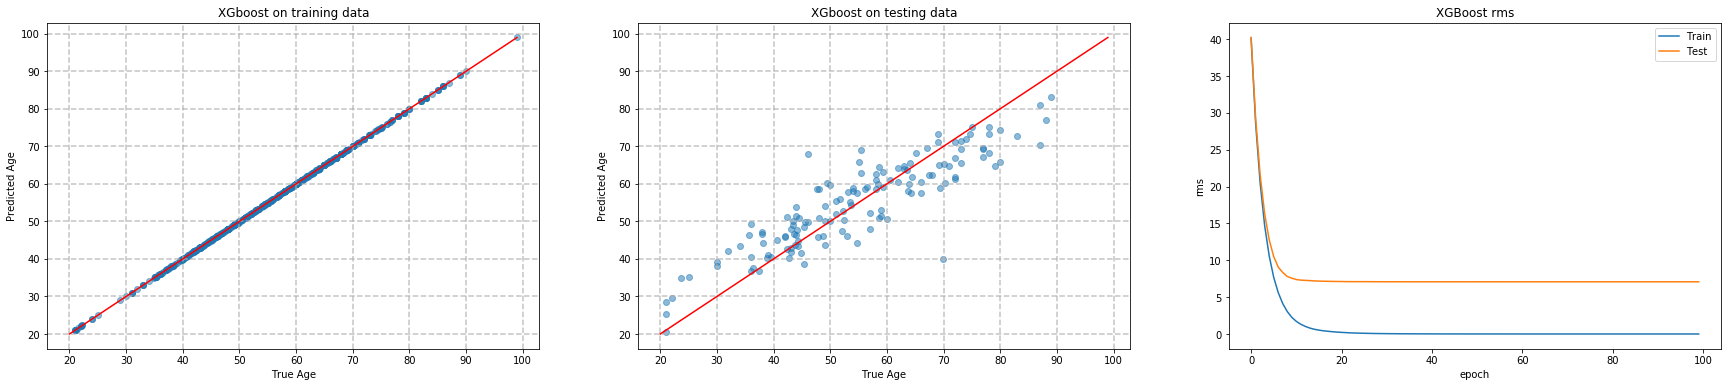

The number of training epochs was 100
The rms on the training data is 0.000 years
The rms on the testing data is 7.081 years
The r^2 on the training data is 1.000
The r^2 on the testing data is 0.787
Wall time: 15min 28s


In [53]:
%%time
XG, rms_train_xg, rms_test_xg, r2_train_xg, r2_test_xg, feature_importances_xg = xgboost_regress(X_train, y_train, X_test, y_test, early_stopping_rounds=None, plot=True)

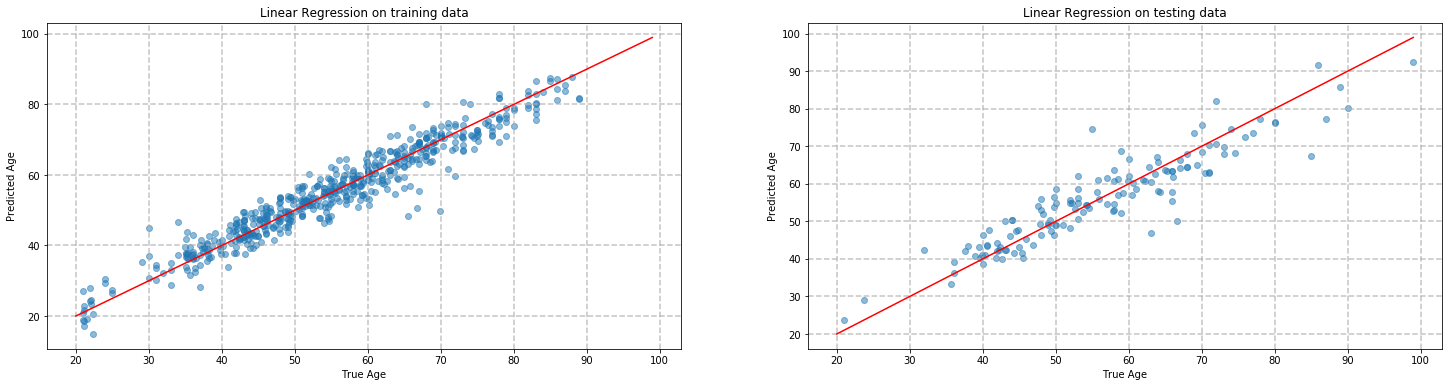

The rms on the training data is 3.848 years
The rms on the testing data is 5.211 years
The r^2 on the training data is 0.927
The r^2 on the testing data is 0.854


In [55]:
df_importance  = pd.DataFrame({'CpG':imp_mean_all_working.columns[1:], 'Importance Score':feature_importances_xg})
df_importance_sorted  = df_importance.sort_values('Importance Score', ascending=False)
df_100 = imp_mean_all_working[df_importance_sorted['CpG'][:100]]
X = df_100
y = imp_mean_all_working.age
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 2023)
mod_lg2, rms_train_lg2, rms_test_lg2, r2_train_lg2, r2_test_lg2 = linear_regress(X_train, y_train, X_test, y_test, plot=True)

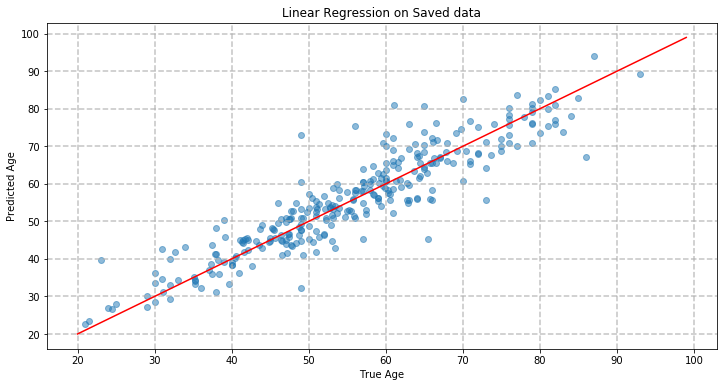

The rms on the saved data is 5.640 years
The r^2 on the saved data is 0.835


In [56]:
imp_mean_all_saved_100 = imp_mean_all_saved[df_importance_sorted['CpG'][:100]]
X_all_saved_100 = imp_mean_all_saved_100
y_all_saved_100 = imp_mean_all_saved.age
preds_on_saved2 = mod_lg2.predict(X_all_saved_100)
rms_test_s2 = (mean_squared_error(y_all_saved_100, preds_on_saved2))**0.5
r2_test_s2 = r2_score(y_all_saved_100, preds_on_saved2)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(y_all_saved_100, preds_on_saved2, alpha=0.5)
ax.plot(range(20,100), range(20,100), c='red')
ax.set_xlabel('True Age')
ax.set_ylabel('Predicted Age')
ax.grid(True, lw=1.5, ls='--', alpha=0.75)
ax.set_title('Linear Regression on Saved data')
plt.show()

# print metric
print(f'The rms on the saved data is {rms_test_s2:.3f} years')
print(f'The r^2 on the saved data is {r2_test_s2:.3f}')

In [68]:
from sklearn.svm import SVR
svr = SVR(verbose=1)
svr.fit(X_train, y_train)

[LibSVM]

SVR(verbose=1)

In [71]:
svrtrainpreds = svr.predict(X_train)
svrtestpreds = svr.predict(X_test)

In [73]:
r2_score(y_train, svrtrainpreds)

0.29797188967398436

In [86]:
newdf = df_all[df_importance_sorted['CpG'][:100]]
y = df_all.age

In [77]:
nummissing3 = len(newdf.index)-newdf.count()

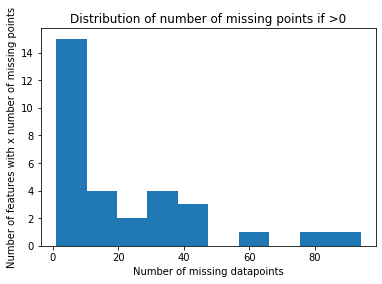

In [80]:
plt.hist(nummissing3[nummissing3!=0])
plt.xlabel('Number of missing datapoints')
plt.ylabel('Number of features with x number of missing points')
plt.title('Distribution of number of missing points if >0')
plt.show()

In [82]:
len(nummissing3[nummissing3!=0])/100

0.31

In [84]:
newdf.isna().sum().sum()/31

20.193548387096776

In [113]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor


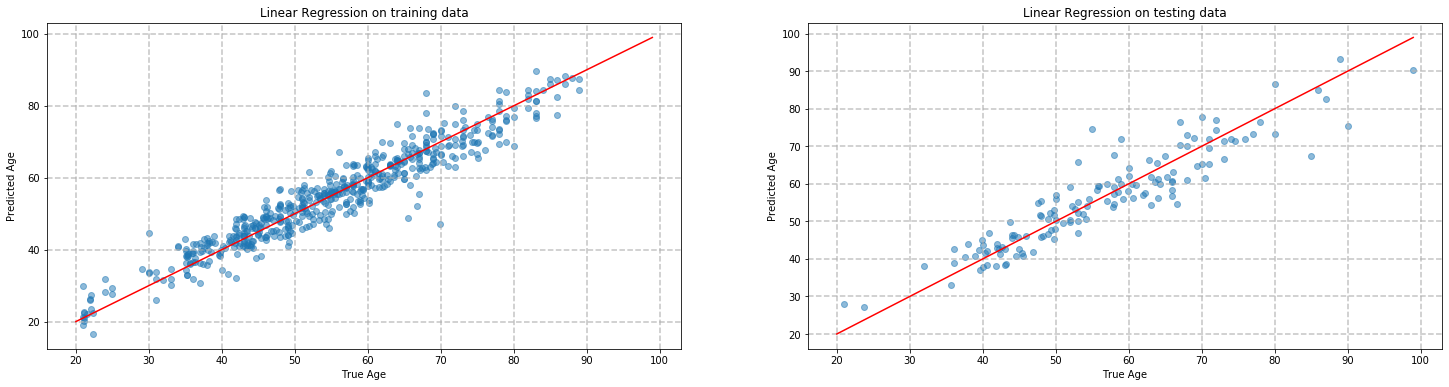

The rms on the training data is 4.155 years
The rms on the testing data is 5.169 years
The r^2 on the training data is 0.915
The r^2 on the testing data is 0.857


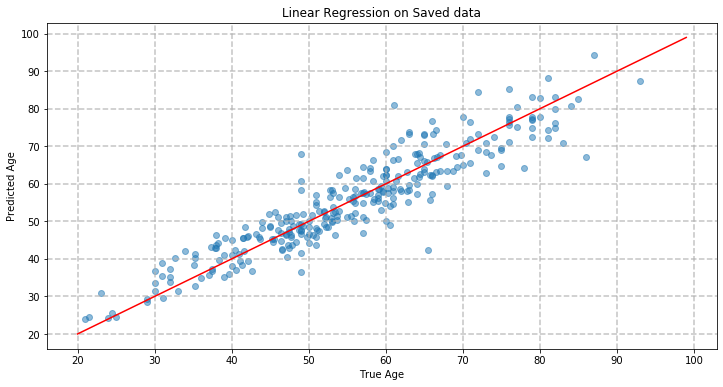

The rms on the saved data is 5.293 years
The r^2 on the saved data is 0.854


In [114]:
imp = IterativeImputer(estimator = BayesianRidge(), max_iter=10, verbose=0, random_state=123)
X_im_ridge = pd.DataFrame(imp.fit_transform(newdf))

X_im_ridge.index = newdf.index
X_im_ridge.columns = newdf.columns

im_ridge_data = pd.concat([y, X_im_ridge], axis=1)

np.random.seed(2021)
saved_index = np.random.choice(np.arange(1000), size=300, replace=False)
keep_index = []
for num in range(1000):
    if num not in saved_index:
        keep_index.append(num)

imp_ridge_saved = im_ridge_data.iloc[saved_index, :]
imp_ridge_working = im_ridge_data.iloc[keep_index, :]

X_train, X_test, y_train, y_test = train_test_split(imp_ridge_working.iloc[:,1:], imp_ridge_working.age, test_size=0.20, random_state = 2023)

mod_lg2, rms_train_lg2, rms_test_lg2, r2_train_lg2, r2_test_lg2 = linear_regress(X_train, y_train, X_test, y_test, plot=True)

X_saved = imp_ridge_saved.iloc[:,1:]
y_saved = imp_ridge_saved.age

preds_on_saved2 = mod_lg2.predict(X_saved)
rms_test_s2 = (mean_squared_error(y_saved, preds_on_saved2))**0.5
r2_test_s2 = r2_score(y_saved, preds_on_saved2)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(y_saved, preds_on_saved2, alpha=0.5)
ax.plot(range(20,100), range(20,100), c='red')
ax.set_xlabel('True Age')
ax.set_ylabel('Predicted Age')
ax.grid(True, lw=1.5, ls='--', alpha=0.75)
ax.set_title('Linear Regression on Saved data')
plt.show()

# print metric
print(f'The rms on the saved data is {rms_test_s2:.3f} years')
print(f'The r^2 on the saved data is {r2_test_s2:.3f}')

C:\Users\aaron\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


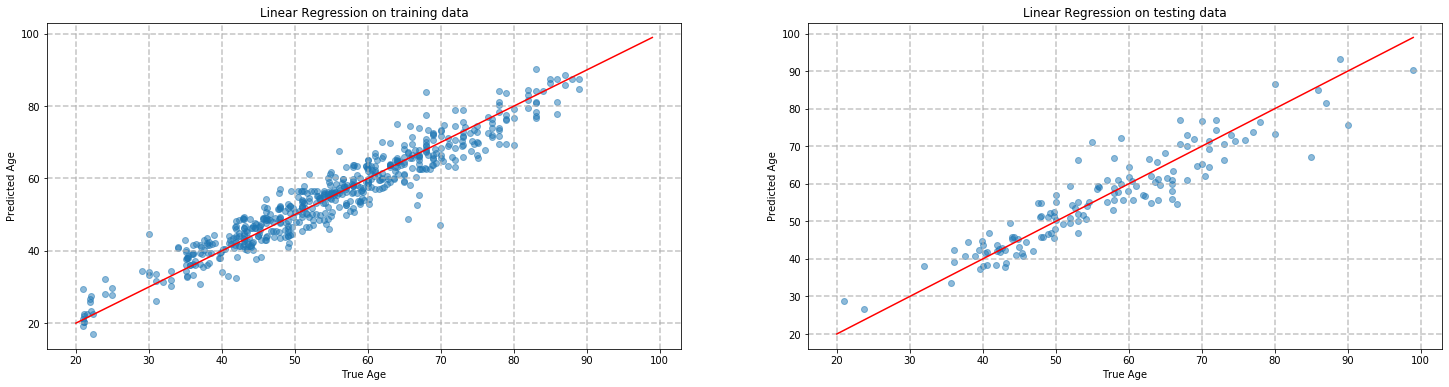

The rms on the training data is 4.151 years
The rms on the testing data is 5.113 years
The r^2 on the training data is 0.915
The r^2 on the testing data is 0.860


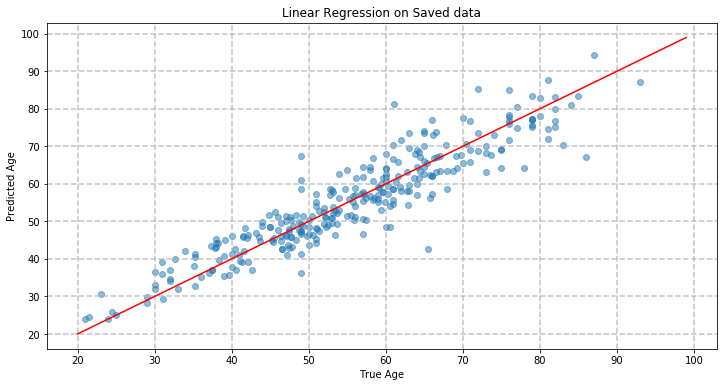

The rms on the saved data is 5.308 years
The r^2 on the saved data is 0.853


In [117]:
imp = IterativeImputer(estimator = DecisionTreeRegressor(random_state=123), max_iter=10, verbose=0, random_state=123)
X_im_ridge = pd.DataFrame(imp.fit_transform(newdf))

X_im_ridge.index = newdf.index
X_im_ridge.columns = newdf.columns

im_ridge_data = pd.concat([y, X_im_ridge], axis=1)

np.random.seed(2021)
saved_index = np.random.choice(np.arange(1000), size=300, replace=False)
keep_index = []
for num in range(1000):
    if num not in saved_index:
        keep_index.append(num)

imp_ridge_saved = im_ridge_data.iloc[saved_index, :]
imp_ridge_working = im_ridge_data.iloc[keep_index, :]

X_train, X_test, y_train, y_test = train_test_split(imp_ridge_working.iloc[:,1:], imp_ridge_working.age, test_size=0.20, random_state = 2023)

mod_lg2, rms_train_lg2, rms_test_lg2, r2_train_lg2, r2_test_lg2 = linear_regress(X_train, y_train, X_test, y_test, plot=True)

X_saved = imp_ridge_saved.iloc[:,1:]
y_saved = imp_ridge_saved.age

preds_on_saved2 = mod_lg2.predict(X_saved)
rms_test_s2 = (mean_squared_error(y_saved, preds_on_saved2))**0.5
r2_test_s2 = r2_score(y_saved, preds_on_saved2)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(y_saved, preds_on_saved2, alpha=0.5)
ax.plot(range(20,100), range(20,100), c='red')
ax.set_xlabel('True Age')
ax.set_ylabel('Predicted Age')
ax.grid(True, lw=1.5, ls='--', alpha=0.75)
ax.set_title('Linear Regression on Saved data')
plt.show()

# print metric
print(f'The rms on the saved data is {rms_test_s2:.3f} years')
print(f'The r^2 on the saved data is {r2_test_s2:.3f}')

[IterativeImputer] Completing matrix with shape (1000, 100)
[IterativeImputer] Ending imputation round 1/10, elapsed time 17.05
[IterativeImputer] Change: 0.8189064282311135, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 2/10, elapsed time 36.87
[IterativeImputer] Change: 0.38779999999999953, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 3/10, elapsed time 55.21
[IterativeImputer] Change: 0.4127000000000004, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 4/10, elapsed time 76.26
[IterativeImputer] Change: 0.4787000000000001, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 5/10, elapsed time 96.93
[IterativeImputer] Change: 0.48019999999999974, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 6/10, elapsed time 113.63
[IterativeImputer] Change: 0.3936999999999998, scaled tolerance: 0.001 
[IterativeImputer] Ending imputation round 7/10, elapsed time 130.28
[IterativeImputer] Change: 0

C:\Users\aaron\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


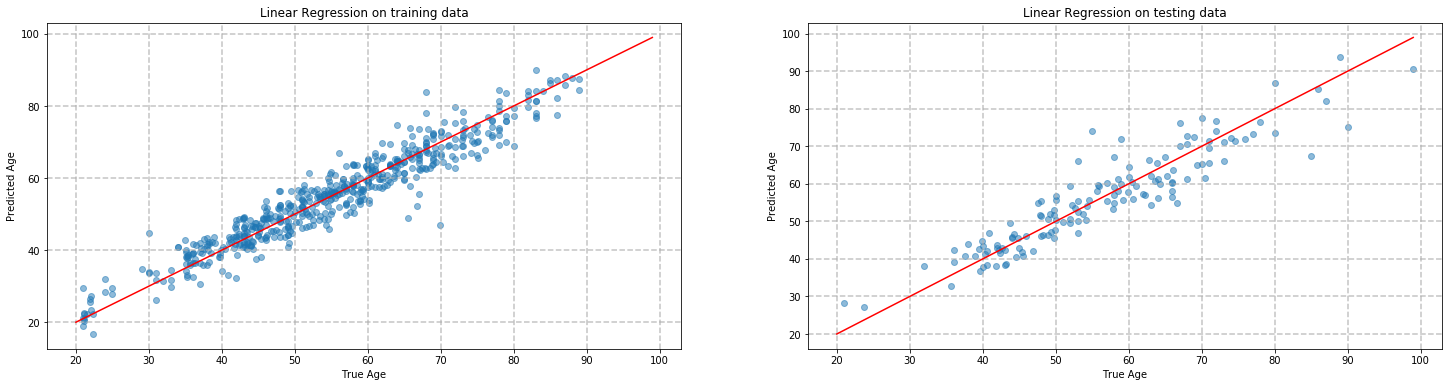

The rms on the training data is 4.148 years
The rms on the testing data is 5.154 years
The r^2 on the training data is 0.915
The r^2 on the testing data is 0.857


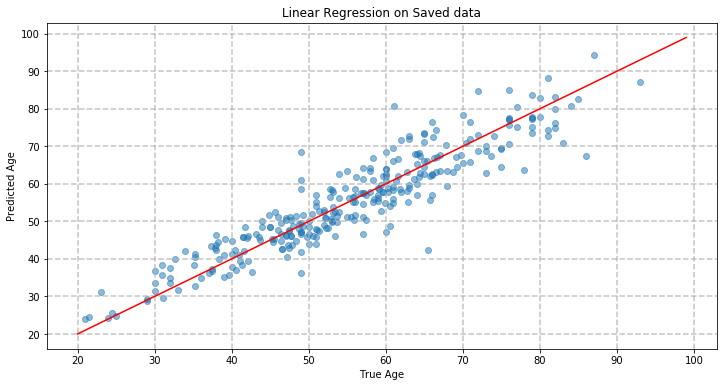

The rms on the saved data is 5.326 years
The r^2 on the saved data is 0.852


In [125]:
imp = IterativeImputer(estimator = ExtraTreesRegressor(n_estimators=10, random_state=123), max_iter=10, verbose=2, random_state=123)
X_im_ridge = pd.DataFrame(imp.fit_transform(newdf))

X_im_ridge.index = newdf.index
X_im_ridge.columns = newdf.columns

im_ridge_data = pd.concat([y, X_im_ridge], axis=1)

np.random.seed(2021)
saved_index = np.random.choice(np.arange(1000), size=300, replace=False)
keep_index = []
for num in range(1000):
    if num not in saved_index:
        keep_index.append(num)

imp_ridge_saved = im_ridge_data.iloc[saved_index, :]
imp_ridge_working = im_ridge_data.iloc[keep_index, :]

X_train, X_test, y_train, y_test = train_test_split(imp_ridge_working.iloc[:,1:], imp_ridge_working.age, test_size=0.20, random_state = 2023)

mod_lg2, rms_train_lg2, rms_test_lg2, r2_train_lg2, r2_test_lg2 = linear_regress(X_train, y_train, X_test, y_test, plot=True)

X_saved = imp_ridge_saved.iloc[:,1:]
y_saved = imp_ridge_saved.age

preds_on_saved2 = mod_lg2.predict(X_saved)
rms_test_s2 = (mean_squared_error(y_saved, preds_on_saved2))**0.5
r2_test_s2 = r2_score(y_saved, preds_on_saved2)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(y_saved, preds_on_saved2, alpha=0.5)
ax.plot(range(20,100), range(20,100), c='red')
ax.set_xlabel('True Age')
ax.set_ylabel('Predicted Age')
ax.grid(True, lw=1.5, ls='--', alpha=0.75)
ax.set_title('Linear Regression on Saved data')
plt.show()

# print metric
print(f'The rms on the saved data is {rms_test_s2:.3f} years')
print(f'The r^2 on the saved data is {r2_test_s2:.3f}')

C:\Users\aaron\Anaconda3\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


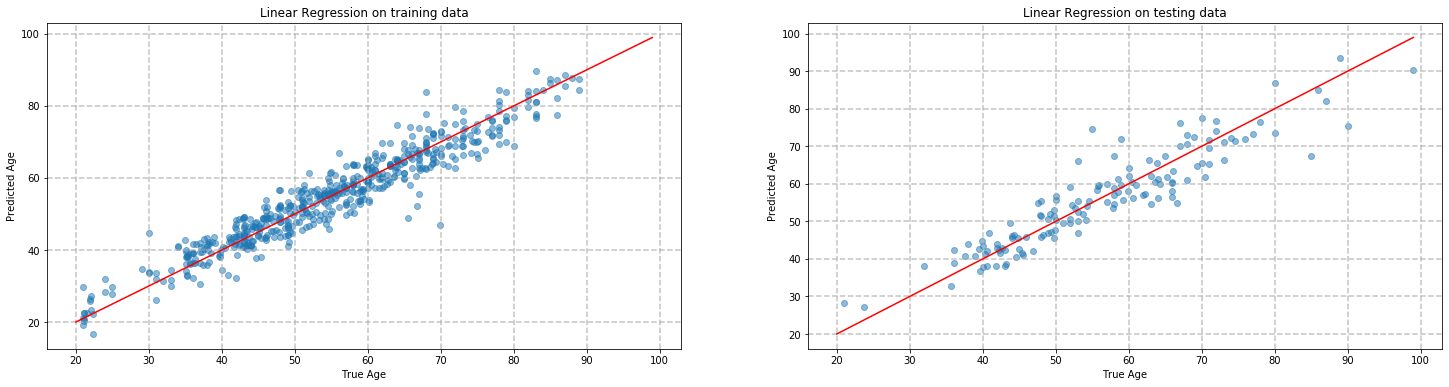

The rms on the training data is 4.149 years
The rms on the testing data is 5.165 years
The r^2 on the training data is 0.915
The r^2 on the testing data is 0.857


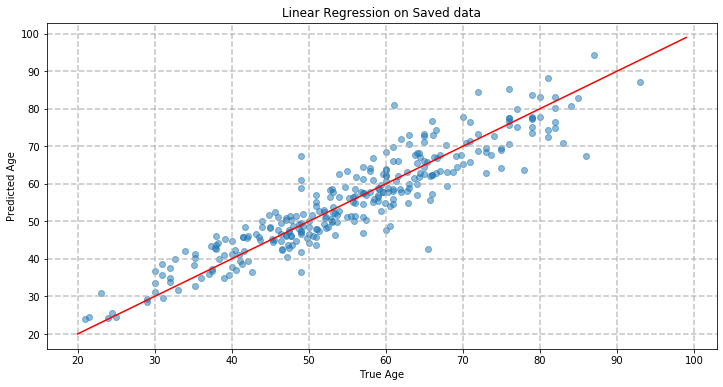

The rms on the saved data is 5.301 years
The r^2 on the saved data is 0.854


In [124]:
imp = IterativeImputer(estimator = KNeighborsRegressor(n_neighbors=15), max_iter=10, verbose=0, random_state=123)
X_im_ridge = pd.DataFrame(imp.fit_transform(newdf))

X_im_ridge.index = newdf.index
X_im_ridge.columns = newdf.columns

im_ridge_data = pd.concat([y, X_im_ridge], axis=1)

np.random.seed(2021)
saved_index = np.random.choice(np.arange(1000), size=300, replace=False)
keep_index = []
for num in range(1000):
    if num not in saved_index:
        keep_index.append(num)

imp_ridge_saved = im_ridge_data.iloc[saved_index, :]
imp_ridge_working = im_ridge_data.iloc[keep_index, :]

X_train, X_test, y_train, y_test = train_test_split(imp_ridge_working.iloc[:,1:], imp_ridge_working.age, test_size=0.20, random_state = 2023)

mod_lg2, rms_train_lg2, rms_test_lg2, r2_train_lg2, r2_test_lg2 = linear_regress(X_train, y_train, X_test, y_test, plot=True)

X_saved = imp_ridge_saved.iloc[:,1:]
y_saved = imp_ridge_saved.age

preds_on_saved2 = mod_lg2.predict(X_saved)
rms_test_s2 = (mean_squared_error(y_saved, preds_on_saved2))**0.5
r2_test_s2 = r2_score(y_saved, preds_on_saved2)
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.scatter(y_saved, preds_on_saved2, alpha=0.5)
ax.plot(range(20,100), range(20,100), c='red')
ax.set_xlabel('True Age')
ax.set_ylabel('Predicted Age')
ax.grid(True, lw=1.5, ls='--', alpha=0.75)
ax.set_title('Linear Regression on Saved data')
plt.show()

# print metric
print(f'The rms on the saved data is {rms_test_s2:.3f} years')
print(f'The r^2 on the saved data is {r2_test_s2:.3f}')

In [129]:
%%time
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
imp = IterativeImputer(estimator = BayesianRidge(), max_iter=5, n_nearest_features = None, verbose=2, random_state=123)
X_im_ridge = pd.DataFrame(imp.fit_transform(X))

[IterativeImputer] Completing matrix with shape (1000, 365627)


KeyboardInterrupt: 

In [36]:
from deepimpute.multinet import MultiNet


In [37]:
%%time
model = MultiNet()
model.fit(df_all.iloc[:,-1000:])

Using all the cores (8)
Input dataset is 1000 cells (rows) and 1000 genes (columns)
First 3 rows and columns:
                   cg22031629  cg22031736  cg22033362
sample_GSM1069224       0.008       0.014       0.294
sample_GSM1069230       0.018       0.020       0.249
sample_GSM1069231       0.022       0.016       0.287
512 genes selected for imputation
Net 0: 174 predictors, 512 targets
Normalization
Building network
[{'type': 'dense', 'neurons': 256, 'activation': 'relu'}, {'type': 'dropout', 'rate': 0.2}]
Fitting with 1000 cells
Train on 950 samples, validate on 50 samples
Epoch 1/500
 64/950 [=>............................] - ETA: 0s - loss: nanWARNING:tensorflow:From C:\Users\aaron\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, a

C:\Users\aaron\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\callbacks.py:1664: RuntimeWarning: invalid value encountered in less
  if self.monitor_op(current - self.min_delta, self.best):


950/950 [==============================] - 0s 90us/sample - loss: nan - val_loss: nan
Epoch 2/500
950/950 [==============================] - ETA: 0s - loss: n - 0s 41us/sample - loss: nan - val_loss: nan
Epoch 3/500
950/950 [==============================] - ETA: 0s - loss: n - 0s 43us/sample - loss: nan - val_loss: nan
Epoch 4/500
950/950 [==============================] - ETA: 0s - loss: n - 0s 43us/sample - loss: nan - val_loss: nan
Epoch 5/500
950/950 [==============================] - ETA: 0s - loss: n - 0s 39us/sample - loss: nan - val_loss: nan
Stopped fitting after 5 epochs
Saved model to disk


C:\Users\aaron\Anaconda3\lib\site-packages\deepimpute\multinet.py:248: RuntimeWarning: invalid value encountered in greater
  Y_test_imputed = Y_test_imputed[Y_test_raw>0]
C:\Users\aaron\Anaconda3\lib\site-packages\deepimpute\multinet.py:249: RuntimeWarning: invalid value encountered in greater
  Y_test_raw = Y_test_raw[Y_test_raw>0]


ValueError: array must not contain infs or NaNs

In [20]:

import os
import tensorflow as tf
import pandas as pd
import time
from autoencoder import *
import sys
import random


def get_next_batch(dataset, batch_size,step,ind):

    start=step*batch_size
    end=((step+1)*batch_size)
    sel_ind=ind[start:end]
    newdataset=dataset.iloc[sel_ind,:]
  
    return newdataset

    
def calculate_nrmse_loss(reconstructed,input_shape):
    
    tf.compat.v1.disable_eager_execution()


    original = tf.compat.v1.placeholder(tf.float32,
                                 input_shape,
                                 name='original')
    missing_mask=tf.compat.v1.placeholder(tf.float32,
                                 input_shape,
                                 name='original')
   
    reconstructed_masked_value=tf.multiply(reconstructed, missing_mask)
    original_maksed_value=tf.multiply(original, missing_mask)
    rmse= tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(reconstructed_masked_value,
                                                 original_maksed_value)),axis=0)))
  
    return original, rmse, missing_mask




def train(nonmissing_perc,dataset_train,dataset_test,autoencoder_fun, restore=False,sav=True,checkpoint_file='default.ckpt'):
    input_image, reconstructed_image = autoencoder_fun(batch_shape)
    original, loss, missing_mask = calculate_nrmse_loss(reconstructed_image,[batch_size,feature_size])
    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(loss)

    init = tf.compat.v1.global_variables_initializer()
    saver=tf.compat.v1.train.Saver()
    start=time.time()
    loss_val_list_train=0
    loss_val_list_test=0
    with tf.compat.v1.Session() as session:
        
            session.run(init)
            dataset_size_train = dataset_train.shape[0]
            dataset_size_test = dataset_test.shape[0]
            print("Dataset size for training:", dataset_size_train)
            print("Dataset size for validation:", dataset_size_test)
            num_iters = (num_epochs * dataset_size_train)//batch_size
            print("Num iters:", num_iters)
            ind_train=0
            for i in range(num_epochs):
                ind_train= np.append(ind_train, np.random.permutation(np.arange(dataset_size_train)))
            ind_test=0
            iters=num_epochs*dataset_size_train//dataset_size_test+1
            for i in range(iters):
                ind_test= np.append(ind_test, np.random.permutation(np.arange(dataset_size_test)))
        
            for step in range(num_iters):
                temp = get_next_batch(dataset_train, batch_size,step,ind_train)
                train_batch=np.asarray(temp).astype("float32")
                frac=nonmissing_perc
                sample = np.random.binomial(1, frac, size=temp.shape[0]*temp.shape[1])
                sample2=sample.reshape(temp.shape[0],temp.shape[1])
                missing_ones=np.ones_like(sample2) - sample2
                corrupted=temp*sample2
                corrupted_batch=np.asarray(corrupted).astype("float32")       
                train_loss_val,_= session.run([loss,optimizer], 
                                   feed_dict={input_image: corrupted_batch, original:train_batch,missing_mask:missing_ones})              
                loss_val_list_train=np.append(loss_val_list_train,train_loss_val)
                
                
                
                temp = get_next_batch(dataset_test, batch_size,step, ind_test)
                test_batch=np.asarray(temp).astype("float32")
                frac=nonmissing_perc
                sample = np.random.binomial(1, frac, size=temp.shape[0]*temp.shape[1])
                sample2=sample.reshape(temp.shape[0],temp.shape[1])
                missing_ones=np.ones_like(sample2) - sample2
                corrupted=temp*sample2
                corrupted_batch=np.asarray(corrupted).astype("float32")  
                
                test_loss_val = session.run(loss, 
                                       feed_dict={input_image: corrupted_batch, original:test_batch,missing_mask:missing_ones })
                loss_val_list_test=np.append(loss_val_list_test,test_loss_val)
                
                if step%30==0:
                    print(step, "/", num_iters, train_loss_val,test_loss_val)             
            if sav:
                save_path = saver.save(session, checkpoint_file)
                print(("Model saved in file: %s" % save_path))
            
    end=time.time()
    el=end-start
    print(("Time elapsed %f" %el))
    return(loss_val_list_train, loss_val_list_test)

In [21]:
import tensorflow as tf

def fc(input, name, out_dim, non_linear_fn=None):
    assert(type(out_dim) == int)
    with tf.compat.v1.variable_scope(name) as scope:
        input_dims = input.get_shape().as_list()
        if len(input_dims) == 4:
            batch_size, input_h, input_w, num_channels = input_dims
            in_dim = input_h * input_w * num_channels
            flat_input = tf.reshape(input, [batch_size, in_dim])
        else:
            in_dim = input_dims[-1]
            batch_size=input_dims[0]
            flat_input = tf.reshape(input, [batch_size, in_dim])
        weights = tf.compat.v1.get_variable('weights', [in_dim, out_dim])
        biases = tf.compat.v1.get_variable('biases', [out_dim])
        out = tf.compat.v1.nn.xw_plus_b(flat_input, weights, biases)
        if non_linear_fn:
            return non_linear_fn(out, name=scope.name)
        else:
            return out

In [25]:
import tensorflow as tf


# Autoencoder structures need to be adpated according to data dimension.
# More or less layers could be used with different node size. 
# We used a three layer autoencoder with bottleneck layer size of 800 for the Pan-cancer RNA sequencing data.

def encoder4_d(input):
    fc_1 = fc(input, 'fc_1', 6896)
    fc_2 = fc(fc_1, 'fc_2', 2378)
    fc_3 = fc(fc_2, 'fc_3', 800)
    return fc_3
def decoder4_d(input):
    fc_dec1 = fc(input, 'fc_dec1', 2378)
    fc_dec2 = fc(fc_dec1, 'fc_dec2', 6896)
    fc_dec3 = fc(fc_dec2, 'fc_dec3',17176) #17176
    return fc_dec3
def autoencoder4_d(input_shape):
    tf.compat.v1.disable_eager_execution()

    input_image = tf.compat.v1.placeholder(tf.float32,
                                 input_shape,
                                 name='input_image')

    with tf.compat.v1.variable_scope('autoencoder') as scope:
        encoding = encoder4_d(input_image)
        reconstructed_image = decoder4_d(encoding)
    return input_image, reconstructed_image

In [34]:
#input_name=sys.argv[1] # 'rna_naremoved_logtransformed_normalized.csv'
output_path = 'imputationmodel.ckpt' #'imputationmodel.ckpt'
batch_size = 128 #128
lr = 0.1 #0.1
num_epochs = 450 #450

df = df_all.copy()  
df = df.iloc[:,-17176:]
#df.drop(df.columns[[0, 1, 2, 3, 4]], axis=1, inplace=True)

feature_size = df.shape[1] #df_all.shape[1] #Dimension of the feature, 17176
nonmissing_perc = 1-(df.isna().sum().sum())/(df.shape[0]*df.shape[1]) #Percent of non-missing elements in the data, 0.7
   
        ####Create set for training & validation, and for testing
arr=list(range(df.shape[0]))
random.seed(1)
random.shuffle(arr)
use_ind=arr[0:int(df.shape[0]*0.75)]
holdout_ind=arr[int(df.shape[0]*0.75):len(arr)]
df_use = df.iloc[use_ind]
df_holdout = df.iloc[holdout_ind]
      
       
        ########       
arr=list(range(df_use.shape[0]))
random.seed(1)
random.shuffle(arr)
train_ind=arr[0:int(df_use.shape[0]*0.8)]
test_ind=arr[int(df_use.shape[0]*0.8):len(arr)]
dataset_train = df_use.iloc[train_ind]
dataset_test = df_use.iloc[test_ind]


batch_shape = (batch_size, feature_size)
np.set_printoptions(threshold=np.inf)
tf.compat.v1.reset_default_graph()
loss_val_list_train, loss_val_list_test=train(nonmissing_perc,dataset_train,dataset_test,autoencoder_fun=autoencoder4_d, sav=True,restore=False, checkpoint_file=output_path)  
#np.savetxt("trainloss.csv", loss_val_list_train, delimiter="\t")
#np.savetxt("validationloss.csv", loss_val_list_test, delimiter="\t")  

Dataset size for training: 600
Dataset size for validation: 150
Num iters: 2109
0 / 2109 nan nan
30 / 2109 nan nan
60 / 2109 nan nan
90 / 2109 nan nan
120 / 2109 nan nan
150 / 2109 nan nan
180 / 2109 nan nan
210 / 2109 nan nan
240 / 2109 nan nan
270 / 2109 nan nan
300 / 2109 nan nan
330 / 2109 nan nan
360 / 2109 nan nan
390 / 2109 nan nan
420 / 2109 nan nan
450 / 2109 nan nan
480 / 2109 nan nan
510 / 2109 nan nan
540 / 2109 nan nan
570 / 2109 nan nan
600 / 2109 nan nan
630 / 2109 nan nan
660 / 2109 nan nan
690 / 2109 nan nan
720 / 2109 nan nan
750 / 2109 nan nan
780 / 2109 nan nan
810 / 2109 nan nan
840 / 2109 nan nan
870 / 2109 nan nan
900 / 2109 nan nan
930 / 2109 nan nan
960 / 2109 nan nan
990 / 2109 nan nan
1020 / 2109 nan nan
1050 / 2109 nan nan
1080 / 2109 nan nan
1110 / 2109 nan nan
1140 / 2109 nan nan
1170 / 2109 nan nan
1200 / 2109 nan nan
1230 / 2109 nan nan
1260 / 2109 nan nan
1290 / 2109 nan nan
1320 / 2109 nan nan
1350 / 2109 nan nan
1380 / 2109 nan nan
1410 / 2109 nan nan

KeyboardInterrupt: 